In this notebook, we explore how to detect a moving object on a stationary background.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

# If import imageio fails, you can install it like this in Jupyter:
#    !pip install 'imageio[ffmpeg]'
# or like this at the command line:
#    python -m pip install 'imageio[ffmpeg]'
import imageio

In [2]:
# Here we define a helper function which we call below to make sure
# an image is an "unsigned 8 bit integer". This way, we know they
# take only a single byte per pixel and have a value from 0..255.

def ensure_dtype_uint8(arr):
    return arr.astype(np.uint8)

Here we load the first frame of a movie file saved in the Straw Lab of a fly walking.

In [3]:
fname = "data/short-movie20170810_182130.mp4"
reader = imageio.get_reader(fname)
for frame in reader:
    frame0 = frame[:,:,1] # take only green channel
    break

Now, we plot the first frame (the first image) in the video. We do this once in grayscale and once in false color.

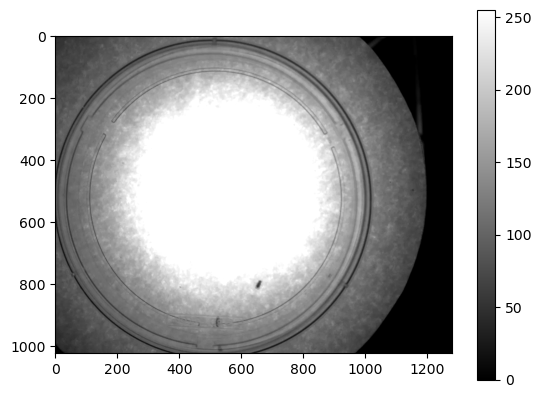

In [4]:
plt.imshow(frame0, cmap='gray')
plt.colorbar();

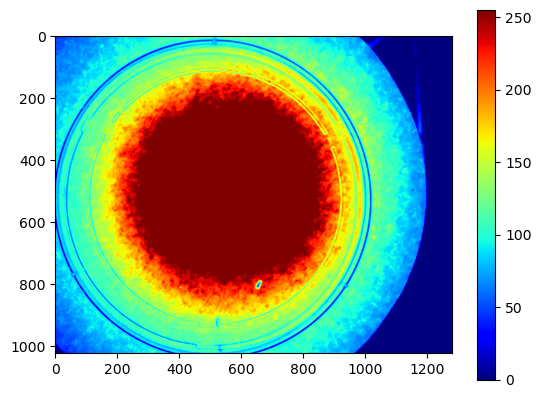

In [5]:
plt.imshow(frame0, cmap='jet')
plt.colorbar();

Note how the false color image lets you see more easily approximately what pixel intensity values are present.

Now, list make a histogram of the pixel intensity values.

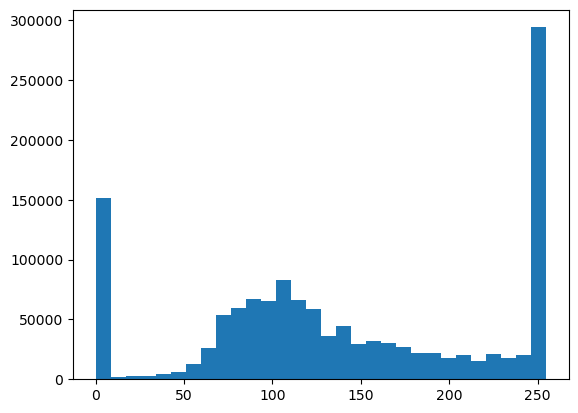

In [6]:
plt.hist(frame0.flat, bins=30);

Now we will load all the frames into a single large data structure from disk into memory.

In [7]:
# get all frames into big 3D array
(height,width) = frame0.shape
all_frames = []
reader.set_image_index(0) # return to start of file
for frame in reader:
    all_frames.append( frame[:,:,1] )
all_frames = np.array(all_frames)
print(all_frames.shape)
n_frames = len(all_frames)

(102, 1024, 1280)


Now the entire movie is stored as a large 3D array of size: number of frames x width x height.

Now, we want to find a fly in the image. The fly is moving, but the background is stationary, so we should be able to determine a single "background image". We can try to find the background image in at least two ways: with a "mean image" (also "average image"), which should average over the fly's position. And with a "median image" which should completely eliminate the fly from the backround image if the fly was absent for most of the time from each pixel.

In [8]:
mean_frame = np.mean(all_frames, axis=0)
median_frame = np.median(all_frames, axis=0)

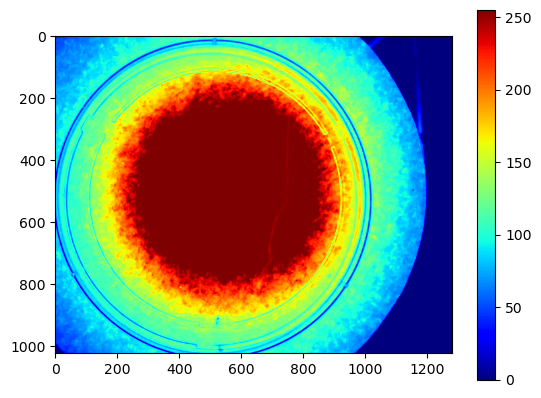

In [9]:
plt.imshow(mean_frame, cmap='jet')
plt.colorbar();

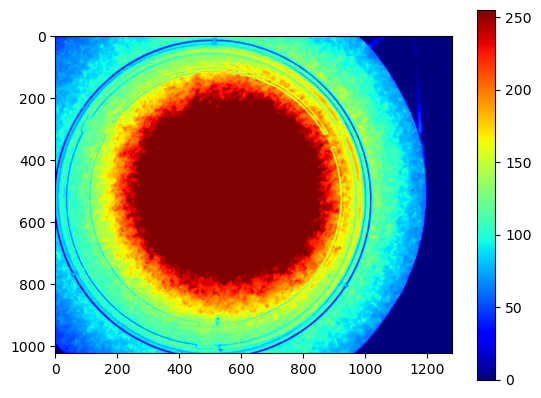

In [10]:
plt.imshow(median_frame, cmap='jet')
plt.colorbar();

Now that we have the "background", we can find the difference from background, which should emphasize anything that is moving.

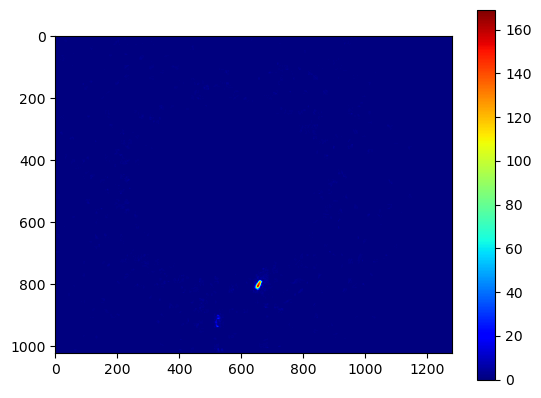

In [11]:
frame0_absdiff = abs(frame0 - median_frame)
plt.imshow(frame0_absdiff, cmap='jet')
plt.colorbar();

Now lets make a histogram of the `frame0_absdiff` image.

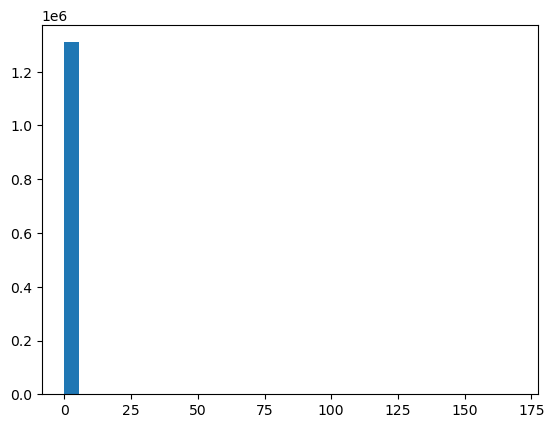

In [12]:
plt.hist(frame0_absdiff.flat, bins=30);

We want to find a threshold for this "absolute difference image" which will separate the fly from the background. From frame to frame the background changes very little - only noise in the light levels, camera sensor and caused by lossy compression to a movie format cause changes. But when the fly moves over the background, there is a large change in luminance values. This happens only in very few pixels. So few that they do not show on the histogram. However, matplotlib will automatically scale the axes, so we know there must be few pixels with values at 150 or above.

## Questions Part A

Enter a threshold below and describe why you chose this value. Put your answer in the variable `threshold`.

In [13]:
# Type your answer here and then run this and the following cell.
threshold = 100

(Here you should describe why you chose your particular threshold value.)

In [14]:
# If this runs without error, it means the answer in your previous cell was a number.
assert(threshold+0==threshold)

Now we want to "binarize" or "threshold" the image so that it is all zeros and ones (or true and false). This will let use use analyses like connected components labeling later.

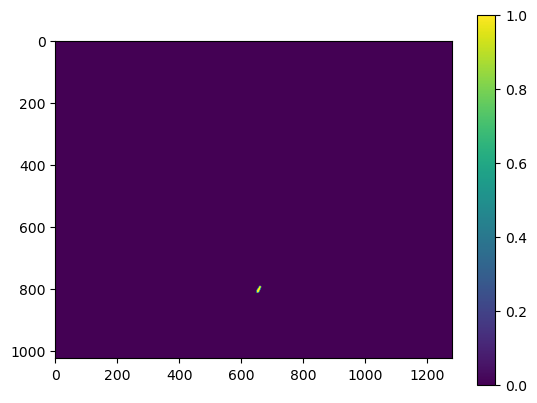

In [15]:
binarized = ensure_dtype_uint8(frame0_absdiff>threshold)
plt.imshow(binarized);
plt.colorbar();

Now we will use **connected components labeling** via the `ndimage.label()` function.

We will do more with **connected components labeling** later. For now, you can [read about connected components labeling](https://en.wikipedia.org/wiki/Connected-component_labeling).

We will use these labels to perform object detection. We will not bother to detect the fly on every single frame. Only on the frames where we have exactly one label do we say that we detected the fly. We skip the other frames, ignoring them.

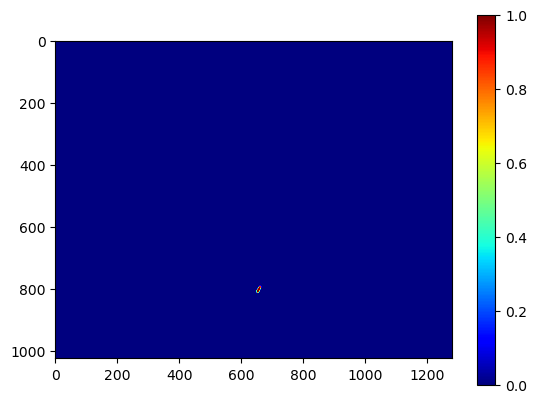

In [16]:
labels, num_labels = ndimage.label(binarized)
plt.imshow(labels, cmap='jet')
plt.colorbar();

## Questions Part B

Run the object detection algorithm for each frame and plot the result. Here, we are going to make lists `frames`, `xs`, `ys` to save the results of our object detection step.

Try re-running the above cells (from "Questions Part A") to the cell below with varying values of the `threshold` value until you get a good tracking result. You should ideally have zero warnings printed, but one or two are OK. 

In [17]:
frames = []
xs = []
ys = []
for i in range(n_frames):
    frame = all_frames[i,:,:]
    frame_absdiff = abs(frame - median_frame)
    binarized = ensure_dtype_uint8(frame_absdiff>threshold)
    labels, num_labels = ndimage.label(binarized)
    if num_labels!=1:
        print('WARNING: num_labels %d on frame %d, skipping' % (num_labels,i))
        continue
    y,x = np.mean(np.nonzero(labels==1),axis=1)
    frames.append(i)
    xs.append(x)
    ys.append(y)

Make with an image of the first frame (saved in the variable `frame0` above) in the background and then the fly trajectory overlaid on top of the image.

You can do this by first calling `plt.imshow()` and then `plt.plot()`. Your result should look like this:

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAbAAAAEgCAYAAADVKCZpAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0%0AdHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAgAElEQVR4nOy9aZBd13ktts6d57HnCUMDaKBBAoQ5%0AiYxkk6ZoORUNiZVSKbETVWyH75WqkjhKqiJH+ZEfiUX7xS7LsRI/VrlctF02E6cc07L0JDOaXKJF%0AgSJBkARBoIFuoOe5b995vvnRWru/s/vc2w2Q3QCMvaq6uvveM+xzzj7fuL5vW61WqwUDAwMDA4N7%0ADK47PQADAwMDA4PbgVFgBgYGBgb3JIwCMzAwMDC4J2EUmIGBgYHBPQmjwAwMDAwM7kkYBWZgYGBg%0AcE/CKDADAwMDg3sSRoEZGBgYGNyTMArMwMDAwOCehFFgBgYGBgb3JIwCMzAwMDC4J2EUmIGBgYHB%0APQmjwAwMDAwM7kkYBWZgYGBgcE/CKDADAwMDg3sSRoEZGBgYGNyTMArMwMDAwOCehFFgBgYGBgb3%0AJIwCMzAwMDC4J2EUmIGBgYHBPQmjwAwMDAwM7kkYBWZgYGBgcE/CKDADAwMDg3sSRoEZGBgYGNyT%0AMArMwMDAwOCehFFgBgYGBgb3JIwCMzAwMDC4J2EUmIGBgYHBPQmjwAwMDAwM7kkYBWZgYGBgcE/C%0AKLA94tvf/jbGxsZw7NgxPP/883d6OAYGBgb3PaxWq9W604O429FoNHDixAm88sorGBoawqOPPoq/%0A/uu/xvj4+J0emoGBgcF9C+OB7QHnz5/HsWPHcPToUfh8Pnz+85/Hyy+/fKeHZWBgYHBfwyiwPWBu%0Abg7Dw8Pq/6GhIczNzd3BERkYGBgYeO70AO4FOEVZLcva8dkLL7yAF154AQDwxhtvIBQK7dhX38/p%0AOPp37baRn+vbyPN22r/TMdodr9MxOo1zL9d6u7AsCy6Xy/E+yB85XsuybNfVaDTgcrls+3I7t9u9%0A47jNZvMDjXk3cMw6drtXt5oVkPfnVvdrNzan73Y7Pr9vNpuo1WqoVqu3dI/dbrd6vvzhse41mMzO%0A3mAU2B4wNDSEmZkZ9f/s7CwGBgZ2bPfcc8/hueeeAwCEw2E8+OCDaDQaNuHgcrmUoG0ndAl+rwtP%0AHsfj8ew4jsvlQqPRQLPZVALb7XarY+gKSz8Gf4hms9lRiHB87a7B7/fD7Xa3VeTyXtwKeNxGo4F6%0AvY5areY4jkajgUqlsmPMLpcLrVYLhUJBXWO5XAYADA4OKgEaCATgdrtt90S/7lsd/14VBq+t0Wio%0Ac8rzcQwcv66s+dz2ojh4Lvms5X7NZlPdg3q93va4fr8flmWhXC6j2WwqI4HjcZpLPA5/l8tllEol%0ArK+v4/Lly+r6neByuRAMBuH3++Hz+dBqtVCr1eDz+bC2tvahKy+Xy7XvhovB3mEU2B7w6KOPYmJi%0AAlNTUxgcHMRLL72Ev/qrv9p1P754UsBR8egCkd/Jl0NXJu2gCyv+rSurvXhA+sspz+/08nZSwPze%0AyRvkcTuNi8JbV+KBQABerxculwvZbBb1eh31eh3lclkpoUAgAGDrfiwtLdkEWblcVkKVz8jv96Ov%0Arw+FQgEzMzNKEHOczWYTXV1dCAaDAKCeodfrhcfjgcfjgdfrVefwer0dn4O8jzwWlZCcN7y/8h62%0AWq0dRhA/171Nfs5r6PSc5LG4X7VatR1Lwukzec36s5X3Uo5L/9vlciEcDiMcDiORSODSpUvY2NjY%0AcS6Px6OUl9frVcdoNBrIZDL3pOdlcGswCmwP8Hg8+OM//mN84hOfQKPRwK//+q/j9OnTt3wc6eF4%0APM63XgqQ2wmr0VKmkKCgp7elb9vpGIRUHro3uNfwoS6g9qKYAaBWq9kUAwBMTk4in88DADY2NlAu%0AlxEIBJRn4PP5EAqF1Pnj8bijFyvBUFMikUB3d7fjNqurq1hcXHT8zuPxIBwOq+vr6elBIpGw3XMq%0AIv2ecT7oHhCVfztvSvde9efZLlyte070lOjR6mg2m8rT2w18Bhyfjk5KjPB6vWqs6XQajzzyCKan%0Ap3HlyhW1TTAYRCKRQKPRUAZEuVxGNptVRozBv3wYGv0+IRwO49SpUztCZW63Gx6PZ1eBuhtkCFFH%0AMBhUgo8Cg4JU5n865b+4X7sQn+4VOMGyLOWxyHxSJwXWarVQr9eV9U8sLi5ifX0dmUwGAJTVHQgE%0A0NPTA5/Pp7YNBAKwLEt5b1SA1WoVtVrNFsbleejFBQIBJRD16/b5fDvGXS6XUa1Wsb6+jlqtpjyo%0AXC5n8yKoRN1u9w6FLD1yGf4FtvM6VAztnpkMw+mKhufk/ZQeW61WU6E9KlDpyTQajQ/syTiFNmXI%0Aczf4/X6Uy2X88Ic/VOHgeDyOYDCojlOv15HL5ZRhs184qBCiEct7g/HA7nK0E/T651KYMZxCoSfD%0AdXJ/ei3Sam53bCfBeSseolMYTP/MsizUajVks1kUCgUUCgUsLS0pARyPxzEyMoL+/n4Ui0VUq9Ud%0AYT7mAPXxtlot5anJa6KSp3Lx+Xwdc3pSgDWbTfj9fgQCAaRSKWWUNJtNFItFVCoV3Lx5E4VCARcu%0AXEAgEEB3dzeSyaSN1eok1Dk+HlPmETuFXXk98r7y/tG70u85t9dDkdLokde8F8jt9LHK+yTnQLvr%0AoxFy7tw5TE5OqhwXv2u1Wtjc3ESxWNzT2Az+5cB4YPsE6YFJL4bW9l48MOm1OUEqEpnDYCiLVrWu%0AwDgOr9errGtJSqAwZehIz3PRO9EFj9P4GQ7SlSSwTbDw+/2o1+uYmJhANptFtVpFJBJBPB5HOp12%0APDY9WXn90nuwLAs+n88muPcCkkNqtZoKTznlmOr1OiqViu1eyHyaHq5ttVrIZDKo1+tYXl7GwsIC%0AAODIkSM4duyYzRtxu90qzwfYiTStVgs+nw8ej8fmGemKRZJ4+GypKOnh8n9dgcpzUZHRS92rInPa%0ATl6jnGPyOyfl5Xa7UalUUK/XlaJi7nNtbQ2VSsXmre8X6LmTmLWfMGJ5bzAe2AGASkgnMOx13714%0AOu0S/p3OJZWjPM9eCB8yP9MO+rl1D2xlZQX5fB6rq6vIZDI4duwYBgYGEA6HsbGxYQsL6mAY1rIs%0ApSQjkYgtzFer1VCpVFAqldR27aAzNqmYGE4EYGMENptNFaokg5GCjYJejt/lcmFwcBBerxe9vb0Y%0AGBhAs9nE5OQkvv/97yMQCODo0aOIxWLweDzw+/3qGqRSlvdfPiNp5Eglsdd8o040cvqe52hH6pDn%0AbncO+beeD5OQIWwel9fj8XjUPvl8/sCEvZz3t2IUGewfjAI7AMiX9VaU1+3A5XKpPM9u7EA9LEUB%0AxRCcpInz79sVFpVKBcViUQntGzdu4OTJkwgGgxgZGcGRI0eU0C4WiyoMalmW8mgYruPx6vU6PB6P%0AImyQaCAJHF6vF5FIBLVaDZFIZM9hT0kk6ASdpVcul5VnxNwYn3kul1PjSiQSsCwL6XQa1WoVuVwO%0Ay8vLmJ2dVZRweqBer1cpVv257OYFfxA4MQiB7fmhK1b5N3/LOSY9LqksGUrUPyckzZ/eaXd3N959%0A990D9VTkO2MU2N0BE0LcJ4TDYYyPj9to85I8cCtoZxE7kTgo7Dp5GzymzAcBsCkwwO6VcNy6VS+9%0AMH0qWZaFarWK6elpNBoN5PN51Ot1+P1+HDp0SAlhr9eLfD6PfD6Prq4uRaSgN0WBEQgElFfTarVQ%0AqVQQCASQTqdteS/pKehhKRl27PQcpBJ3+o5jkqFWeX4KeMuy1LWtr6+j1Wohn88jEonYngXzby6X%0AC5OTkygWiyiVSvB6vTh8+LBNaYXDYfXsdC+Gz4cGgFQOwLZX6nTtOt1ePs9yuewYBm4HJ4q8FPx6%0A3RrvpXxPuF21WlWGAkknjUYDhUIBb7311oEpE5ZMsO5wP2HE8t5gPLB9ggxHSSacjk6EgU6QFjlx%0AK/R0YDuJzmPogkAPKcqcHM8jhZr+0l28eBGZTAbNZhOjo6NIJBIIh8NK6EulMjAwoJQvhZbb7Vb5%0AMY/Ho4qKiXg8Dq/XC7/f35b+rZ9Lsvn0kgU5/kajsaP428mb4L2QSkt6SvV6HV6vF6lUCv39/Wi1%0AWshms1hdXVWMOeYIPR4PWq0WTp48iXA4jFKphKmpKbz33nsAgGQyif7+ftTrdVSrVfh8PpviksxT%0AHksvpJfPSpIp+Bx4j5wEaLu56qTYnLwy/Zh8LrJsQ2e98p7qnhrnxpEjR3Djxo1bUq4G/3JgFNg+%0AQgp+YKe1/EHCivqx95Ir07+XrZP2SizRzyXJAWQQrq+vY21tTYXzRkdHbd4ehavb7UY4HN5ByODn%0AjUYDwWBQCU52WgC2PQ3S4Kn0JKrV6o4uHLcCmQvjPUqlUsoKb7Va8Hq9tlo7KmHLslQoVxoKrVYL%0A0WhUFeDm83lMTEygUCggHA7D5/OhWCyiUCjA4/Ggr68PfX19AIDXXnsNN27cUOHW4eHhHfdOjl0q%0ACMlIlUQil8ulFCL/J1FBKgU+Z5YvANs5QT5bJyo+x1Wv13fk2ToxFeXnvJ86pd/n86Gvrw/1eh03%0Abty4vYd8i9gr9d/gYGAU2D5CMgOdCBa7Ya+emZO167S//h2VgPQWCfmidspx0MIvl8u4efMmJicn%0A0dXVhcHBQZVzCgQC6likqQeDQeVVZTIZpQiAbfYit6PwrFQqNo9DCkAnRXWrbDFpFMjaKFmjtby8%0ADACqBo21ZVR01WoVoVAIHo9HhcV4TFkMXKlUUKvVEI1G8dBDD6FcLmNjYwONRgNra2sqTEVlY1kW%0AHnvsMSQSCSwuLuLixYtYWVnByMgIBgcHbWE6aSDJnJP0uhhC5nXq3qgT85QKOxgM7qDky1Ctnsfi%0AZzpLlONzKvPo9Iz0v3t7ezE9Pb3v9Vk6S9PgzsPkwPYJFEzS0tVDKboyAPbeiUN6QDI/Imua5Lmc%0AjkfFSkq9DHM6CX893NhqtTA7O4vNzU1ks1kVIuzq6rLRuEm0kBR/CkCPx2MjV0jBRrRaLeRyOUdl%0ApBsJcpztCr073VOSN5hv0e8hAEUm8Hg8qFQqKtyoC+JwOKy8I4Y69eOQrq8LxVwuh2KxiEwmoxSP%0A1+u1MRuXl5exsrKChYUF9Pf3Y2RkRCnWeDxuKy1wavFUq9VQq9WUN6nPUTkuPm+fzwefz6e8XX7O%0A88iQJe+/9Oi4n07hp5FCD06n4fM+ybpFqRDz+Tx++tOf7vlZ3y5u1Qi9XRixvDcYD2wfIQXo7eS5%0AdgO9FJ02zx9ZKKpbxZIuTgIBYCc+tANbDq2srGBiYgIejwdHjhxBNBpVljaPSw8iEAjYBCQFst/v%0AtzWAtSwLlUpFsfm4v57joCCV4SV5XyT2GqKVxoDu0VCQyh6L8l5Iijd7LZZKJUX5drvd6v9YLIZo%0ANKq6R0giAxVANBpV96bVamF9fR2NRgPValUZKb29vUgkEgiFQpidnUUul8OhQ4fQ19e3Q2ntZhi1%0A+0ySdYhO+Sbd6+NclIQgEmT4P2BXRvy/naej58WALYPxsccew/nz59uO7cOAUSx3F4wHtk+IxWJ4%0A5JFHANgb3uoKhd/r2C2nRQXAfAxBxcFmslIIyPOQjiyJJsB2KIjCVEe9Xsf777+PbDYLl8uF/v5+%0ApUwokAKBAMLhsM0j0dswJRIJNW4KNPayYxd4/VpTqZSNPEJFCWBHboTH1a99t7o4WYAsvQmGEsPh%0AsFLS0kPjNbBwmjk5JyYkFV0wGEQoFFJGCL0M/pBtRzDPw7qzQCCgclJ+vx9XrlzB6uoqSqUSzp49%0Aq3ox8rp0D1F6NfI+0WCQSlB2xJfQPTBCenT0wOjtyfAj84fsXi89MD1cLOek9Pb4f7lcxvvvv4+1%0AtbW2z/hegRHLe4NRYPuETgpMChKnMB1BIS4FDF94KbxlzkN6VhSeTkqMyobHk3VPVDilUgmVSkUJ%0A3GvXrmFhYQEulwuxWAyHDx9W7ZxI7ZbhUZlnSyaTaryt1tYyJtLzKJVKirTR29u7g1Cie7J6Ml33%0AQuVnFJSyAFaHNCx0D0w+Q9aUccz6+aks2D1CGitSyFMo0wDp6upSSlAvgF5bW9uhOCYmJnYYJMBW%0AF5CNjQ28/vrrAIAnnnhC5RF5D6TXoytJSeRgmLHRaKBYLO5QSjwGFYlTzlWGnHUFBmzPZx6fx9MV%0AolPYUJJTZPjxypUrmJ+fd3zO9wqMWN4bTAjxgKHThNtB99BkjYzudem5Hxm20RP0OpxYVXoCf2lp%0ACYuLi6hWqxgYGEA0GgUAlEolRWdOpVLKiubxPB4PkskkQqGQTdgDUEIRAEKhEPr6+nbQ5OV90BVK%0Ap/sl7wX32UsDZbmPfl5JlyejTj+e/pzoWVEh6kpWKviNjQ3b2mMylBmLxRSBhczRs2fPYmJiQnVe%0Al+HH7u5ufOITn8DU1BTOnz+Pj33sY2rMvDY5Z+T8kGxUadhwzunb6/den9t6HZoTnIw4zl8eQyd8%0AOOWRud/w8DAWFxcN2eI+gPHA9gm7eWBSQLbLP8jQHvMotKadIJUjBUA71pQchywaZviQ5ITZ2VlM%0ATEygr68P/f39KiTFUGEikVBFs8ViEfV6XS11IT2ZUqmEbDarrrnZbCIajap+hbTEnWqNnO6Pk+LV%0Ar435o0ajoXocfhDQA8vn8zbrH9hmJbJtFQBbCFH3VPSaK/1aGBqk4pVjLxaLsCxLeS2ZTAbVahUr%0AKyuqhyIVTj6fx+LiIiYmJvDwww8jmUyiu7tbMSJ1T0fmAdntvV6vo1QqqbZW+pxqV0jMUCePye4p%0AErIkgWNpd098Pp+al5IAwvPL8GK1WsX3v//9vT3YuxBGLO8NxgM7YDgplHYJdrmtDOkwlKNbwpIW%0AL4/hpADkvhTy/JxNUldWVlCv13Hu3DkEAgFFsmC9EpVeoVBAsVhUNVLMeQBbdHG2karX64hGo3C5%0AXIhEIjvaNemU6t0IMFQElmU5hlkl447HYHhOZ7nxPnSC273V5JcKUoZpqdSpNIHtwmB6YuxmIc/J%0Abfx+v1J4km3H64jH4+qag8GgasTcbDYxPDyMUqmEWCyGpaUlZUx4PB4kEglEo1EMDQ1hZWUFN27c%0AQKPRQCqVUnV1VL48vvR29RWhec+kVymVK5Ufr0UPTZPEwW35WxI7GOrV3xNpmOlMVfksLWur/ZjT%0ANgb/smAU2B2AntjXC5sJJ4XkVLfT7vi7CWRd0TUaDayurmJubg7z8/MYGRlBb2+vEtRdXV2o1+sY%0AGBhQOaxms4lwOIxYLKaEBhvocq0sn8+HZDJp8yjbKW392nYjXeisQWDbi3C6fr3WTR5f90aczifD%0AWRSobHHl9/uRy+V2PE/S5/nMpVLgHJDeIgClnDiezc1N9PT0IBgMwuVyIRgMYmhoyFb0HI1GEY1G%0AMTExgWq1imKxqIgckUgErVYLy8vLuHbtGrq7u1XjZHqrktzhVG8nw3jtFAOfsdPaY/LZO81PSXKR%0A4DlpPOghSx5PhmwB4Nlnn8X3v//9A+lUb3BnYBTYAUOP6wN7L+Dcy3b6eZyOoy9xQus3m83ixz/+%0AMfr6+vD444+rfXw+n+r0LgkYFJqWtVWsnM/nleJiroYLD5LaLq1vXXm0U1YUUrK/H7dnJw9ZT8X7%0AxFCUFIz8yWQytkbA5XIZS0tLysOUYyFbkMuY8NjMARL6+mv8m89CMjU5ThY8y3vCxsVcyJGCO5/P%0Aq8JpSbaIRqNwu91YXFyE2+3G+Pg4FhYWsLa2hkwmo66/r68PR44cwdtvv42pqSkUCgWMjo7C5XIh%0Al8s5Ltipw0m56JAEI72bB8ciu5VIZS7PoxsmBD+XhgT3kePxer34hV/4Bbzyyisdr8ng3oVRYHcA%0Aeh5st22lsHIKHd7O+fVzT0xMYHZ2FocPH8aRI0dUCCoQCCAajSIcDqvCVyoFmfBfWFhQuRkKQnbb%0AkHVZUqDzf6nI9YJbCd2al4QVlg3IMBdDngwbSqU5NDSEWq2miCThcBinT59WCkyem/R+J/B4FNQy%0A7EdQyErFJe8h74keUqVXxu1lK6WVlRVEIhGlwAGgp6cHxWIRjUYD/f396OnpwZUrV1AoFABsFUe7%0A3W6cOXMG4+Pj+OY3v4lisYixsTF0d3er+y6fq9Oz2Et+Rs5xGW1wUlK8N8C2MSWPI6ErTBludAqf%0AA8DAwMA9z0o0cIYhcewTJImD1qYUrk65Kf0FpPBlCEpnXMn92h1DhxRQ1WoVjUZD0eM/9alPYXFx%0AUY2fJAtgu2sESRcyid5qba2Im0gkVMGyrmDk9fMecK0tvQ5NdoCQpBRpwXPacqkVWvNSkHV3dyvl%0Aubq6qpYzAaDCnLv1SvT7/YjH44hGoyq3Ru8oFAqpmiOGBXO5nPKiJBtRf068B/xNBRYMBgFsswpp%0ANJAAITvhk5mYSqVU+yr5/Dc3N9FsNlGpVHD16lW1inUsFlPLtExNTWFxcRHBYBCHDh1SS9ZI1qb0%0AemV42qmgmdfIZ8hnIueuJILo80iGUXlu/ZxOeUun8UjizPe+970dTNi7GUYs7w3GAzsA6LmaW00u%0A30qoca9wu91YX1/HG2+8gcHBQTzxxBOYn59XYTrZtJYMSNmxgzU91WoVfr8fAwMDNmWnKyz9OiS7%0ATlrgvD+yuwVRLpfV/7Jgm0Kbi0EuLS2h0Whgbm5OdcWQHpllWRgcHFTEiE4Ufd6ParWqlkVhKHFx%0AcRHJZBLBYFApuUQigUwms0MxStaiZVkIhUK2zhq8P7pnpnvcnDv05hqNBhYWFtDb26taTfG+xONx%0AVa5w5swZLC8v4+bNm9jc3ESpVFKrQQPAO++8g3A4jL6+Psd5RiNjt2VEOs1raXi1y3/xXDKsyDCr%0Ak5LSDbl25+/v78fk5GTHse8V7a7B4OBhPLB9Aj0waY0T7YgYTp6VkwemQxdwOsNQR7VaVasgJ5NJ%0AJJNJtV1XVxcSiYQSBlwZ2e/3IxKJoFAoqByX2+1GPB63tcySBBV9TFRSDCtyP2lxSyUo6dIydwds%0AkzEKhQIKhQI2NzdVPmhkZAShUMjWzYPeFr2LZrOpQp3S46My5JpZVLKBQACFQkH1QeQ4qFSbzSaK%0AxSKWlpbUtUWjUfT09CiBTI/qxo0bKvTHe0tPkXOAbcKA7Zo5emKcQ6S28zO3262um6QNKs5KpYJs%0ANotmc2tB0c3NTVQqFQwNDaG7uxsbGxuYmppCsVhEMpnE+Pi4bT5KWj8bD3dSVvLcnFs8nvTA+J2k%0A6MvcF8PD9OT0dck4Bt1z53eyW8drr732oXTpkF1u9kt8GrG8NxgFtk+QIUQ9tKPngAjJouL2ckn7%0ATrkBeZ52Coz06qtXr8Lv9yOdTiuBnkgkVGgM2M7lRKNR2yKC7C7B5UAkbVyeSwo/2dSV16zfE4Ln%0A4fpYHE8sFlN1TzMzM4o8EovF4HJtL3PidrtVE116DJJYws9JQnG6h/Q2ZI2RThWXwpkswlgshlqt%0AphRqLpdTvQ5Z0E1FtbGxgXw+j0KhgHQ6jXA4rK6pWCwqxVmv11Eul9U8aDabKBQKivwgSy343ICt%0AtcPkNVHA08suFAp48803lZI/fvw43G43Lly4gGvXruHcuXPo7+9XC2+SxOL1epU3Sqq/HtaT8003%0ADuRzlvNGKjVp0HDeUGEw7E1vTO67mwLLZDJ4/fXXPxArkc9atvvaDxixvDeYEOIBQFcihFMeyylv%0A1Cncon+ufyeVZrVaxTvvvKOWZKe3I/M69IgoEPx+v/IulpeXEQ6HlYJwUgCdxqEn2J3uRbPZhN/v%0AR19fn8op1et1vPvuu0pZnTx5UoX2ZKhOEgWkIpd5MZmL0SGbG8swlvxeKjdJUGD4joxBhhWr1SrS%0A6TTm5uawsrKi6qPC4TASiQT6+vpUnmtxcREul0t5T7IfIkOlVP5U8LyXBAXrjRs3MDg4qBQmn1dv%0Aby82NzcRj8fxwAMPYHp6GtVqFRMTExgfH8e5c+fQ09ODyclJ1Ot1jIyM2Or+eL2ySbFTVxjed2m4%0AtMvbctycE04F53wPZBssj8dzSysj+3w+DA0NfSihxA8znG9w+zAe2D6hE4mDkMKW/3NbnQ22m/DV%0Al9ogKITX1tYwPz8Pn8+nwlqhUEiFC6XSpIDiuDKZDNbW1jA8PIxUKqUsWBkSAuztfThGSb7QBRkF%0AljxXJBJBLBbD5OSkssi5sKP0KhhiZOjJ7XYjFoupThRkTcrl6GWjXJ5f3kt2JJGKQW4rCSzyXjFv%0Ax3AkCRccB8dLZZvP57G0tISlpSWEQiEMDQ3BsizlKWYyGcTjcUXxd7m2as1k2LJarTp2rKBnUiqV%0A0GptdekYGhpSyplzgl7uzMwMLMvCtWvX4PV6lTe4ubmJy5cvw+/346GHHlIhRHpsvE4ZwuQ9lLnT%0AvS4oGgqFkM1mdxhrMtQox83/5T2QNWv8W3pgDMNOTk7eNitRvp/tiCwfBoxY3huMB7aPuBXyhQwT%0A6l6Y/JzH1Rl57UKUDBctLy/D7/djZGREKaBkMmlb5Zjg+SuVCtbW1hCNRjE8PIxIJKJCi+1CJ1TC%0AurKWq/hyu1arpRZ1LBQKaDQayGazmJ6exqlTp2zeDvdt52UxPyOb9kpPQV6XvI/ynuktmyS5hMfj%0AMZ28TI5D91LoPUgPY2BgAEePHgUAXLt2Dfl8XjEAx8bG0Gg0VJjO5XLZ2Ik6yYPeIoW2ZVlKeDNv%0ASQOHHibvP8Oe6XQam5ubaiXtRCKBj3zkI5iamsIPfvADPPHEE0in0zbjRd4jvZZLN870cKG+jcfj%0AQTgcRj6fd5xXcr7Jzh1yfrRjecr9eM23q8Ck0WOUzJ2HUWD7CCkoncCXQXo8shhWCmt+xs/1nIy0%0ANCVyuRyuXLmCYDCInp4elMtlW3Gx0z5M+LdaW+tScdkOnV3YLkwo2zVRufr9fpW34XVwGRASI1qt%0AFtLpNNLptLKoLWubHk9vzMljpXDm/ZHKjtszxCf/B7YXm6TwdAptSkEsO2vogpVhWF6P9CDoLTC3%0Ax/E+8MAD2NjYwOrqKm7cuIF8Po90Oo2RkRGsrKwA2Kqzo7dMJUivMBQKKW+I5/D5fIpgksvlUC6X%0AbQXZAFTuk+URAPDmm29idRAB5EkAACAASURBVHUVxWIR/f39ql7unXfewfj4uFooU5JO9JyrVGbS%0AAJD3i+HH3fK6UuHpHrMsT5DNituB2w8NDaFer+PatWsdt3eCJF8ZBXbnYRTYPmIvnhdfAqcwWzvl%0ARatbvkh63sDtdiObzWJiYgKWtVUTxWMEg0EbQ4+Q4a9arWZjyu31eqWCpRfH41qWperEuru7MTs7%0AC8va6vPHWiYp6OSx5LHJ0JOWMD0KPV8kPSFZawTYqfisYWNejUKYzEdJHpDjkgaHLAnQhbckZUji%0AA725VCqFWCyGZDKJarWKQqGAn/zkJ2qBylAohKWlJeRyOdtil5L4oysLevWBQEAZA+xNyedDj5Vh%0AvyeeeAJXr17F9PQ06vU6hoaGcOjQIbz77ru4cOECPvaxjykCiyx9cApv6x4SobP3Wq2W8sDbQVcW%0A0gvj/Zf1Zk7gnGg2t/pHzs3NfaDaMJMHu/MwCmyfIAVuu4lOBSSVj1RSHwTT09MolUoYHR1V7K1Q%0AKKQS8k7HJ005EAgglUopxagrUl6fPk7m1Rj2ImMNgMoJkRF38+ZNDAwMKBYjPRK9HRTDSzIMqNd/%0AUXHxbyotMiwpHOU28tjMD0UiEVsIDthuDOx2u5FIJBAMBtFoNFAul1XnESoLy7JUeQEVLbBd1EvS%0AgcvlQqlUsuVsmM+hF8clajKZDL73ve8hlUohEong0KFDtjIGMiJlmJJCmgrM5/Opa2cujvk8zgWv%0A16uEeW9vr6LKz87OYmBgAI8++ijef/99fOtb38JHP/pRhEIh2/wAtj1SOV90hSaVmvyOecrbCc/p%0AnnA7SIPP5/Ph4Ycfxo9+9KM9n0eC19FJ6RrsP4wC20dI4a4LeqcwnLTu5ecy19MOUuBfvXoVGxsb%0AOHz4sCreZVdynkdar7VaTbVL6u3tRU9Pj0q+cyx6boiCTwoa6ZEwZEYPIR6P480330QqlUJvby9O%0Anz5to+VTmfA4kvrNc/JcFN46c5PLsvD8MmQpxw1s50eSySRSqRQAqDBcMBhUJBHee3qH7H/ocrls%0Animvl+E4hhllfkYPofEY0hujkqPS6+7uRiKRQC6Xw9raGlZXV3Ho0CF4vV61RhvvG8fNa9fzYZKQ%0AQgKMZVmKoMEi6MHBQXR1deH69euqZ+KRI0dUp47XXnsNH/3oR1VXj2AwqMoV9Byj/M37KZ8JxyOf%0At/Sod5vv8lqd2Ivt9uW9OHnyJN5///097Sfh8/lUpxGDOwejwPYZTh6V/plUBLfjgfHF93g8WF5e%0AxubmJkZGRmyFwxS2OpGBdUWhUAgnTpwAgB3UdLk9YF+1VwoZ/RrpgVmWhcuXL+PcuXPwer3K26AQ%0ApZfDY0vPgnDqzCFBAgeVX7t8IVmErLmiItZzWfxfHk/3IHQhzG11j1XSyWXIWIY4dWUtj+H1ejE2%0ANgaXy4UrV67gxo0byoNyu91qMczu7m7kcjllnDi1sJKhRSo3Pgs9p9jV1YVqtYrLly+j0Wjg1KlT%0AGBgYQLPZxHe+8x08+eSTtpykvFZ5/bKLR7uaMTlvbqVAWDcA9woaTLFYbM/7OJ17N0VrsL8wCmyf%0A4CT4bwWdhLUO5mcWFhZw7do1nDx5UgmCWCxma5lE4cQcGYtmA4HADm+l3XWxDRKAtlav7DZC4cdu%0A7AzrUYhEo1ElVOlFMSdDoSc9O10405MJBAKIx+PKq2OokWG7ZrNpaywciUQQCARstGw9xyiLu+W1%0ASaq9VHYyPCs9H46F1yQFH/ehFyxDoVw/jQtlkrn41ltvKQbnwMCAWgan0WggGAza7hONBqkYqTRL%0ApZJ6liT20AuMx+OIx+OwLAsbGxuYnp5GLBbD2bNnkcvl8O6772JsbEw9N+ZVpVKrVqsqlMv/M5nM%0AhxJ64xzgfd2LxwZsK/RgMAjLstDT04Pl5eVbOjfHf6u1aAYfLowC20fopAyCwkVaojKfw+2dlBjz%0AHNJad7m2lge5evUqxsfHbWSHUCikXnQKZYa7crmc6g7h5FXwfDyPviQKYFe0zNusrKxgaWlJtali%0ATRYhw38UsPLaZNd7npteEcNzMidGgUwFSeJFIpFQy49wOwpoYLuTuRwXt9M7Qsj7Idse8VwMfZEN%0A6fF41CKe8hnrDD6d6MF7RU9O1n/Je37mzBlcvnwZExMT6O3txfHjxzEzM6OUPXNpbP1Eb1fm3eTx%0ApJLnM6Wh8uCDD+L8+fMol8soFAqYnZ3F6OgoEokErl+/Dp/Pp4rM9ZWvpUfK+0+jwalWS84DyeJ0%0AAu8Lz6e3rdLfKYIGBbBFcDl27BhyudwtETq4v1FedxYfjClg0BGdvBnJhtvL5/o2wHb3gkqlgrff%0Afhvj4+PqxYpGo0ilUrbu8NILmJ2dhd/vVx3n23lceo5L0sP1cRaLRdy4cQM/+clPcOLECbWcCrBt%0AlevdLvSkPQWW7LzOe0iPjQtnynArvSmGsLxer1r1maDCYFcJCjcqonQ6bVP47aCvUizDnlSwvE55%0ArRwDFS69TRmSlT0HGfalNylJCM1mE2NjY3jiiScAAK+++qrytnkun8+nWn5xLCwZkHkvl8ulFJ9s%0AkcTrcLlc+MhHPqKe8fT0NJLJJAYHB9Hd3Y3FxUXk83mbUSHvuSwl4Fyg0eT1elVuVp93ewnN6SQj%0ACTk/pBLVc3N+vx+HDh3a9VxO5zXhwzuL+06BzczM4Omnn8apU6dw+vRpfO1rXwMArK+v49lnn8Xx%0A48fx7LPPYmNjQ+3z1a9+FceOHcPY2Bi+853v7Plc7V4soPOqyXtVYn6/H9lsFq+//jrGxsZ2ULL1%0A0Bfp2dVqFdFoFMlkUjEGO10DBa1uGdPjoNCcnZ1FMpnExz/+cRVmo8cC7I2MQu9UX9YjGAwqwgCw%0AzQ4EtoRJpVJRjX0pSLPZrGqHFQgEEA6HbQrd5XKpsBmFkVSw7UDPNpFIqGVn+DcZn/T82PKJP1yG%0AJR6Pq0VC/X6/uj6SbXjt3J4tvGSTX2DLgxgfH8cTTzyBqakpW5ukbDaL5eVlmyeoC3IqMXq1pVJJ%0AeSNcyJQdTp5++mkMDw/D6/Xi8uXL8Hg8GBwcRKPRwNTUlOr+XywWFSFGRgzocXE+SY/+dkPtku0o%0A5xaNBNYwyndRV2I+nw+Dg4O3dX6DO4v7ToF5PB78/u//Pi5fvozXXnsNX//61/Hee+/h+eefxzPP%0APIOJiQk888wzeP755wEA7733Hl566SVcunQJ3/72t/HFL35xz/F7J4EP2IWIU2hRj9frpAQK28XF%0ARVy6dAl9fX1IJBIqPEMhDdhXwW02m7h58yZqtZpqU+TUVYIvuPQuOgmYzc1NTE5O4pFHHrF5c3qv%0ARB5LKhAnIogkONBr5KrDOlFEtn5i6Eseg0KaLZtks14p0Lg/x8lj6OOX3T70/oQyLyY9SJYl8CeR%0ASNhCjfSKgsGg8lr5XDgWjlvuxx96bmfOnEE6nVbFz2zz5BSC47GlJyhJHVTC0lv0+/04cuQIxsbG%0A0Gw2ceXKFaRSKZw9e1Z12c/n87YlbOS523VE0Q0cpzmivzNOBAp9O3mtEvrYuD3zeQb3Du67HFh/%0Afz/6+/sBbIXZTp06hbm5Obz88sv4wQ9+AAD4whe+gKeeegq/+7u/i5dffhmf//zn1ct77NgxnD9/%0AXoVuOkHPU0m0C3nwO+Y/KCTJ3AO2BAGT6gx90atiLkLmHNxuN1ZWVlAsFjE4OIhoNGrLXUmqN3Mx%0AciyytknC4/GgVCohn8/j8ccftx1DP66T8JHHlyFCea/YS1DmaSi46EHR0wOgQmbhcFh1/+B94Fpe%0AktEohZgcr1xqRT4f6fnpRcwcE2Cva9I9OieyjOzEQoKLvF5gu2OI2+1WQp/3hXmu7u5u1Ot1vP/+%0A+3C5XDY2qj7/SGKQrESXy6WU19raGrxeL3p6emwK0+v1Ym5uDplMBhMTEzhx4gROnjyJ2dlZTE1N%0AYWRkRI2T4Vpem6wVk8uk6ApH/i9zt7IDv1Re3F5/pjKHJo1I/pbnHhgYwJUrV3bcK4O7F/edByZx%0A48YNXLhwAY8//jiWlpaUYuvv71espLm5OQwPD6t9hoaGMDc3t+uxpZXnZPERUlhLD4zCXAp82flg%0AeXkZPp8Po6Oj8Hg8CIVCSpjrx280ttaTAraapvLYchs9/KJbyfLlJ7FgZWUFbrdbrR0lFYNuPTvl%0AIaSHJwuK5Y8UZnKMFOaBQECxKvVcn8y5AXYPgF6HHKdO6NAFv7wWClQpkPV7SOEt20vREJAhLN1w%0AoZfV19eHSCSi9ge2lR89Jjk3eD+8Xi/OnTuHw4cPqxW2dUjFIo0J+QzYFJhhWSq7SCSCo0eP4tix%0AYyiXy7h69SoSiQT6+/sxMzOjPDcAtmepM0dlt33d05Leuj4uaUw5Lb3Sbt4SfBdlsTqP+/TTTzve%0ALx18r3cLiRvsL+47D4zI5/P47Gc/iz/8wz/sWAvilItqF0574YUX8MILLwCAredeJ2+rHWhZ07ug%0AcgOAS5cuwbIs1ccuEAiosJQuiOfn51V3jb6+PgD2/NFeoHspmUwGGxsbePLJJ5WnwWumZa8L83aQ%0AHgoVC89jWds9DaWXA0C1w9Lr2yjwg8GgzfImtT4SidgUuKTnS2G3l3wdIcONPIasH+M2hNfrbdul%0AnZ43f/v9fkU9Z16NBAwpvKmQvF4v/u93NjASaeFUKgm/34/Z2VlsBnoxU3DjF/u3KfN+v18tikkl%0AwvsoSxdWV1fVis8MUx89ehTLy8uoVqtYXFzE9PQ0Tp48Cb/fj1dffRWnTp3CiRMnbKFIeU9lLaA0%0AAPT5y+2pvHgPPqwOGDSEqCTL5TKSyaQtB+4EWUZimIh3DvelAqvVavjsZz+LX/3VX8Wv/MqvANhq%0An7OwsID+/n4sLCygp6cHwJbHNTMzo/Zlax0nPPfcc3juuecAAIlEwkaRbqfMdCFJRhwFOl8UvvD5%0AfB6WtdXbENgSRF1dXTa6NQV9Pp9HNpvF8PCwjd7MRHo4HEapVFIChtY/t5GUapfLhZ6eHpw/fx5H%0Ajx7Fk08+uWP8kt6u57dorcree1Jg8nMp8LkdlYKsJ5IeF4W92+1WniiPQQ+Jgld6nqzJkl6bDE25%0AXC5b81tSv0k+0HNyAGx1ZRSMTkYQF4ok5BwJhUKqwLvRaCAQCCCdTqvnz/vp8/mUQJfz6WR3EH/w%0Ak038t48H8UBPBHO1MP7sfBa/cXK7bIHLrVSrVXWdVCiSbcr7kc/nUavV1Lwm2cTv96NSqWBmZgbT%0A09MYGxtDtVrFhQsXFN1fZ5gC24YLO5zIZVFY3qAbbjLU7LS6gR6eluFBepS8R3yvSLqR0Y+xsTG8%0A9tprO56ZDhl2NrgzuO/831arhd/4jd/AqVOn8KUvfUl9/ulPfxovvvgiAODFF1/EZz7zGfX5Sy+9%0AhEqlgqmpKUxMTOCxxx7b07lkuExChq3a7SMVHeP++Xwek5OT6OrqUoW7sVhMhQXlfo1GA6urq+jr%0A67PVWcmX24mCrIf95BivX7+OQ4cOoaura4dwAbYUGD0cl8ulwllOISoZEpIhI/lDxSLDSpL6Le8Z%0AiR5UXvI7YJuAIcHwla60ZAhXtoviuGX4UYdUvO3IIE6Qx3K5XIpBynEHg0HlYXGM0nOVc20q28R/%0APB7F//ZaFr/9/Q387xdK+I/Ggri0uJUDTKVSiEajuHr16o7nLu+9vAbW5un31u3ebj2VzWaRyWSQ%0ASqVw8uRJXLlyBZOTk7ZclAzdyZynDBfL0KGcnzoJaq+Q90sPRzOvJq+Ji5Ea3P247zywV199FX/x%0AF3+BBx98EA899BAA4Hd+53fw5S9/GZ/73Ofwp3/6pxgZGcHf/M3fAABOnz6Nz33ucxgfH4fH48HX%0Av/71PQmkW4EUsu0a7VqWpYpGKaT9fj8SiYRtu1arhc3NTZTLZUW9ljVIcrtyuazO60Rq4Het1la3%0A8EQiga6uLlsnDZmfoaCiUKXHIj0xnptKmZ6RrH9yunZZ+yYFW71eV4pTV17A9mKQ7Y4LQOXQ5D4c%0Ap47dnr1T7uzDgp43k149PRiXy4UHB4D/5fsL6Il4cH2jho8OB/APkxX8d08cgdudRz6fh8vlwuDg%0A4I5CaxomUpkBW+3FqtUqVldX0dPTo5Q/u+cfOnQIMzMzePPNNzE+Po6enh5EIhFMT0+jq6sL0WhU%0AhU2dPFeCisbn86FUKqkQss42pHfldm+vRcbxO+VNGRJ1ubYbKTvdX3r8w8PD2NzcbPssZOmFLLo3%0AOFiYFZn3CYlEAk8//bSj9eiUuAewQyEA28tGsDM4V9elx9HV1bVjVdjp6Wm4XC5Eo1Gk0+kdCkxa%0A7zIkxrHJ2i05LjL73G63EixyWRYZMpOFnpKeLmtyeFypvGglU0gx3ONEcJHFw8x9OUF2XpAgXZwl%0ABXJ7eT/uFtRqNUWooKLhNQDb62I1m038P++u4//45yX43UC1AfznZyL49NhW2PKNN95AvV7HqVOn%0AkMlkANhzgJLpx2fHFaAbjQai0ai6Z81mE+vr6yiXy7h27RomJyfhdrvxxBNPYHV1FT/60Y9U+ykW%0AieuKWObCZC6Ry9pwHuk1ZWyhxjE65cVkLSKvgaFjQj5jsiILhQLeeOMNx+4cHo9Hrc1WKpVQLBY/%0A9K70RizvDXfP2/kvEBTw+vpV8nup0GjVyTCaZVnI5/O4du0aent7lVCPRCKq1Y/0SIrFomrpxB6D%0ATuEYLqvB5D0VQrVaxebmpsoNLS8vK8IEFR2tX+mlMQ9HRaSHDcnG4084HFaFu9xe5txIxJBkCF2x%0AMwFPOrbT8u7VarWtR8QcjARzjQed29jL+WgAyFAiae0sofi/3l7H37y9jr+6sAaf20KlAZzp9eOl%0AS3m8s7zlAZ09exYejwebm5u2GkOdBSobBnN+NBoNFAoFJbQ5x2OxGEZHR5V3Njc3B5/PhxMnTqBe%0AryObzQKwswKlgqTy4vI6Mjeph8eB7bCxHm7mfdJJNNKw0g0gHls+g3A4rLqPtAPHcDcZOfcbzJ3f%0AJ7hcLhtDThaNyqXdpTWqK69Go6HyCqT403tisTIFQq1WQyaTQTabRU9Pj+paIRWJ0xilxctkOoXJ%0A7Owsenp6bOxGhpfYHUK2dtIZfPKH46ZgpIKVDDCZG/N6vQgGg7YQKMEuHyRscKVhpzCh02edQCHa%0AKcy1H9jLufS8lNOzfWAgij/76Qo+djiKaqOF0bQfby9V8MxoBJMbWwre4/Hg4YcfRiqVQj6ft3nF%0AJPKEQiGEQiEV3pUGiGVZKJVKisHIUHV3dzfOnDmDVCqFubk51Ot1HD9+HIFAAFNTUztqviRphoqA%0AC6p2uj8ymiHvhcyZtssx8/plCUU77BYKvpU8nMH+wCiwfYJT+Imfye4RTkJJ5neuXLliW/02FAqh%0Ar69PWZdUYNVqFaVSaUfvO0LPm1AJSSXHMQYCASwtLWFoaEitlQXYvQQKNAqNTlRiy7KQTCbR3d2t%0AyCepVEpdd29vr1LIetGv7BUoIYtqO1nBt6uE7larWip6Khv2fHS5XPjIkRT+1ZMD+MblLRr4QraG%0Af/2RXrw6XcLxLr9tHsTjcRw9ehSLi4s4fPiwMrh4DpYpSIo+5y491Xq9bvtucHAQPT09CAQCmJyc%0AxObmJh5//HF4PB5cuHBBLffCLvvAtkHCcPFuJA19vureOWCvw9TDezIMzf+pDOX/AFTpiQ4qd6dz%0AGxwc7s639F8YJF1bD5XJ0KKM8ZfLZayuriqBb1kWwuEw4vH4jgawlUoF6+vrKpxGwcI2QgxPyn0Y%0AgtNZf4ODg5iZmcGxY8dUfRzDL1SYHIMUQO2Ws5AhplAohFgshkgkgnK5rIQvadnJZFIRLqRy5liD%0AwSCi0ajqFXg/hm+cQn2yDdWfv76A6Y0Kzg1sdTB5ajSGEz1BfOxwFFObTeVF8ZnEYjF0dXXh4sWL%0AysuXnTKovPjs2BcxEAgow4kGFvOhJ0+eVD0S5+fnYVkWjh8/jpWVFRQKBZU/pQEivSbOYVmIzmfs%0AxI6U81l/j5w6bxB6yJCf8doY1ubyNXIb/ua9lw2jDQ4W99fbfxdAMv1k6ENaclzq5OLFi4qE4fP5%0A0N3drTp3654aPSImrXV6uPTwSBOmxSlX633rrbcwNjZmUySSkaY3kwV21vfoYUMWNrPGhyQQub1l%0AWYjH47bzUnFS0FGBJ5NJFTK83xQYsD1vZO0cn8+DAzH845U1vLe81XnlB9ez+J/+3TSeOZHAf/JQ%0Al03xkehz4sQJjI+P4+LFizh06JAtJymjBlK5cBtZTsFjBoNBtYIzSQ6pVAonTpzAG2+8ocgXTp4Q%0A5xifuaTZ6104uI+TB8Q5rS/V4gT5Luk5P7/fj6eeeqrtvk7lGQYHB3Pn9wn6i63XTLULPVDxLC4u%0A4ty5c2rp8mQyqXIG3I9dMSqVCk6cOIFisbjDqpSJcoaa5DIspBTT4n3sscfg8XiU9ybPR0FZLBaV%0AQGHHC6nAyAZkEa5lWcjlcspi5UtPJlkkErHl9mTnciowCkxa71Jg3o+QQlcWHH/r0jKaLYDTwLKA%0AZgv4wfUcHh4asHkkuVwOfr9fsTQPHz6MjY0NBINB1Ot1FItFm2dEkhDvPbBlbC0vL6Orq0vlRFl0%0AfvLkSWSzWdy8eRMjIyOIx+MIh8OYmJhAo9FAKpVyfH5UIk61ZzJXq79TtwoZQdCPz2u0LAvlctlW%0ACO30LAzuDO7Pt/+AoNfUSGtZZwVKlMtllEolFZJhCFAKKiogdpYvl8s7umDIfBew7e00Gg1lGfOY%0AmUwGsVhMUes5fkLPNcjwjPS6uDyJ1+tV4Sb9eukNymVagJ0LEkpCh8zr8Zj3q/ICdubCFAnItfWT%0ADm+FtT5+qgdua7vGkN4zCRXlclkZK4FAQK30zNyRnHM8r/T+qLDm5+dt39NYGRwcRLFYxNzcHAKB%0AAA4dOoSVlRXMz8+rULckivC5yiiCnDv6Z3uBnHdyLurvJWBXZvL90UOJ/Hw3IojB/sLc+X2EFPIy%0AHNfu5fP5fMhkMrh8+TKGhobU51xokTkHrntVqVRUbkj2JGwH9lck07BeryOVSqFWqyGVSiGZTKrt%0AaNkTXJJEdvWgl+Tz+RAOhxGJRBw7cVB4MofCcgFuR6EhW/3wHkWjUeU5Snr0fhUL30vQQ8//9p8m%0A8cmzA/jizx/GYq6KVMiLv7+4iIdHEvifPzlmu29UTsxhAVtz9NFHH8Vbb72FQqEAYGczXC6AKoU/%0AsFWucOnSJVs+1ev1YmBgAKlUCm73VkH80NAQ+vv7cfnyZdvx9dIRAI7lDNLb5xzca6hQN3rkPNPn%0AomTUNptNNff1eSdLRgwOHiaEuI9giEMXNO3ApDf75DFPkEgkVOeMarWq1tyS+SkdPJ9ceVh6OFQq%0A6+vrALY68MtlPpwgE+iyoFnWJpFooXcUIdPMsiylkCSTkKDQajQats4acgFEAzt4n88OJ/Cv/uIN%0ANH/2jNeLNXjdFt6cyeKn05t4sHfLo+ez576cpwzXPvbYY7h48SKOHDmiBDobSzNELBdCZe1WsVhU%0AS7CQ5JHL5dDV1YWVlRVkMhkkk0n09/djdXUVr7/+Oh588EFlSHFOsz8n5ypD0k61ctJT7KTAeGzO%0AQ5mD1cHj0BN1uVwIh8NIpVK2Jr+S0GFwZ2A8sH2GHoLpNNlXVlZQqVRsffDYPLXZbKqVdUlgoFCX%0AhZwypCGtS45Fzy9lMhk8+eSTO5r46i15+B2wXUcjz8ewEZWbTPhLgomshaPSk5CeqsGt4cnRLnzy%0ATD+q9a3n5HNbCHjd+K9+8RguLRbUdpKFKpcS4fMOBoN4/PHHMTU1pfaRisKJqCPbgEnyh9vtRk9P%0AD4aGhpDP5zE1NYVUKoW+vj7cuHEDuVzOFhWQXTNkuFAP9VFhyZD6B4EkIukgiUVv22Zw52E8sAMA%0AFQc9IqeaqXq9jpWVFSSTSfWikHVHpcJ2Scw1OUF6ek4FwJZlqaVF1tfX8fDDD6NQKKh95Oq4uvKq%0A1WrKo5NCisKNQozbSvozFZ6kvnfqkGGYXbeOP/nhdRztDqP5M1n+3M+PIh7y4A/+cQIv/No5m0Gi%0Ae71SgJNIc+zYMaytrSGdTivvnPNYLucijZ9sNotwOKzCxOzOzzlTLBaRy+WQSCSQSqVw7do1nD59%0AGqVSST13GSakQcT99RCortBk6I/Qow8SMlwpW44xrMlt3G43wuGw8sgIY2zdWZg7v8+QbXM6WXm1%0AWg2Li4tIpVK2hRAZOuSLo78wOs1dMgb1F4tKqdFoqGU4mISXFi7DSTL5ze0oDCgQdDKBvG4KHL0V%0AlPQKDT48nBmK49985yqazRYOpUN48cc38EffvYYv/dJx1Ylep963Y8aSYs+ldoaGhnYQHPhsOVfJ%0AOC0Wi4ocIpm4Tz75pGozlU6n0dfXh2w2q4wm2XCX3iHHy3knSUD63JefyR/usxv0vK+8J5ZlqRyu%0Awd0DY+YeAGSOQXomElevXsXY2JiilrPNEnvPyd6A9HpkqFCH9IYIGcJrtVoYHR1VuQDJUJOLGTLn%0AwXNSiPA7fUVkec0ytAlsCQOZ3zP48OFzu1CtNzEQD2K9sNXk9/RAHE+Odqm5x2fr1KWCaLW21hs7%0Affo0JiYm0N3djVgshs3NTaUwCPl/tVpFpVJBLpdTioghOFLnM5kM8vk8Tpw4gVqthnfeeUeVbzC3%0AKnN0LMrngqmSkSvXEWM+T78O/ub3zIMBsBFY2nlp8jrPnj2LV199VX12K2xIgw8fxgzeZ8jJ3W6y%0Ak9IuafPSGpadCWT37U6QFGDdOwsEAgiHw+p7fb0wChK/349YLIZwOKzWo+JxqQwZUpIemn5+CkPZ%0ALd6wCD9c/MkPr+MbF+fx33z8GADgx5Nr+PipXnzyTD/ent1aFkQuXaP/6KQarvIdCoVw/PhxvPHG%0AG6pLBZUeyxtkyyaGiXlcl2urUwyb+YbDYViWhfX1dTQaDQwPD6NardrKQGShtfQI5fjk39ID0/Oy%0A8rceDegUCdDLOAganuLiuwAAIABJREFUYdyf12oiCncGxgM7ALTLSRHvvvsuTp06pf53u92Ix+O2%0AOD9fOpkH6GT5cXsWGssizFqtZrOa5bh0WnAwGNxRxCkFhSxg1sNRupXebrkTgw+OM0NxvPBPk/jI%0A0a3elZ843Yu/uzCH//E/OIn/8mOjajvd0KCXT+9M5p9knvWBBx5ALpeznVP3uIHtFkuyt2FXVxfc%0AbjfK5TKSySQ2NzexsLCgSir6+vowPT2NkydPqmO43W4VcSiVSjuUkczB8fySAi+jHqTwS8alzpCV%0ANZJEu/BqJBJRHpwMxx70CgYGxgPbd1CwM0+kK7GFhQVFk2cHg2QyqUKJzA9IoXMrLwoX26MHpgsa%0Ay7JUArvVaiEUCqGnpwc9PT2q+4ccP703NjNlV/nu7m6Ew2FbnsUQMQ4Ob89u4t9/oBffemcRFoDX%0Apzbwnz4+jD/4xwn88/VVtR1Dz3w+fJb8obdNY4M9E0dGRnDp0iXlcbOLCxUf6/zkKgmysN7tdqtF%0ARx966CGk02m1YOTg4CCmpqZQLpfVXKxWq2g2m2ocLNxnKQlzb5yfZDFKxq9eiC+NLOmBcW53quni%0A9x6PB6Oj2wbBnVh6x2AbRoHtIyTdmBafnnOYn59Hb2+v2l5Sy8nmk5CKzIl5JT01+ZnshdipJk0n%0AgcgXXoYyecxAIKB6HTKcwsa98rpNyHB/cWYojr99cx49UR9aAH5hrBv/7t0lfOmXjqsQImDvyqL3%0AHexkfNTrdQwODuL8+fMIBoNKkUiFKH9z3shcFbeNRCKqBrFUKsHn8+HQoUOqW71URvJ9YX5NroCs%0AKyL9/BK7vTu75bJ4LpaEmDl952FM5H0ELVPmjvTu8OzUzVwSt2cvQhZS0srkvk5sRhmr58sv631k%0AkpqKRfY5BLZe0Fqtpnrkyc8lxRnYIn2wYNntdtto9IFAQJ1fbm+wf3hytAtf+qXj+F+/+T4CHpdj%0A+FCCQr/VaimCkFw1gcullMtlVafV39+PhYUFXL16FcFgELVaTRkwJFrw+ddqNZWv5arGNH6CwSAe%0AfPBB/OQnP0G5XEYwGERvby/m5uaQy+UQj8cBQClIYEvhsE0ZFQ+jBpzjDHPL7xgyZESj3erckhjl%0ARGyR71uj0bB5hobEcedgPLB9hF5oKUMY9XodGxsbiMfjqNfrqts6qcjsTZfL5WyMQ3k8p7Y6MmzC%0A7gZS4bV72WTD3EajoRYWlMekcJKLTMpWPlSY0qqlcDTYX/z2376NP/ruNXRFfCjXm/gPzw3gj757%0ADb/9t2933I9haubBGMKTfQpJ5giFQjh37pwiYrhcLqyvr9sWqtQL7OV85N+NRkOtD8dm0sPDw3C7%0A3bh+/fotX7tOLNLLAwhJ9dc9sFsF0wH6O2dwsDAKbB9BCrCMk/PFunLlCtbX15FOpxWtV18J2O/3%0Ao1wu74lyLrtsAFtC4r333rMpmk6QSWz5ozdylcJJhnp0b47H5D4G+496o4m1QhXHeyP4/y4vo95w%0AfuYyHyT7Ccq/+UwZFmZkoNVqIRaLIZvNIp/Po1QqKaXHY0uv36l2kejp6VEF9QDwcz/3c6o7jJNS%0AkOzB2wENKifsVqfZbhytVkv1jTQ4eBgFtk/gS8Zcgmw2WqlUkM/nkU6n1WekLgNb3pnH40G5XEYg%0AELA1yG0Xq9c7BABbHthrr72GRCKxI4kNbIdNWCQq2/dIS1zm5nTmWSdav2wvZLC/+NTZAXjcLrRa%0AQMy/ZTB43C586uzAjm0lpVxfkFGG/qQBxlBdIBDA8PAwRkdHcfjwYZw6dcrGipX5Vnr0MnckFVtX%0AVxdOnjyJWq2GbDaL/v5+JJNJzM3NqQJqOWY9l9vuR0IqJUYW+LnMo8k18eS+Tp4ar4XKa7f6MYP9%0Ag1Fg+4h2rKZsNgvLsjAwMGAjTcjQRrPZxNraGpLJpK37t+xZ1wn8PhwOqxocfi4ZVTyWtLqlN0XB%0AIYWcfKnbkUIYTjI4GLzwT5P44lNb+a43pjfwXzx5GP/1M8fwwj9NdtxPevxcCZzPjp/rIUIA6O3t%0ARSqVsh1LD1XrJCY5f+kN9fX1oVar4caNG3C73RgeHsbS0hIqlYoyoKg85bzl8ZyUlwxrS4Ztp7Ch%0A3m5K5tl4/YRlbS++ura2hmw2awrz7xCMhLkDmJmZsRUtezwetdIysPXyrK2toVaroaury5Y/k7mw%0ATggEApienkY8Ht/B2GI3eH7Gc/KHnRAYNnK5XCpXQaXXarVsHhbDj7TGTdjwYPHczx/Fc3/+UwDA%0Avzeaxp/98w0AwL/9zx7uuJ9OaCAxB4BqBVUoFByFv8fjQalUwubmpjJydEPG6/UqJm0+n4dlba2u%0AIMPjsVhMNbIOBAKoVCq4efMmwuGwIjaxMJoeIY0uafRJpSUXw9yLd+QUBpehVWBn/jgUCsHn8xnv%0A6w7CeGAHCFqoxWIRoVBI9X0LBoM7kt2FQgHRaPSWXw5phdbrdfT29irasf6it9sX2Kb7SybjbgSQ%0Adslzg/3HNy7OgykvPoNGs4VvXJzfdV/p2Th5zbK7haxlZGiZhpFswCu7Y9AIqtfr2NzcVNR5YIud%0A2tfXB7fbjVwuh2g0ipMnT9oUK422duE8KjNJHpJdN2R0Yy/rhkl0yru53W709/ercRgcPIwC22fI%0Al65SqSCTySASiagu8y6XS7G69Jezr69v15dNFyx84bLZLBKJxI5QCmvLaJ065RD4ovN7GW6U10Rv%0ALhQKKYaX0xIpBgcDpid/dG0VHz/VC7dr70KVdWAydAhsPWsZtpN5UJfLheHhYcUy5bb03jkXZF9O%0A3ePz+/04cuQIQqEQFhYWUC6XEYvFMD09jcXFRVV/KPNUTnWPMvwnmZDSsOJ7AOyc9zpkaFyGQSUh%0AhWHQUChkasLuEEwI8QAgQxDT09Po6upS33V3d6t+ciRSrK+vK8tuL5AvGcMgxWJRNUvlC8oXWlno%0AYgFLvshkGAYCARUiAXaGLL1eLxKJhAqFSgVqcPD46q+cQSLoxf/5w0kc7QrvWgfmBCodyT5lWLjV%0AaqlwWa1WU2QIl8uFgYEBXL9+3dYTkIQNKhfZioydNBKJBIrFIgAgHo9jaWkJmUwG6XQawWAQ77//%0APgYGBtoWHzNUyHFIyIJ+2bBXHkdCNveVrFtJlXeizPf09GBlZQWbm5vI5/MmF3bAMNLmAOFyuVAu%0Al22NdHULkAWhwWCwo4XodGwZronH4zbW1m5dOCSDzOv1IhKJIBAI2JLuOttMhhVlfs7g4PHbf/s2%0A/vzHNwEAk6uFPdeBOUGSIzhfmBclpV72wmThOnsXAttkITl/+vr6AACFQkG1oaJX1tPTAwAoFovw%0Aer1IpVIolUrIZrO26IGuxGQtpJzXVF5OSkcafPo+/E1jjkqZkQl5PmC7y32nNlQG+wcjcQ4IrVYL%0A8/PziEQiKvzGHoikr1uWhUKhoAqG5UumezdUILK9U71eh9/vx82bN3H48GHbWl38refB+ENKNbuV%0Ay47i/C4UCqk+ebL7AnvXGdxZNH62kuUzJ3s61oF1Aj0a1nwB2zmycDisiu2BLWVDz2NkZMTm4bPD%0APGBvn8Y5ncvllIILh8MYHBxEb28vGo2GikB4vV7F8qvX62r+ymVUZATB7/cjEomgVquhUCjsWPRS%0AloPI0KLM38nwoAypt2Mu1mo1DAwMKM/V4GBhFNgBYmFhQXUckGseSauy2WzC5/OpUKC0hHUl5vP5%0AVB9CWn+Li4s4evSoCgVKa9MJ0nqVCpMthADYXniO20mYGNxZcA5U6p27rnSCLHzX80AAdix9wn04%0A1+g1Oa06LtuiMaxHlqGk6FerVaTTaYyPj+P8+fO2LiGSqq/Xcslz6GFLuY2c63ruqlPhtROYxzbe%0A152BUWAHgFqthpmZGVsnC+k5SWSzWaRSKdsLC2wvR+L1elXHeLbFkcKlVCqhv79feXTtXixavvKH%0A3cgjkYhqF8XcBwWPXOdJenK0yg3uDN5byKKFrblCEker1cJ7C9ld9rRD1oTpRcP1eh35fB4bGxu2%0AxSU5r8+fP49CoWBjAEo0Gg0VGqd3JhtAHz58GLlcDqurq6hWq6rPIrClKNitvh1kuNCJnKQbhHpo%0AXVdme+3MYXDnYBTYASGXyymlIkHrslaroVwuK4FASM9Mf5lk+IPhklgshkKhoHoZyuPIBQNleyBJ%0AnZaeFI8p2wnpuQNp+ZqX/c7hf/jlk+rv4VQQf3dhbsfntwLZnZ5rb7G5rgy/yVB2b28vEokEYrGY%0A8soCgcCOBSE5x7mcCudNNBrFiRMnUK1WUa1W4ff7kUwm8dOf/tS2P/fpFLJzYubKvJz+Gd8FOZ/5%0Azhjv6u6FYSEeAFqtFnK5HNLptI0pCEB5MKTYHz16VO0nw4j0dvgC0zuTyeVKpYKhoSFUq9UdihDA%0ADmvTKUTEPIJMxvPFljk0jot5s2w2i2g06mh5G+w/ZL3XzHoJXvfW8/nGxXk8OdrVYc/2kDmiarVq%0Am3MAkEgkVBi8XC5jZGQE2WzWRlIipV3vldhsNjE7O6so6K3WVlf8dDqtQugkd6yvryOfzyMWi6kF%0AWsle1OsnCRl9kO+Q/hn3k0paKslORpkJm995GElzAKhUKspC5QsSjUZV9wqSIfT2OLspAmlBer1e%0AzM7OdtxeFiTT66OCikQiakFCWt60VHUKMetfGHq0LAvRaNQwEe80hDylwP6goBIC7Dknzl16Sx6P%0AB729vchkMur8AFTUQVLsgW0Ph+uKsQMMw4aZTAblchl9fX1YWFiwndeph6OOTgxePZTo5IntVtfF%0A6+aY5G+Dg4O54wcAKUiYZHZ6QW532RHWkfX09OwIU8qQn1QwMqRIoUCa9F6KMqVy4zFMqOXO4E9+%0AeB1Hu8Pq/+M9EVTrTdSbLcdmvrcD3aPRu640Gg1Eo1GlVBgxkCsWcF9JkuC6d1SI9JJkeHBtbQ2F%0AQsHWq7Odcpbz8Vaui9fSjsChvz/69p3yzQb7h/tWgTUaDZw7dw6f/OQnAQDr6+t49tlncfz4cTz7%0A7LPY2NhQ2371q1/FsWPHMDY2hu985zu3dJ5yuYzZ2VkcOnRIvVyyWwWtW3bOALZfQn3tr3ZIJBJY%0AXV3FsWPHbLVZJGDI+D6PKYURO2lwsUC5kKAcj/yfx6KAateGyGD/cWYojn/znavKAZtYzsPrtuBx%0AWXtqJbUb6Gnw+epNdVnCUSgUcOrUKdVNvlwuo1AoqJWUSfqQBhzrvlimEY1GMTg4qBRWMBjE6Ogo%0AlpeXUS6XUalUUCqVFEtWznWZF2tnUDmFGZ0MOz2/pofbmSPkZ4lEwtSC3QHctwrsa1/7Gk6dOqX+%0Af/755/HMM89gYmICzzzzDJ5//nkAwHvvvYeXXnoJly5dwre//W188YtfvKV6j2KxiHw+bwvDSAtP%0AdhVot1aRDrlmExVOT0+P7biyIa9cwoL7cxxURGQwFotFFItF5HI5VWzaCZL+bHBn8PbsJj56bHtp%0AHp/bgtftwhOjaRxKh3fZe3dQUMu2UrqXzvC0y+VS62PRk5L5L3pvsoG1HpqOxWKo1WrY3NyEx+NR%0AebD19XXbQqvymABUhxA2Ce4UQtXDobITjjTMJKQSI2Txv1FeB4/7UoHNzs7im9/8Jn7zN39Tffby%0Ayy/jC1/4AgDgC1/4Av7u7/5Off75z39e9Ww7duwYzp8/v+dzyf5rwJYwkJTzer2OUqmESCSCSqVi%0Aq3HRIXNRcomIer2OeDzetqGpU4snt9uNUCikuoWTtk9rmYKiE22Z12Ni/3cWN9cK+PH1NfysjhlP%0Ajm6tYPDqtTWcGYrf9nH1JUQAe05MgobMreRt/X4/KpWKbUFIl8uliqVZkJxKpVRnfLl4JsH5zdZS%0Au81ZCcnwlRGPvYDeJ1dTN/0QDx73peT5rd/6Lfze7/2e7WVbWlpS/Qf7+/uxvLwMAJibm8Pw8LDa%0AbmhoCHNzc3s6D18o9j60LEspL9Lm3W43VlZWbOFDvbBZ7wUn1ztqNpuYmppSnhgtRyoj2bKH8Pv9%0AapkVbpfP55HL5VRoRgoD5il0q/R2c3YGHy4+dXYAtUYL9Z9psB9cXQEA/PefOIG3Zzdv+7i6R+/1%0AehEMBm3U+Fqtpjx3rnOXSCRUeI9RgFgspkLVFPzsrajnYgOBAHp6ehSzltGFxcVFNBoNxZQNh8PK%0A65MRB9nqyimU6PSO8Rq5rx610LeVdWQyH2i8sIPFfafA/uEf/gE9PT14+OHO6yQRTtZYu0n6wgsv%0A4JFHHsEjjzyiLMZSqaTa8shiSUlHB7bXFtKtQJlvcnrxSCl2siKlspMvnwy7cB/phZERJscpC0Q9%0AHo/pwH0X4RsX5+HzuMDm817X1vOdXCngX//C3pv5doIU6qTB00NnlIFFzqOjo1hYWACwTfjgvlQ4%0AMhQpowly4UoWL9dqNaRSKczNzSGZTO5oSi1LQ2THGMnodQIjGdIok4pJL27WC6VNA+s7j/suefHq%0Aq6/i7//+7/Gtb30L5XIZ2WwWv/Zrv4be3l4sLCygv78fCwsLqrno0NAQZmZm1P6zs7MYGHBmdj33%0A3HN47rnnAADpdBqWZWF+fh4PPPAAGo2GSlazvsvtdqNYLKK7uxuAvTs8sK28dCqzvu3AwIBa5I/b%0AOO0jqc2FQgGRSESdS3ZgsCwL4XDYZm2ycwcb/RrcPXhvIWvre2i5LNQbzVvuwiHBFkkEBTkNM65C%0ArLPyqNj6+/sRCoVUvRaPQUo9BX8gEEChUFD1hPTuEokE1tfXVceOdDqN+fl5LCwsqFXKdeNSVzZy%0AwUvmuTqB9Wh8b2jcMf9n6r7uPtx3psNXv/pVzM7O4saNG3jppZfwi7/4i/jLv/xLfPrTn8aLL74I%0AAHjxxRfxmc98BgDw6U9/Gi+99BIqlQqmpqYwMTGBxx57bE/novWo5wxk8XEmk9nRz5Db6AwrJw+r%0AXC6rllLSGtT3d2Izyn50eocCfazAVncG0zLq7kM67EO10UKzBVgAqvUmqo0W0mHfbR/TyauQc1Cy%0AEPkdSRgMAco152TIWx6P3hmp9DTadAUVCoXQarVQLBbb9t50Ilnwc0nfd3rP9IiEft0yWuJ0X+Tq%0A5AYHh/tOgbXDl7/8Zbzyyis4fvw4XnnlFXz5y18GAJw+fRqf+9znMD4+jl/+5V/G17/+9T2FzprN%0AJnK5HPr6+hQ5g3F7vqi1Wg3FYhGxWGxHPYn8YahDHpv5gWazaVtUT6/5apdPo6VMarNTyEWeX1+y%0AwomlZXBnYWGrltmzD291tVpFsVhUc4mrEjAXJiMMsVgM8XhctYpi4TxD1QBU/pV5Jxbyyzl69OhR%0AlEolAFvzNRwOI5/Po1QqORI1dAUmG03rRctye/nu6bleua0Me+qREp/PhwceeMC8EweM+9pkeOqp%0Ap/DUU08B2ApRfPe733Xc7itf+Qq+8pWv3NKxLctCJpOx1bzINlCWZdleQieLVyaQgW1WGF90afXq%0A4R7m3WTog/VgcokUafU6XQOtYY/Ho4QQX2ZD4rg78NiRNDYKVVyY2VIY9Sbwq48Po9naKnL+sPJg%0AsjWUHpazLEt11GAui3OUf+tGGAV/qVRSxhiVQ1dXF+bn51GtVtUq5ul0Gmtra0in047eDuvVdJKT%0A7mXptWAcH7BFcKLBJsPy8rfMT/Mzl8ulwp0GBwfjge0jqtWqLaEM7N6EdK9wuVzqhaVAAexdEqiY%0ApEcmk9ydks9OMX9a0PV63SSu7yKcGYrjylJe/e91Wfh/L8zjH95e+EA0egmyBllXGIvFVO2TJGWQ%0AfEHjip4ZsLMLB7AdHs/lcmo+s6UU186r1WpqnTp6gWtrazvGuJdOHbuBYVFZ3KyjHTFEzxsa7D/M%0A3d4nWJaFzc1NRQHmxJbLSBSLRUQiEVsYwwlOIUC/3498Po9UKoVsNotisaho9PxptVqqYwBzDVSk%0AcjFLMskkQYT5O7kWE3/TezO4O/CNi/Oo1Zvw/oyG2AJQrDYw2h3+QDR6iXadVmTnCxpOzWYT+Xwe%0AXV1daDab6O3tBQBbqJuhQ9Z9RSIRZLNbpBPJWkwmk6hUKoqKT0+JnT2ocHSPUBprOhVeguF5vi/6%0Aoq7M+0rFrP/I2kuDg4W54/sIfRkJwE7FZf/CThNfkjNkfJ8WIgkcgF3R6VRgKjFZSEpIij9pzrrS%0A1OvRDO4ueNwWfD9LftWbLXhcFt5byH1oHphEPp/HzZs3kc/nbYpLJ2tIxREMBm25XJ32LiEjBpZl%0AqcJ6n+//Z+/dg+S67jOxr7tn+jnd857BADMDDDDgA4BAQoRIiaIllmhSllem/JAZWS4XV7HDXatc%0AtuM4qdqoUklVqlZMdiveyFYsq6J4mXVc9CrlElaOJFqiTNIS5RVBUoQIkHgPMe93z/T7nT9a35nv%0AnrndMwCnByB5v6quAbrvPffec885v9f3+52gUaICgYCJp7kRLxSNfmMcjrmQVNjUpc5n4TH88Fgl%0ApngEp92HJ8BaBE1gBjYGNydIoVBANpt1xLPcJhpjXNRIqXEyxsXkUObFcJHQEk8UdFwQdINKACZm%0AwSoh3CGXbdHiouArlUqm6riHm4/9vTF87Z9/AH/484cBAHsSIZSrNTww3nvDW6k0A/fq0j3lmPPI%0A6vKky8/OziKfzyMajZqqM6TfU4DZZZi06geRy+UcOymEQiHjcqQF5Ubs0FJWblAhxqR9kjh0pwjb%0Au2FbYR5uDjwB1iKUy2XjwwdgLCAAxq9PN0izJGTC3sm5UCggEomgs7PTtGlrrsCGX17dKXQHciGh%0A1UUWme6yy+oL0WgUnZ2diMfj6OzsNJVDPNx8/MuPHsI3X5vBl75/CbFgAHPrBfzKib14aWIV/+pv%0Az+zotSic2traUC6XjcAiWUKtLJ/Ph/X1dVMyikKA9Qr5f2CD1cq/tLw4pguFAgCY67J9wOnGBGDG%0Ath5nuw9tpq2mBFDo2XEw9WooUYQud88zsfvwBFiLwPiTPWlsTVPZWnalDW1Lc7WYAB0MBjExMeFg%0AP/l8PhNgVyiZQ6tzKOmD8TKlC3d3dyMSiSAQCBjqtJfvcuvh3Ow6CqUKcqUKxgc68L03FlAoVd5W%0AMrOiVCohnU4boUKCBoUFc8OUpQcAHR0daGtrM643nqdKVKVScVT34Ljs7u42RQPoLhwcHMT8/Lxp%0AXyt3qAByo8ITbgnQbjFoPU/ZjNoOBTafxcPuwhNgLUKtVtvkE9dAeKVSMb83E1wUNrabIp/PO4La%0Aei7rH9p1EUulkqtg1A9dOvyQrGHT/j3cWvjk8SGUfpbM7PcB5UoVpUoNnzw+tCPtc6xoTJbuNypf%0AaonxuAMHDmB6etq4D3t7exGLxVwXe1b50LgYd3wm1AKzxy6vSVdjI4uIViCtwkaCpxkT0Qbvobu7%0Ae1vHe9gZeAKsRahUKujt7XV8p3R6VtBoBnUD6vYpXCxYwQPYXG1DrTpqiOrX1xwZe28nu3IB26AW%0A7QmyWw8/vLSMz95XLzp9YT6NGoDP3jeCH17aTDe/EbjVGVSrpVqtIpfLmVwuWvVMPmac1fYkuFHW%0A7RQP+9+1Wg0XLlwAsGFNqQLXqNCAzfbdKjamiqO2aSdA6/OSSelhd+AJsBaCAigYDCIajTom4urq%0AakMBZlcOAJxCjFU4lBavE5mFeekmtCvKK32e+T20uDipSW1m/CGTyWB9fR2rq6tIJpNIp9ObNr70%0AcPPwxEcO4j+9Nmv+X60B/+m1WTzxkYM70r7b/nKknAMbZcn4HYVdJBIxLr+enh6sra2hXC6brXxo%0A8YfDYQQCAeM9UOHCItdA3SVJ8obG4PL5vCMu5VZSitfhzuMa71XlEtggd7htkKlxM/0Eg0Hs2bNn%0AR/rbw/bgBTNaBL/fj2Qy6Uj05ISwtzdpBPW5a5AcgMlLYQ05aqZ6nFLq2QYnNzVHtsFKCmQb0nor%0AlUomsRSAuXfGyrzcl5uPrzx/GQE/UK7Ux8ZIdwSTq7kdJxXQklKlSCnzVIDUfc1PNps17mibZq9u%0AcI2V6f2nUimjVBFuDEO7TQUFnyb9c366ue+V0WvDjmVzPnnYXXirT4vgFjPixHWLad1I+43a2c7C%0A1dbWht7eXqPd2hVCNNeF2ncoFEI8Hkc8Hvc2sryFcHy4E//mmQuo/uy9T67m0B7woc3vwzdfm9mx%0A62gelH7oMSCdnlRz0t2pMOXzeWSzWQdL0baUWFbKLthLll80GnXck81AJNTNp2xFKmAa02sEdW26%0A3at9rIfdh7cCtQiaPKxxpFqtZraYYBKyW2kauwQUAIf2GwwGzSSnO4csQTco4zAWiyEejxtGITXH%0ARrEt1VDpKtmpklge3j7OTK3hgfFeI8CCAR/aA3586FAv9vfGduw6HR0dDhaq5g5yo0ulspfLZSwt%0ALZlq87Yb206QZxxJ9wfr6+tzzA1S2JV566awcayzTdsi1DQVtzloX3MrAUVr1MPuwhNgLYJNwdVk%0Ay3K5jK6urhvaV4uTlZqoWmDNJpq6TdR9aLtN3AQpr6PHetbXrYPjw514aWIVP9uQGT9/ZBABvw8v%0ATazuaCUOuyKMkjJswo895nO5nOv4UdedG5WdcTQFS1Q1g5sFphVo7PPdykzxHP71rKxbD14MrEWg%0AMNByMzpB3k4uFZORGatijsx274vxC62G4DZB6f8n/d728Xs+/1sD9x/qwwcOdOP7by7CB+DbP53D%0Af//P7sDRvZ04M7W2Y9U4NK2DMVi1pEioUGGg45wxU+YoMl6rcBuHsVjMWHA85npAS4yEDbIltS1a%0AaDeimHFueInMuw9PjW4h1DXhludFNPp+K9i0ebpnmh1v0+OVxsz7tHN9KHwpMD3cWvhXf3sGL02s%0AYrQnghqAXz6xF1969hK++drMjm2lohaVjiMqPwAcrNRGFlAzAaEC0QaVLqCuWE1PT5vvtyrn5PP5%0ATHk0Knu2tdeoQC/vnYQmYLPiZlPuPewePAushSBFvZnG2Ex4MTDOiaHCae/evVhZWXEEzlXw8Hxq%0AnkQkEnHkj+lAJJEhAAAgAElEQVQipHUXdTddN23aw62FcqWK2bU8wu1+fO+NBZQrO7uYKrsQ2FjE%0AVenRHEIdt24VLYhisWgsomq16pqa0Wh+5PN5R/6iXUCYQiUQCJhyVnpPqgCSoWhXE6EXhUnPTBGw%0Ad29w23ndQ+vhWWAtwnbcHFtZXhpj4PGc6Fqot9G1eK5W1WCOGBmGZBtSk2WgnbktGgOzd6v1cGvg%0Al+7ai7aAH6htUOnbAn780l17d+waVMZYPJrkCGCDsEEyke5oQEWIxKNAIGAWfLIN3eDz+RCPx5tu%0AEpnJZMy96V/AmTdZLBaRyWQ2VaIhlNCh7EedWxSCuvml3qvOFQ+7B0+AtQhq9bgN7Gw2i3Q6vYm5%0ApMxDrbwBOKttzMzMOEggqk1qWxpg1/I/WgJIXSYUaOoiYvs7lQLgYWdxZmoNnzw+hDuG4ihXa/gv%0ATo7gL37rHnzztRl85fnLO3INxkpZgV7HNMcSk5JVuFWrVcTjcczMzJjfOJbUnec2R8LhcNP4Lscs%0A9xnTHDCdKxSkym7UNnTnZTcXp86FRi5QT3jdHHgCrIWgNkfaua0h6kTS4LX63ZXRpTE1ap9aMFhp%0A9toeBZa9iSUTQ1lxXhNN8/k82tvbzcKglQk8uvCthX/50UM42B/D69P1MkZ/c3oSZ2fW8MzZ+R1l%0AIWrZJK3pae/rRbed7m6grkda96zEsRUZqJEbni5vziu9p2bzC3B6M9QFardP0om6TD3cOvAEWIvA%0AqgI2NZ2TpNGk1Ymmk8wGaxLamiYnLd2GbgQSZUbyo7s487q04Gz6s0ehv7Xw4uUl/G9/fxG/ds8w%0AAGB/TxT/+v97E584NrhjOzK7QS1+tc41B4u5YtwCiLEmYOvkYEI3bbVBt562qTEst3vWeqCaS9lo%0AbKsnohG8OXFz4PV6C2GztrTemp3bQqgAUcGj1pfP5zPuFSVb+Hz1TQR7e3vNhNN21GWolRFKpRKy%0A2azJ1eEk5+LT1dVlvrcLrXq4+TgztYY/euQwnn2jXnPw9Zl1fHi8D3/7ysyOWWDFYtHErKgAcUxw%0AHLEeIQUBrSwmOefzeUeVDY7ZG03HoKfAjls1s+ps5i6/awQVsI2EmF0k2MPuwevxm4RGLg2dXLaV%0ApBNNtzlR9pddOkcLnOrCA8BhfbEtm9EI1K3FaDTqqEbu4dbC0b2d+My9owCAsb4YfnhpCR861LNj%0AOWAcV4yRAjA5VbSq6C7UArlu5AY7DkV6/PWCZBBlDCp1v5nb8Xr3tvNch7cmPN7nTUIoFHLs2Ey4%0AETYU1PJisRgSiQQCgYCjajZdl7SU3IqdqgDTunS8H7pU7MntVSO49cBCvv/iP7yMYrluUVxdysDv%0AA16aWMWLl5d2RIhpPBVwFs3VdA3SzvlbszgUodbQVuOr2Ri0vRSNXIk6ru2iwR7eWfAssBaC7hS3%0AuoE6yRR2PMu2vrhrMienvUhowqnu4cUK38oUswUULS9W+lhbW0MulzPbrniT/dbD8eFO/PlzV3By%0AfzcK5So4msLtAfz+Q+M7GgPTUmgcX2QA0vrS3bxta50MRnvvOWIrph8AQwyh8saxTOo+BWizdA/d%0ADZrJ/M2eeasiAfRiqEvfw+7AE2DvQFB4qYtRwUnHOJZdLkpdLPqbxiVIPeaHmjav6+HmgxT5P/vs%0ACbx4ub5xZQ3A0b0J/J+Pn8SfP3dlx2JgbptYAjDuuEgk4hAiwGZXoW5gyXyqrapo2FDhx21+YrGY%0ASTC2Ke/64dimQmenqSgolOhSBzZvrMlnZK3HfD6PXC53fR3r4W3BE2AtRjMWYS6Xuy5hQOFBoVIo%0AFJDNZjfldKkG2tbWhnA4bOjyAIzmaVexJ1WfGjSTQKmtNhKYHm4Ojg934vf++lVkixWUflZ5I+AH%0Arq3Udzv4s8+e2FELjNZWJBIxuxLQFZ5IJIwQAWCs/3w+j9XVVTP23KpwMFm5USWOrdyKHJscu6TW%0A62aTdpUQ9T40at/OH9M0FxWGrA3pVeLYfXgCrEWo1WqOZGYbdgD6eqDxB3uyU5CppmzXpyOtmW3Z%0AuS421E1puyw93Byo9fUv/sNpVGuA3we0+f34/YfG8Xt//SoA7FgtRKIR2852dSv1PJvNOrYO0soZ%0AtKT0t+tl9KlSx48KrEafZtiudcj791iINweeytAiVKtVdHR0YH193bhfGu3uul2Qxh6PxzE3N4d4%0APG7ytOzqAlxAaLWRfQXUCSDKMGRcTd07SuhQWr3nPrw1QOvrsXuGwbKHwTY//ptHbsOfP3cFv/vg%0AwR2tRE9QKPl8G7t20xJROjuFEutqRiIRR7WXQqFgjgmFQshms+Z4frZCsVhENpt1KF4UZs1ywQgt%0AZE24CSx1rwMb8wuA2YWaz+xhd+GpDLsMn8/nKHtzvecC9V1rk8mkI+dFtVmSLbTsEzVTukWq1SqC%0AwSCA+qTN5XLIZrMoFArGNUn3idL6G8UMPOwOvvL8ZcMs/NJnTuAvXrgCoO46bA/4cXRvJ/7ssydQ%0Aqe689ZVOp83YoLvPrXo8hVIkEoHP5zNVXzSNg249rbmpLjsFiREUhkqUaKRQuSX3q1Czk/XV8nOr%0Aim9bbZqqQoHmETh2H54AazFsQUUt83qhmqJOGlpP/NgsRU48zSsjo4oLkLpelE2lO+faCwHhTdrd%0ABS2vFy8v4T+engSX2Efv2oe/+K17WuY6BDYKOlerVSwvLxtLihU2aIVRSevs7DQVOGi90wtxPQoc%0A3fGRSMQoWs2gDF23PEoqdzqebZKKVhmx2wY24m52CouH3YXnQmwRyGLaiha8XWieDVAXHHQhagyB%0A0OoBKvhIkecWEQy8a94YFxlWEGd8jC5IfZ4bEcYebgxfef4yjg/XLawn/u+XkS7U2XFH9ybw/IVF%0A/PrJYUPc2GnXIQAkEgmsr6+b3QpIIGprazMKEYXB6uoqgHrFeDcljrCr1bhV0bjeMWa7BLnLAueC%0AXeXGxnZiZPZ5FHZra60r3eVhMzwLrEWgBqclnRSFQmHbicFuOTOlUsm4ALWChua/2NunK0tRNUi6%0AbfR8LYjK3DFWLvCSmXcfTFj+vb9+FZl8xSQt+33AF/7Znfizz55oqfVFcE8txqm4NxY/WpYsk8kg%0Am806tv6xKe1aokyr2BO1Wq2hxdXb2wsAjuvb0FxJdYe7uRj1/GakDJ23FIqea/3mwLPAbhJSqRS6%0Au7u3ZZ1p8Jj/zmQyRuPNZrOOGoduVb7p77ddOIyLaSygVqshGo0iGo067lGvb1fX99BafPv1WVyc%0AT+O/fvgwPv//vIxS1blY3n+or6XWF8EannRVVyoVY20BdcYhS0tVq1WkUilHqTJCx06tVjPKmBb7%0AXV5eRqlUQjqddpw7MzNjvA+NQCFDxUyVPN6b5jTqnnt6Pi02u22ira3NuNu3cm162Hm8J1egZDKJ%0AT3/607jjjjtw55134kc/+hFWVlbw8MMP4/Dhw3j44Ycdk/KLX/wixsfHcfvtt+OZZ555W9em0OGE%0AvVEEg0ETd1C3nyaLas4LNWXGt1iZwy65o3XsyLDKZDLIZDLI5XJmw0vGPhpVJ/Cws+iNBZEtVvC/%0Afue8Q3jdJTGx+w/1tdT6AjaSkdWSUaueifF0R+fzefj9/k05j4zLaj5VPp9HrVYzrupUKmXasSvC%0Ax+Nx82871qXX0O1b7ARr3g+LDCvpaasq+WpNqjXqYXfxnhRgf/AHf4Bf+IVfwJtvvonXXnsNd955%0AJ5588kk89NBDuHjxIh566CE8+eSTAIBz587h6aefxtmzZ/Gd73wHn//852+ISu5W07CZy8HNx64u%0Aj2PHjiGVSjmSLLljrk48Leej26Zw8QiFQps0Y910sFAoYG1tDclk0riPuGCVSiVTgdxD6/CV5y/j%0AQ4d6EWn3o1RxjotfPD604wnLNsrlMpLJJFZXVzfV3MxkMpsS3DXmSgVHLSv+lkqlzPeMoQGb6ejZ%0AbBa9vb3o6uoy31HI2bDJG0p5bySUVLHjfGo2pt3mbSAQaLp7tIfW4D0nwNbX1/HCCy/gt3/7twHA%0AbBdy6tQpPP744wCAxx9/HN/4xjcAAKdOncJnPvMZhEIhjI2NYXx8HD/+8Y+3vE6lUjEbWdpsJWqc%0AKhDckiZVuwWcScQ+n8/BAKRGm8vlTF06oE65Z8VwCjqNF6g7kf8OBAIoFApm0eK5rJLgJW7uLljv%0A8IMHex3fP3RHP/78uTqNvlWWF9MpQqEQwuGwiVPpmNLxTcWIyOfzCIVCpjoGyUPFYhFtbW1GSWpm%0AzdMCKxaLSKVSTStnqODSeK5CWYf0XKgQ5n3YgkrjaWo9+v1+s62Lh93Fe24FunLlCvr7+/G5z30O%0AJ06cwO/8zu8gk8lgfn4eQ0NDAIChoSEsLCwAAKanpzEyMmLOHx4exvT09JbXsQkcdk5JW1vbJq1U%0AYVN87UoYtqtEy9yom0dLQNnQ3+wAulpZvB9dDOyqCh5ahzNTa/jEsUH8w/lFx/cvXFwyCcutgOZJ%0A2aA1oxY5BQaFQLVaRT6fN0xX9SLYWwXZeVccZ2rBUdA1c7+zbTfCht43r9FoXrlZWc2Yi2zDw+7i%0APbf6lMtlvPLKK/jd3/1dvPrqq4jFYsZd6IZGNFs3fPWrX8XJkydx8uRJ1Go1JJNJh1bI+nFtbW3o%0A6urCyspK03ulxWSXeWISKbXjYDDooNIXCgVkMhnk83nk8/mGCad0AVFLjkQiRvDpYqTCLJ1ObyKK%0AePURWweyD//mpSnz3Uh3nUhRqtTwo8vLLbO+GI8KBoOmYC/rZnJ/OFr99oeFbVmJhjsbkDREy4tx%0AXPu6JCatrKw4xtbCwgL8fj/6+t4eUUUtx50iJDVTSD20Bu85ATY8PIzh4WHcd999AIBPf/rTeOWV%0AVzA4OIjZ2VkAwOzsLAYGBszxk5OT5vypqSns3bvXte0nnngCp0+fxunTp9He3o50Og3AmfWvgV83%0A0BpiZW8KFOZhsZhqMBjE+vr6JutONVBNQlZavG5Dwd+p3WosgJYiFzHVXkmtb7YVu4e3j7eWM/jS%0As5cQD9et+UQ4gMnVHMb7Y4i0+7Gcad2i6bb7NoWTLv5MMo7H445SU7o7uI4jKj5UzuheDAQCjpJT%0AwIYCSauLClRnZ/Mq+1T+OGZZcFi3frFrL25F3GgEnkOvjYfdw3tu1dmzZw9GRkZw/vx5AMCzzz6L%0AI0eO4NFHH8VTTz0FAHjqqafwqU99CgDw6KOP4umnn0ahUMDVq1dx8eJF3HvvvVtep7293TAZ1TXB%0ASdLT02NyZtTloQmdSlmnK0cZT40mm+02sXNetOoAsBHEtvPAABgWl1uODn/3hFdrUShVsJqtu3LX%0A8xX4fcDkag5/9Mht+MSxoV27D63iQqs7lUohEAggGAw6qtFzvJJUpPvQqcLDMc1z1D3IbUqCwSBi%0Asdh13y89Ej6fD5FIBOFw2JGYbwswsnFVAXTzLCgFn/G5ZDLp0ehvAt6TvM8//dM/xW/+5m+iWCzi%0A4MGD+Mu//EtUq1U89thj+NrXvobR0VF8/etfBwAcPXoUjz32GI4cOYK2tjZ8+ctf3lbRzkAggGQy%0A2fDYcrlstjjhJFGNUat0U2vlAgLUBeHo6Cimp6eRSCQa3gfbpgWldRLtLSX0mir8lACijEY7R8YT%0AZK2Bpnz5ffX/HxmKt6TeYTOwpFOtVjNWmD2OKIzC4TDOnj0Lv99vLHv1KLiNH6JSqZh5wbQTCsBK%0ApYLBwUH4/X4kEgkHc1BdeHYaSXt7u3FhshwWi13r8ym9vplbXN3mmuvmYXfxnhRgd999N06fPr3p%0A+2effdb1+C984Qv4whe+cN3X8fv9WF9fR1dXl0Nr41+7ursKD9X+KLgofDg5o9HollqfHq/CEoBZ%0AfOjSjMfjZsHg74x7tbe3IxwOO4qWqkBUurKHncFXnr+Mg/0x+MXw5bYplxYz+G93aLPK7cImFBFu%0Ayb9tbW0oFApmVwO3+oQ8184PU4/FwsIC+vv7TdulUgnhcBgAjFIHwLi87VwvAEZQkgiie45RyCnz%0AcKt4rhI/2L6XA3Zz4PV6C+H3+5FKpYyFxORhTry+vj5MTEzgwIEDjlI6WjEA2NhPSS0kMsA0N0ah%0AiwrrH9qVBdievZMtAAe9mZOa1OdkMulwx5BC3dHR4U3kHcRbyxl849VpWKlf8Pt8+P2HxltedcMG%0AxwtTRAqFAoANpiAtGwBYWVlBpVJBOBw225twzKoAYSkzxnnpQmTblUrF7Pa8sLCATCaDffv2AcAm%0ApUxzK+0dl3l9tq8l15pZT+qJ0BwxW4gvLS29na71cIPwVpsWw81VwsHP4LXCra4a82cUrKwxODho%0ArtEsAK0xMPteVIvlPdv5PDxWi68S1GI97CzOza6jUK7CqhqFSrWGK4sZfPFXj7f0+rrAq0KkFWCU%0ACKQbSXJ/L4XbuNbrKLGIxwNw7K4Qi8WMtU/Bx9itQl33brT97bBm7TmjSdy2AKPA9bC78Hw+LUIg%0AEEBXVxeWlpY2udq08OmNQqnIr7/+uiNgbUNzc7SIL7ChAXNhSqfThliimqa2wYXD7/eb4DhjI26L%0AiYcbwyePDzmEF99sm//6mXI3ApYMS6VSWF9fN/uB8btisWgqudRqG3t8+Xw+LCwsIBaLIZ1OI5PJ%0AIJ1OG6tI8wdVQESjUQB1YZBOpzEzM4NIJIJoNIpKpYL5+XlEIhHjLuQ45ZhT5q3Ga7VotV1xA0BD%0A5Uvnqi1UVQAGg0FH6TkPuwdPgLUItVoNQ0NDppJFsVjctBkfUK/pRk2WLpZmyZLaPsFKAlxIGDS3%0AmYiaz0XhR1Yij1FXj+Z7kQYdiUTQ1dVlrEd13yit3sPbR6UK7O0Mm//XAJwY6bwhqvf1QBWVcrns%0AqKCRSqWQTqeRz+fNGFMmKnO31tfX0dnZ6UjFoBKn+80FAgFks1mH9UVliTlfLJi7srKC7u5uk0+p%0Au4prVXy1FlVAuiU28/7YXiPLzP6eLv9qteptoXIT4a00LUQikcDa2pqxTNxcF4lEArlczjGpNH+r%0AGShsKAQBd/cGYdPpbVeiXZmAOTpcoCKRCBKJBPr7+02ZLLd4gIedQcAPzKxt1NfzA/jJ5Bp+/eQ+%0A7O+9flr5dkDlxs1txviVlo3SmJDmFJJezriZKkm2K4/J+OFw2HUskfWYTqfR29vrYOoCzk0m3caj%0AfY/qjVAwDtcMtpeDxa493Bx4gYsWolgs4siRI0bD1HiYTr433ngD999//yah0iyuVa1WjXC5/fbb%0AMTs7awqcMhhOrZSwS0UpmHTN8/V+SfIolUpIpVJmwlKIcZEihdqzwN4+vvL8Zfz46jLa/T6UqjVE%0AgwFkixVDo28FfT6dThvFBdiw7BkDo7Cha1FRLpfNdysrK+js7HTQ2nmuliLL5XLG3RwOh5HL5Qy1%0AnTs+79mzB5VKBQsLC4hGo5sE4eHDh7G4uIjFxcWGypvNdOTz2G7B6wEFaCgU2lZpOQ+tgSfAWohq%0AtYr9+/djdXUV3d3djnqFhN/vN6wqAK6TyraaNPittHa2rUmjdKPYMTLNB9O4gd4Xt13R39TlyFwa%0ALjp0N/F8DzeO48Od+LfPnEf5Z0GwbLGCgL/uVpxfb03Vc13ofT7fpnJibsxWuwZiMBjE5OQk7rnn%0AHkcqiBt7j+cwjqb1O2dmZlAul9HV1WWEYzQaRTgcNhaU3+/HmTNnXGO/Oo/sBGW3Y7YDKnW2+97z%0AQNw8eAKshfD7/QgGg5iamkJ/f79jry6Fz+czdHsVcrarAoDxuzMuUalUsLy8DJ/Ph/n5eYyNjaFU%0AKjmqHugiYlthFH5aEorxNGrUbIffUzjxHO7UrHtBeQLs7eHM1Br290YxsZRBpQaE2vwI+H24fbBj%0AEytxJ0CrhLEukjLsKjGMUzF9gjU5AThyvyjYOG50DBJUypiO0dbWhrW1NWSzWeTzeUSjUeM2XF1d%0ARSgUMmNfiUK2hWXHffXfmo+p8dutQHc6hbVapFvVNPXQOnirTAtRq9VMzKDRJKnVagiHwzh//ryj%0AcoCWblLry81Nwu8uX77sqGCghXw5eZWF6MYI08oftKoaMbHsAD+TRD2N9O2BBXwXUgWwJz9woBvl%0ASg2XFjN44iMHd/yatGq4LQjfqW2FAXCMC44pbnXy5ptvYnh42JCW1P1og9/rOPf5fKbGJ+uBsuB0%0AT0+PI4bVLP7qFvfi/djbv2hO2Fb9wxhfoVBAPp/38r9uMjwB1kJw8oTDYYeWZrtRtFTUVnR4e0HR%0ASbx3717Mz88bpiGFp9tEJ9NQ2+ZxWiPRdhHZ7pNSqeSoSO9GM/ZwfWAB34P9MVRrQCLchh9cWsbR%0AvXH8xW/d05LtUxrtndUIqhDxnTOmFQgEzNhzA+cFqfmRSMQwDTOZDK5evYpqtZ6k39HRgZWVlR1N%0AzeDYtL0R22H+qsCuVCqYm5vzFLabCM+F2CJwkra3t2NoaAizs7OmUgWFllbgHhoaQjKZxODgoKMN%0AgsJNJ589cTo6OrC8vIyuri5jxdHlo4VW9TxORt5LuVxGJpMxRYP1WMbNbBIKXUv8NKq072F7ODe7%0Ajnyxgtcm64JqPV+GH8CZ6XUAO0vgICkjn88bd55aTKqIaL6VpnzQ1aieBlrwegyFpF2ujOOOAoxl%0A0oA6EWpqagoDAwPo6elx5Hep69CmxgNwuM95v7xHrclIbMXgpRClsOVc8XDz4FlgLYbP58PAwABS%0AqRQAd8uEE1bJGJycbpRltw+wQb/npNZK26QpU3AS1ChtSrR+b7sfleavmmsjV5GH60NvLIiSBLp8%0AAKoAxnqjO2596WKv2+yQxKPvXK1xuw2WmOL2KRx37e3tppKGTbfX85XZyGK+FFQzMzMYGRkx96hx%0AZKXE2/E1+951fNJ1bidUNwOP0fnjVeC4ufAssF1ALpdDJBJBsVhEIpEwNQV1MuzZswcvvvgihoeH%0AATjjXrrINKPV05rK5XIIh8MIh8OOIqhahFcp/SqIGIdzi3dxN1zG2Ri0J22f2jRLCgHOkj4etofl%0ATBF+1IUWUE9g9gO4upzF8R0u4KsxV2CD2FMoFJDL5cxxNplDBRLHWLlcxujoqHEjVqtVs0nq8vKy%0AIYf4fD7k83kUCgVDbkqn00gmk5iZmcHi4iJuu+02dHZ24vz58ygUCo6yayq8KFQpRPkbXeh2vPft%0AJIGr4A6FQpiYmHhb1XQ8vH14FtgugAymS5cumclNdwQnVbFYxNjYGKamphwBYx6jRXw16E3Qvdfe%0A3o5SqWS2jtAdcpmkqtqom++f33MRoCau3xOs8M3dn1mdQUkAHq4Px/YmYNuxVQDH9yXw1ReutOSa%0AbvtjARvlpPj+OSby+bwRCvl83mz6yu8oGNWVbRerpkLGNoG6skdLsFar72qurneNzzYau4VCwSGw%0A9D5utGanbXW2t7cjmUzeUFsedg6eANsFBAIBjI2NmXpwboV5S6US4vG4Q8BoFQPVHO1/63E6wYGN%0AWoc2ocP+2FA3orpguHAwL4dxEQo5pWMrg9HD9uFGk/f76jGw1WxrdmC2rftGLjoVYrSmisUiVlZW%0AsH//fjOWmACfTCYxOztrKtLQ6s9ms+jt7TV1DoG6sFxcXMS+ffsQDAaRTCaRz+fR1dWFUqmEzs5O%0AE9NVV6adbmInTFMB3InUDs4XKmwebi48F2KLwPwoLuihUMh8VIjZwimTyTi0PbW83Cag5o3RbVOr%0A1ZDJZBCNRl3PIemC7kC3Cvj28Xacixt2+v1+5HI5Q6ev1WpmF15gQ5DSvei5FLeGW6JytQagVkNv%0ALLj5hB0AxwAFgxa+VVq9kof42+rqKjo6OpDJZBwKF8cGxzSFVy6Xg89X35WcFnqxWMTExIQpDM32%0Al5eXceLECTOfaA0CG8ob42VuFpkSjwg3N+J2mIQ6D+bm5jwBdgvAs8BaCAoJan8nT57E6dOnHZaM%0Aolwuo62tzTCbbOHmBjuoTE06k8lgdnbWIXjsD+9rK7eKnQOkmjg/WiMvk8kYl5BNAPGwNZYzRQRc%0AXrsPwO/83M7ngCmY55TP55HJZIwLmv9W7wBQf78rKysYGBjYtNsBY1OqfFFAdnV1OZQZjhEd80tL%0AS2bXclbgUKurkXWlMb1m0NQB/bsdzM7Obq9DPbQUngBrIdra2gzzj+y/UqlkKle4Cafu7m7Mzc05%0AyBuECh+lOdt0YBbe9fv9ZgsLfrSIqW43YU9iLiZa9dstITqXyzmq35NIonEyunXy+TzW19e92NgW%0A6I0FUakBdwx2OL4f6gzvKAvRbTdvxmfz+bzJ61J3NscOhUoymURPTw+ADYtMqfk8D9gYB8Dm6hcL%0ACwsolUpIJBKIx+NIJpOYmppCZ2cnotEoqtUqMpmMEaAUWioYlazBZ2kEFbRu7m43jwQFpk1w8XDz%0A4AmwFsH20xORSASLi4uGxeUmfFhEdSvYexwpNGCtdea02rhNk7etLG4z4SY4gY3kT7bP33lfilwu%0Ah2w2az6s+OBhM6o1YLw/hjfn047vZ9by+PHV5RtuVy0MTcZlSahcLme2/mm0QKtF7/f7sbS0tCl3%0AkWOAigzPqVQqyOfzrrG26elpU4aqp6cHy8vLuHTpEoaGhhwMSY43jm87iV5ZkVuBx6kCZ6ePaEyP%0AYD95uPnwYmAtAl0xuviXSiWMjIxgenra0Nw5OWnptLe3Y3h4GAsLC+jo6NjUpkI3j2RwW/NvotEo%0ALl++jHvuuccsKBRMTChlzEI1T4JCSAUN3T9si+2RNcbNMdva2pBIJAAAU1NThhnG9sLhsLlvoC7Y%0APdTx7z93L973Pz1j/t8fD2IxVV8wX5q4sY0TtUoGdxEIhUKGrar5TNlstmlMiEKPe35xJwPGxzj2%0AeRxRKpWQTCaxZ88e9PT0GGvp/PnzAGA8FQsLC5iZmcHBgwddFTmWO+N4c7vWVlDrjSkg6n1oBk/5%0AunXgCbAWgmw9dWkkEgmcPXvWbH1iJ1fa5AfCbUEhPZi/2/lirJjA2nL8jYLJ5/M5Kmxr1W5go8Cr%0ACrJgMMGQ9s8AACAASURBVOiYvLQkS6WSo/pCtVpFKpUyx6vlRlcS+8BDcyymimYblRuFJieTAs9t%0AfigEVJEhVDDoGFtfX0elUkEikXCcox4B2/uQzWYNJZ4uSlpxpVIJBw8ehM/nM2kf+/btM7Evjmle%0AX8egbmzJ8deslBXgTuSw4RYPKxQKXvHeWwieC7GF0ARhTv5gMIhQKGS0VruaBYVSf38/FhYWzDGN%0AKhjY7hKd6JVKBcPDw7h06dKmYrzq6tGcM/4ObLgoNX6mrhX9q5Od7WezWSwvL29ihzVjPHqo45PH%0Ah9Ams7NaA9r89e+vB3w3dpIv37uWh7KrWWiiO7Cx6NdqNUxNTWFtbc1YMqp4qRuO77pSqSCdTiMa%0AjSIUChkXJncsB+qWEABTI3FwcBDxeNw1gd928dmVNd4ubHc6r1MoFDAzM7Mj1/Dw9uFZYLsAW+jc%0AcccdWF5eNltIcDJTuJXLZUQiEbz11ltmW3YNhl8vdBGggNQ6cSRs2AsAv1dUq1Wsr6+bNnjfgUDA%0AUKDb29tNHIX3TjJJV1eXSex+O1UR3s34yvOXcbA/hvZAAOWqc0PSX7pr77bboQJC9yzJMxQYgUDA%0AuMMKhYKJKVUqFeOGBpyxM3oVyuUy+vr6DBHEtv41blWtVpFMJlGtVs2mlMylunbtGgBgZGQEQH2u%0AvPrqq7j99tsdpa3US0Bw3mgqCb/bLpuwGey4r9/vx8TEhMemvYXgWWA3Ae3t7UilUlhcXDTfqQ+e%0AGBoaMozE7UCToFVr7OzsxBtvvIHe3t5Nbhi7DqIdwHazrlRzVw2YmjY/XOh4T0x61UKqHr1+M44P%0Ad+LfPHMBhZLVLzXgm69tX/vnu2G1FLrVdGzQBaxkDr4bCiJlEba1tWFychLHjh0z9T15rUbbktB6%0AD4VCJvYJbMSSyNYFgFQqhWKxiO7ubgDYRAZye0bby9GIPdiI3EElayuFqlqtYm1t53cC8HDj8ATY%0ALqNWqyEWi2FsbAzz8/OOCcdYEtHW1rat/YY4MTmJVWhwgh84cACTk5MOQkk+n3eQN3Qh0P9reSG7%0AQCqwUXWBQosuIHVVcXFR6r1+lpeXjbvR7fNewFeev4wXLy/h/kN9ONAbNeWk2vw+BAM+lKq1TUnO%0AjYQ/2X9+v9/UGcxms4792tTtVqvVzOaUGpNV+nylUsHi4iJyuRyWlpY25XG5xb38fr+5bjQaRVtb%0AG4rFItLpNObm5jAzM+Mo3DsxMYHx8XGEQiEEAgGTouGmmJXLZcMI1LFI6P1tR4Dx32xHc9iodHnV%0A528teAJsl0D3HfPBhoaGHDEH28oB6sy8wcFBLC4ubov1ZMcFVACRMMG2tEKGW/6LCjO3UlWMqVAQ%0AkhBCNiLr5elGl6RV8z6ZAK33nc1mXRNi3+1FU7mJ5e/99as49eo0Li9uLJS/dNde/Pv/8l5E2v1Y%0AzmzQt9UFrLCVFwDGZcd6lWotkXyjdHc3YlGhUMDp06cxODho2rHfk239UGGJxWLo7+83LshUKoXV%0A1VVUKhVjfWUyGUxOTjbcjkefieNK78GGjm0dzzZohVL50/7V9tVj4uHWgCfAdhFaULRcLuOjH/0o%0AfvzjH5vf6YLTwHcikbhuirmbK5D7js3PzyOVSjliGm4LD6EaqVZf0MRRLibUmvX+KYzsrTloBepi%0AajPImi067zZwE8vffuAA/ug/vobqzyiHB3qjeP5CfeH82j//AH7+tl5ks1lHWoKC8ax0Oo10Oo1M%0AJuOwuu3CzED9HYdCoYZKAhf4M2fO4Pjx4473aZNA7HtaWFhAMplEOBw2VgyL/xYKBYyMjJiY6enT%0Ap9HV1YX+/n4TY1XPghKPeC2t2egG3qtNIrIFnpv7UwkptVrNxOs83DrwSBy7CM2DImilhMNhQ7mn%0AlcbJ2dbWhnQ6bfKtmiVqknLMv8BGTlqlUt+vaX5+HocO1TdF5AQnA0yZilzkbGYXFxGeT6HFRZUl%0AhCKRiLlX1XBJImA1Evs+AWedO8ZiaMW+20DSBgD8u+9dRIUuPgD/+lffB6Bumf27X38fPvehEfNe%0A3NIQuOCyj9l3tuuNx9ItrPExgsKjWCxifX0diUTCsYuCKkoUALTm1Orp7+9He3u7w8pPJpNIJBLo%0A6OhAIBDA0tISVlZWcOLECcc2QLwOYcdl+XyNSEG8pgpnZVPqs1Ag8nu6IH0+H2ZnZ73q87cgPAts%0AF+Gm5X3wgx/ESy+9ZAgPdIvYFOFr164ZTXIri0QXFv1bqVQQDAaNoFTt1W6TDEm3RYFWksZTKpUK%0AlpeXsba25rDu1I0FwCHEuGDaC2Gj6vZs0+7TnWKd3SwcH+7Enz93BY/ffwClysZ7iATrC+j9h/rw%0Ap5+5G2emt08g0PiNPe40tkgFhnUOmRPG8VgqlbC2toaLFy/i4MGDJvFZ29GYq747uhnJUuV4mJub%0AM99TQZmYmMDIyAi6urpMTJVWmAotHSsAzDGxWMw8n3oy7Jit7WbXc2zQdd7R0bGtWLSH3ce7T529%0AhaDWjBItFH6/H93d3UgmkyZGZltDPp8PfX19WF5eRm9vr2Nzv+3AXtz7+vpw5coV7N+/35WBFQqF%0AkEgkjHsPgEmK5n1pmz5ffU8ou4gqNXIG6bmoMLZAa6qR8NH+06r5uVzOLIoqvNhv24FaEje7Qv6Z%0AqTX87oMH8b98+7z5rs3vw70HuvF7f/0q/uyzJ/ChQ72490CXERa0nGwFg1ZqKBQyC3UqlTKJw7aF%0Ape5pW7Hhta5du4aRkRGsrKxs2cckVLAgMIkbPp8P2WwWa2trmJubQzAYRH9/P0KhEK5evYpsNos7%0A77zT3Nf1pFjUarVN5Ap1Nyrc0lFs96KOR7/fj8XFRczNzW37fjzsHjwB1iLYEwFwMpsU+/btcySE%0AcoFXynF3dzeWlpbMorWdCW5bayoQQ6EQLl++jLGxMQAbCzo1ZS0tpG1wUbO3YeE96zXYnrqB1CVJ%0ATZ5xQQp6BZ/XJnKoFq5a+nYEe7OY327j//iHi2hv8+NLz15C+Wdxr+HuCKZWc/jPV1fxhw8dwqtv%0AreCe4bgjbkMr2IZaK/l83ggUpcqzHZt9x3dPUHhls1l0d3c7cge5VYqWcuK7piehUqkgFAoZN2S1%0AWsXc3ByKxaLJ+wLqcbJwOIzu7m6Hu5gge5UuPjs2yvGqydScIxTkajXy/rUv1VugHgsAeOutt27o%0A3XpoPTwB1kLYAowWCeD0w2ssg1qjlseha6ejowNzc3M4evSoq4B0g5tQAGAYgxMTExgdHTVaPRex%0AcrnsiE3ZlRa40NjsRca/VFiTtKLPqBaECjibzmwLyEbFjnWRUrhZhdejBLQKlUp925m3ljL41tl5%0A9HUEkcqXEQ8FMLWaw6G+KObW83hzehX/wyfGjVvZrYK8DfY5878UdvzILsmkrMXZ2Vmsrq5i3759%0A5hhd+Om+XV1dRa1WQ0dHh1Em2MexWMwoH8vLy5iZmXGM+fn5eaytrWFsbMwoMkrO4DU5tmwFRQlD%0AbvHRRta17VJVUHiRYeu5D29deAJsl2FbCaxFuLa2hnQ6ja6uLrNDM+nEnOzVahXhcBizs7PYs2eP%0AgxXYDOqKI/x+PxKJBK5du4alpSV0d3ebahoslAps1Eu0g+e6VYZS7VUAk2bP3wkKrHw+b87RckKM%0Aa6jFEAgE0NvbCwCOfanYNq/PvlOLT/uB/c8agLy/nSCIrK+vm01L7WvbCy+rvX/i6ABOnZnF1aW6%0AYEoVKgj4gflUAU/cP4wqfI7UBLvGHxdbdY35/X6Ew2HHzsS0lOyxomkNFDok0+TzefT09BjFgaCy%0AwGNpPfM9rK6uor29Hf39/eb+MpkMpqamEI/HEQ6HjVCbnJxENBpFV1eXEULNFAu+czfr03YXNiM6%0ANfq/xs0AmLw3D7cmPBLHLoKLjDKsGLDmpGahUAoCTlhaTPF4HNPT05iengbg3KNLXSFKjrAp6brw%0AHzlyBJlMxggKLpJcKHW/JN1+QwP9dp6NWoduVHmNT+h9qqtLCSaqwSeTSUMJp5vKjSiiGvTKygqW%0AlpaQTCYdMTP73httTbMdMKeNOW+a49fIrfm1F6+hXC7jk0cHwKXWDyDg8+GJDw2jUgP+qwcOGCXB%0ATkNg/9huL5u8w/2rtJ849pSIwTaTySRef/31TRtF8nocA9qOuv14jXA4jFqtnsIxPz9vBAFrIV68%0AeBHXrl3D3r17HcqYjiN9p/yr31Nou5EytuOl0H5VLwDvZ2pqqun5Hm4u3pMC7E/+5E9w9OhRHDt2%0ADL/xG79hFrmHH34Yhw8fxsMPP4zV1Y1tK774xS9ifHwct99+O5555pkmLTcHyQy2f9/n8yEajeLQ%0AoUOYmJhwLARcGGkJBQIB7N+/H5cuXXLkS9l+fDfmlpuwS6VSOHToEH760586BJUmiVKQUSunYGCM%0ARfOLADiEEo/V9nhtWkI2U6ynp8fklPH5dddnrewBbCTu6v2rUOI9ARtCK51Om/uy3ZHXA+0vUrnt%0AviYKhYIpcJxOpzGxlMEf/r/nkMkXwOW3CuD2wRj+r/88jWNDcQcblLUBI5GIwyrmWLFjXfqeg8Eg%0AotEoEokEEomEIVeotVGr1UyOFqth0BrW52U1eypB4XDYWJ3lchnRaBT9/f3w+eqlw2ZnZzE5OWl2%0AY6DQuXbtGnw+n6nVyXtwE1z2OyJLUWPG9tjWeaDVZHSM6vXU9Un36tsZGx5aj/ecAJuensaXvvQl%0AnD59Gq+//joqlQqefvppPPnkk3jooYdw8eJFPPTQQ3jyyScBAOfOncPTTz+Ns2fP4jvf+Q4+//nP%0Av+1BrRYYwdjO8PAwlpfrmxaq9aMaIgD09vYaV1ojC8wWYvb31JyTySROnDiBixcvbprYKgCBzcnW%0A+rseR7hZhPzObet3uvHUyrAtBx5Hgc42KOT0Wjbs+9d7tCtUNEK5XDZ1ANX9qXE7vX8iFAoZl/Fj%0AT72O5UwR5UoV336zrixxNFxazOJz9w3h9ZmUw7KzdwbQ+oa0UjVxXC3AcDiMPXv2oL+/Hx0dHZuo%0A7XRXT09PY2BgYJMVqsqU7gVHDwKtOdLO/X6/KSs2OTkJoO4e5vYoi4uLaGtrw5EjR0zfUfhvZYHp%0A8fYOCXqenY5ijwO+J3uME17s69bHe06AARs11MrlMrLZLPbu3YtTp07h8ccfBwA8/vjj+MY3vgEA%0AOHXqFD7zmc8gFAphbGwM4+PjjuoZzWBPQlsjd8Ntt92GhYUFU1JJ3Vrq9+/s7MTly5e3TK50E5YA%0AHJW+29rakMlksG/fPly9etVcR4kZKvC0rBQXU83/0dp1Ch7LhUItCf2sra1t0n6r1SoikQgikYgp%0AjRUOh40Wzngbhfp2oBo5S1/pc7hhdXUVy8vLRoC4xV24aGrpLP0dAO4aDOMHV9cRDfoALs6o4c7+%0AEPwArixl8Zv3DCCTySCTyZidrLnQ8nsyAflR165aHuVy2bhRSbTRNIalpSWcP3/eISTtuBet7nw+%0Aj1QqhVQqhWw2axQRFuyNRqOoVqtIp9NYWFhAoVAw9Pvl5WWsrq7i5Zdfxvj4OHp7ex1sVluBsseQ%0AjmOdE4zDEYzjudVn3AqMj3rsw1sf7zkSx759+/DHf/zHGB0dRSQSwSOPPIJHHnkE8/PzGBqq77U0%0ANDRk9uKanp7GBz/4QXP+8PCwiT81g+2a4CQlbIGiuVLj4+O4du0aDh486NC4dbEm4SKZTKK3t9c1%0ABqCCS//yWqrNcrGKRqOm6gLbabQAUPvWeEqxWDRMMg3sUztXocfcMb13kgNsi0tdOsVi0bi3KEDY%0Av+pWpDAlCYG/cwFXC4zX5n0ydkNSCcEtYngfNtg+r6WEB/YnAPz+hwdRrlTw7YsbFd39Ph8eP9GD%0AUDiEC0tOlyuVBB037HuNKQLOChI6Htgv+XzeWJyZTAaVSgVzc3PIZDIYGhpyjFVeX4W1VvZgflex%0AWDQKBfu0UqmYmK4SW9bX19HT04Oenp5NVUIIe8xR0eE98P3Y48eeV9tJq+Ax+tx+v3+TFerh1sN7%0AzgJbXV3FqVOncPXqVczMzCCTyeCv/uqvGh7v5n5oxG766le/ipMnT+LkyZMON4vbBLVBF6Lf7zca%0ALCc/F2PV9v1+P3p6etDV1YVLly41nKg2pV2tKL0nCpquri6Ew2G89dZbm6jsbs+ggX6Neyl5Q+9f%0A3Yh0gdnat5vLlAtKLpczO/ayJqBbJQ4NzuvHjXSiFiRdZLRkNJdqdXXVCCeb1KL9Q+HGvmA7bMvn%0Aq+86fFdPBagB8PkQRAXhAPA/PzcPAPjN9w+Y+1JSCK06VT607/U52N+FQgHJZBKrq6tYXV019TBr%0AtXqS89WrV7G2toaBgQFHP9rvk31mW/XsM3UJ53I5XL58Gdls1mG18/0mEgmHQmaPM/vTKIdS542t%0AJOhz2HFgtbTtsVMul/Hmm2+6zCYPtxrecxbY9773PYyNjaG/vx8A8Ku/+qt48cUXMTg4iNnZWQwN%0ADWF2dhYDAwMA6hYXffhAnZW0d6/7poJPPPEEnnjiCQBAV1eXg9UEOOvSKezkzFqthoMHD+L06dPY%0As2eP2UML2Cido9TlUqmEVCrlKKfTDBr4V9A1R/fR1NQU+vv7G1ZfUK1fFxa3RYGWAinf/DfgrKCh%0ADERlbJbLZUNcGRgYMAsjyxGR8abXs7Vztt/IPahWRmdnJ4D6YpZOpx2xMS6IFL60BPih4NYcLJup%0AF4lE8Jdn6tR5fzmHYlsE94124pWpFP7h8jpO7I05hKM+E4VYoVAw7epxdDGSAFIsFpHJZBAMBlGt%0A1nMR8/k8MpmMyc16//vfb94n43SqiKhbVN93oVBArVYzxXopqBcXF1EoFAwhp729HVNTU8jn8yYW%0ARkUN2BBethDifVDxcKPZq5VO5cGNPalt2gQOIpPJIJlMGg+Mh1sb7zkLbHR0FP/0T/+EbDaLWq2G%0AZ599FnfeeSceffRRPPXUUwCAp556Cp/61KcAAI8++iiefvppFAoFXL16FRcvXsS999573dfVgHEj%0Al4m66/x+P0ZGRnDp0qVNcQH+Tq3z0KFDeP311x3XavTR6+lEJtSdWCwWHcLbrW0NgtuWlH5s2JaW%0AbYGpFUFNubOzE/39/Y7jNIjvZmW5XbfRh8+nbWv7bu1oH9iEgGbkgf/9B3OYzwGHwhn8d+NL+IVD%0AUfzjlTWc2NeBfZ2hTdfU8aHP5hZfA5xWu1qNSlaYmJjA4uIi7r77buP2pcDQfrRJL/osuVzOKFT6%0A3cLCAkqlEqLRqCGILC4uYnZ2Fh0dHWbDSgp1WvLqEtWPG7nDVkSaubvtd9ZonObzeY86/w7Ce84C%0Au++++/DpT38a73//+9HW1oYTJ07giSeeQDqdxmOPPYavfe1rGB0dxde//nUAwNGjR/HYY4/hyJEj%0AaGtrw5e//OXrrp1Hi4buGGrs6hLhQsHvQqEQRkdH8fLLL8Pv92N8fNzELXy+eg07dRkdO3YMP/rR%0Aj3DfffcZTVYtP7viBQBjIfj9fmMFKcuvs7MTlUrFsY2GDbqObBePWlgKXTSY8EyrQBdgWje0Kml9%0AqFXGvi2VSobgoG6u601M1o0baXVofISUe313NhsO2CAX6KKsikm5XMarM1k8cjCC3zgcAzCAXzly%0ABKG/v4xXptL4Hz+2x/QdF3RaPjqOCD2W/1frkC5R7d9Uqs5wHBsbMy5AEmHS6bTjHdHS51++x7W1%0ANUPNJ0qlEq5cuWLeXSwWQ6lUwsLCAqrVKo4fP46enh7z7sLhMMLhsMPNq8nafL98Prcxxf7lx07w%0Ad1PeVCDyHdZqNQSDQa/q/DsIvtpWwRkPN4Suri783M/93Kbv6fLRvBS3YDvh8/kwOTmJRCKBeDxu%0AhB+D4pzQbPPs2bM4duyYOVcXUQo1Vtqwq1D4/fWq3hQ+7e3tCIVCZnflRCLh2BZD2Yi8lrpzuM0F%0ANXDV1PX/4XDYtKUuILLaKLiUNq/Cg23w2jyO90oWHBdALmy6OLNdxpvo6tRrkaXIOpD2+7PjYfqu%0A2R/E+vo6qtWqKd4cCoUcKQAUoLSCtN6gClk+v1pX9pY03AGZgpfMwIGBAcd4o6BUC1ZdkwRjeclk%0AEocPHzZKSKlUwvT0NK5du4ZoNIpgMIiuri6srq7iJz/5CeLxOO6++27T/z6fbxOdn/evtQttpqcb%0AeJwKrVQqZfpcFTeb0asCb3JyEpcuXdryeq2GtyxvD+85C2y3oBZIMyG11UAtlUro7e3FmTNncO+9%0A9zpcXG4uo9tuuw3pdNrEhlRgqNtkq+tyUnMhKZfLmJiYQF9fn0Pj3qoP9P40BgHACDYKUj5XoVAw%0AvzHGogsQhYNWktByUrx/WivqdrWp+bSogI0KEbwntq2VMNS1R62df9Wl5kaqqdVq5loUjLw3JWbw%0A3jQtgcJNWXjKplSXYaFQcLx3rS5CGn1fX991jUM9ju9p//79xnry+Xx46623MDMzY5Kmg8GgIXOE%0Aw2GMj48bD4T2H/vcdmVfzyJuzy++p2akD/Yz3+f6+votIbw8bB+eAGsRuMBQu2zGknKDuvICgQCO%0AHj2Kt956C2NjY6hWq2ahtJN5/X4/zp07h/HxcVNpodmk1fu1740LcVtbGzo6OhAOh3H69Gk8+OCD%0A5lh1z3BB1fI+vD5/p3Wl/UEmocZD1OXGdrgwcXGmlcY2aMnRpUe6OGMb6nqk61UJNLQ8KCCVyKDC%0ATwUqrTqbYal9TYuIbrVAIGDujVUoaBGrG5KsS1UiVAFRYczrqStax1IikcD8/DxWVlYwPDzs+L1a%0ArZr3YsfY+C55rVwuh1QqhYGBAePeJctyaWkJtVrNUN4rlQomJiawsLCAe+65x1jBFPrcbUH7SJmy%0Aeg/bye1TS1AVCLbHvuM16GLl89nxXg+3PjwB1kJwoWkWi3FzGSo4ETs6OjAxMYHJyUmMjIyYvLBS%0AaWPDQB5/9913Y2JiAj09PYjH42aiUtjYzEEVQrYA43E+Xz1/7OTJk/j+97+Pj33sY5vO4eKgsRK1%0AFu1F13YP0dqxY4w8X3O5VKjptdvb202hYb1/ClIyE7PZrDmGbTCmo/fDa+jCq5q9XQmCwku/02NW%0AVlZQLpcRi8Xg9/uRzWYdZZg0XkrrK5PJGJalxob0+ZVEoXEqoL5dyaVLlzA6OmqsIBvsT7fka/Yh%0An4dsVV4nlUqZbVdYrxOouxp/+tOf4pFHHjF94sYOVIVKY478fTuwKfZ6nt9fr0TCcQFgk5I1OTnp%0AMQ/fgfAE2C5BFzZd4NyEG0ka+XzefOf3+3Ho0CF861vfQl9fn2mDx9vJmGNjYzh//ryhdkej0U3C%0A0e0eC4WCibO53Vd7ezseeOABU/EiHo87qqUDm/f3UiFAUGiq1eUGddupS7RWq5m4jqYU8Bm4yCph%0AplarOSqyK8OO1g43RqSAsa1mChFez+fzmYWb70EJJuwXugOz2awRTNwrS7dIoVWt59Ba1HfA61Ih%0AUEuX/VGtVjE7O4tsNot9+/YhFouZvtF3zr7lNd1qALJqTSKRwPDwMKrVKjKZDBYXF7G0tIR0Oo1I%0AJIJ4PI5oNIpkMomzZ89iZGTEwXBUC0iFpRIp7DHXDLbbka5ndSvzHdjkF56Tz+dN+TYP7yx4AqyF%0AaKQVctLR1aUuNS70bgt6LBbDXXfdhcnJSezfv99MfFooGovx+epFUtPptNmGRK/rBts11ih4zuPo%0AMurq6jJkBTtGx+dTIUuhpFuxEBq3Yn6TMgt5DODc60mvay/Q+h1jSVotRN1+fH61JrW/dAG03bJ8%0ANiXN2HEtux8oUDSmp6kDfAcaT9X32GyBLxQKWFxcxOjoqMkB03vhWNE0AI2T2u+c19dnTaVSSKfT%0AAGAUjGq1ioWFBayvr+MDH/iAcaXbzE23Z1BvgPaz273Yx2t/q3twKyF47tw5R/FuD+8ceAKshVC3%0Al8KOMXDSqyCzNWXijjvuwBtvvIGrV686dlPmoswFoVqtYnBwEIVCARMTEzh48KBhH9rt8njGlHTi%0Aa6UNO+bFZPC33noL3d3dpogrS0RRgGklBl24yKrj9dU1pzR2Wyi59S8Xfo11LC0tmfQAZUPy2kp8%0AIFQg6cLIdrktiVq8yqIjAUXvV604LafFOBcJN0qcsSvvM0Zl502xXYJJ7TMzM+YdKeGDizwFJN+R%0ATQpS0MIcHh42yd7cooUM2VAoZBisp0+fxsLCAu69916HS1atU3XF6hzR8aXKlJYNs5UCfq9KCd+R%0Aun3tscOEa1a88fDOgyfAWgTVtAH3/YqADY1Wqzno4siJx4W4VqvhzjvvxOuvv46ZmRn09fVtqgau%0A7r9AIIDh4WH85Cc/wV133WXcVs20UptAoYLHTTvnZoTLy8vo6upytGHDPl8XGi7qXHDpTtNjy+Wy%0AqfrA65DUwrqFtFaU7MLKFBRkSkdvdJ8AHNut6ELbyJoB4BC4FBZa4Ng+XoWv7bLUOBfP5XcqgOkC%0ATafTWF1dxcDAgLlv9iFLbtFKVAuUyoSCx7a1tSESiRhBUS7X961LpVKmwHIikYDf78dLL72EhYUF%0AHDlyZJN7T60t/kZiB7doIbSvtGSXnS+oXg0Ke74zCkwqQnSPqkdACwB4eOfBE2AtgttCT9guLl04%0AlFlng4tuIBDAwMAArl69ikKhgLGxMQSDQaNRU0CptnvkyBFcunQJhw8fNqSBRverAkWvzfu1QYug%0AXC5jdXUVHR0d5thGQXuF3jc/XKz0GmqRcat6eyG2XZ/6HEy6Znt6T9r/PI8fug3dCCYqtPhvlmJS%0AdyTvTwUTocQMXXRtuJFEqtUqstkscrkcpqamEAwGMTIyYlid+qwqrNwsHhv5fB6VSgV79uxx3DP3%0ANGO8lJ/5+XnMzs7itttuM3l59nvUPrOh/aWkGAp42x2sblcdP/YYUyGnY/zy5cuu9+HhnQNPgLUQ%0A6gJxWzDVimASrR0v4Pl0IXGi7tmzBwMDA/j2t7+NcDiM0dFRh2tSrRQuGIcOHcLly5cxNjaGSCRi%0AtEemggAAIABJREFU2qbAU8tMraBGhA4bFIwXL15EPp83VUGoxZNGb8euaCUBMAQFnlcqlRCJRBzU%0A+Vqthkwm42iHv2sSLtuh1aZuKE1kpdWnxBM34U1LxnbZ8bkIskLZFoUGF1Y776lSqdcupDVK8gmv%0AmUqljPBlLItWJbfCOXfuHE6ePGkWfp4fiUQQCAQ27Q/G6+uzUAGgxRgIBNDV1eWwxJeWljAzM2NI%0AKLFYDKOjo3jllVcwNTWFvr4+DAwMGJeoPU40Abu9vR25XM7hBuR92ZamKkLqMgwGg0aIkfSkbmhC%0ACVFAvaapt13KOx+eAGshbEFFNAtKc5HTeEejtvx+Pz7xiU/gu9/9Lvz+eu1ELr7FYtHhfiNGR0dx%0A7tw5HD161BGXUmGglpNtidnWihvZ5LbbbkO1WsXZs2exZ88eswhycbVjTprzA8As0jYxhdenEFTB%0Ay9/UclJtXKtY6DPRcuK11NLUuKT2vbZJ4aVtqiDg/7Wyhh1L5DG8nhZs1vwoXptWTaFQwLlz5xCN%0ARvGhD30IKysrm1Iq+A7drql9pGBpqXg87sjdqlQqmJ+fRzKZNNXkI5EIksmkqbRx4sQJR/URG7ye%0A23vT+1DyjkKFHZmMtMrV8rLHgP3cFy5caGgJenjnwBNgtyhs12KjYwDgwQcfxDe/+U10d3cjHo+b%0AoDwXbduCuv322/HGG28YYgeFmO3adHMlsm0VXrYLlAJhbGzMlBfq7e1FJBLZtKi5Cfd4PO7Ytp4W%0Aiy6kSqnXxV0ra2j7dju0SLRqO4/j79Vq1SSS61YhWuiXpAabnMLjbGvCDfbiWi6XHYJIn51xPTJA%0A77//fiwsLGBtbc30gQpkvis3NqeN9fV15PN5xGIxBINBdHR0GKs0n8/j1VdfRXt7uyFtRCIRTE9P%0A47nnnsPhw4dx++23O6xP+9k0ZqfJyY1c7Qo3Ny9jerTa3YgaABz3AwDf//73t3VND7c+PAG2S7AX%0AL9tF6GZh2UFwG0rc+NSnPoUXXngBDzzwgCNJkwuiLWzuuOMOrK+vmzqB1Ppta9BtYbCtM30WO+4V%0ADodN9YZ8Po/Ozs6G1h7bpDtNtXQKY9XamdNFYaq/ad+GQiHHtiB6PTuhVdvQPqSLSq0vWlpuDElt%0AR2tO8p5INqGVpkKHAqNQKCCbzSKTycDv9yMSiZidkEulEsbHxzEzM+NQQPjstE7ollTry46Rlstl%0ApFIpI4yZ20cBmM/nce3aNVQqFUc+YTQaxYULFwAAd911lykYbI9VzSvT9+nGouRv9piyj9MYoF2o%0A2O5rvudqtYq1tTVPeL2L4AmwmwTbxWIv2IAzqN+sHS4EH/7wh/HNb34Tn/zkJx3UfGBDAGhb3Dpd%0AN4S0FxM3Tdp26/Gv231WKhUkEgmTtHr27FmkUil8+MMfdhynixVp+DaLzHbT2flb9vFsl7EvJYto%0A//G6tmtTrR69Jo9XpcNN4Gnf8174HRdUtxQBvQ7LNC0vL2Nqagp33303Ojs7USgUkEqlHHE73hf7%0ASp9Zn9sWlqVSybFPF9MharV6kvWFCxeQz+cRjUYdLMDvfve7CIfD+LVf+zX4fD5Do7etPLVCFRqj%0A2srbYI8/N/KOKiP2u/X5fMhkMkbgenh3wKtG3yIkEgmcPHkSgLubrL293TAHVQDYuVK0LhhXcNP2%0AFX6/H3/zN3+Dj370o+jp6THn8KMEEba1urqKarWK7u5uRwzGXnB5T4BzEeRvXNzcWGe6HQi/o9tr%0AbGzMsfkiAEMC4L24xdtUgGncRfupvb3dVKDYqp6eVhJh/JACJhgMGoHgRmrhQqp5YLQOaG3YMUdS%0A392sc1a+X1lZwdraGvbv3++4FvufbdoColKpGIKE7X7TGOPS0pJxkaqAqtVqWFxcNLtQazw1n8/j%0A0qVLKBQKeN/73mfqOerYsPuFrsNm74Dvl8qOtmE/uwpoCjA+n5sytra2hosXL2J+fr7h9W8leMvy%0A9uBZYLuARi44Ow/JduG5abF2GzbK5TI+/vGP49SpU/jlX/5lB9tQYyCaCNvd3Y3FxUVMTk4aNqNe%0AX+M6tpbL57A1fIWbdenz+dDb2wufz4eJiQlTpJjHuOVF2Zq9Vo6o1TZqTvr9fsf9cjHUxc12M7I9%0AG2ybuUjqomM79jviceVy2Qgou7yWsiW1T9jO/Py8ic+p8KKrVMkotgu2VqszO5tVUgHqiouyHdkO%0AXYlzc3MolUqmrBb7IZPJIBKJYHx83FVo2ffCZ2vmSSCaxQoVSvywrV3bKmfc8J0ivDxsH54F1iLE%0A43G8//3v39IFSJaXapC2gLEpybbwsinGpAz/3d/9HX7xF3/RkCd0oW9vbzfVwAGYUjq5XA5dXV0m%0AGO/3O5OJ7ZiPHU9SK8MWPjzfdvfoQss4C2nv17MpJWN5SgMPhUKIRqOGdAHAPD+tDT4DrR4FhY7m%0AT0UiEcdzq0uLtRRVsOpz6jY3KuCy2ayxyNhHnZ2djn5jIjaFn+anAXBYfG7MUS7ojH1Wq1VDyGCC%0Aey6XQzabxeLiolFMWE0jk8ngypUryOfzOHbsmBkjtteAUAHjxjR0A/u5mQXW6Dn5jOraZR+/9NJL%0ArkWMb1V4y/L24FlgLYROpEZCTCsg2PEetTjc4hxu4OaOAPDYY4/h1KlTePDBBx25RW70ZOZw+f1+%0ApFIphMNhxGIxh1vNTdtWq0WfUa2dZn1ga+YsYszisCxXpdYPLUL2nca+yPxTpiCrYFSrVeM+I7mC%0A90ak02kUCgVTbd3uf1p0NqWex9i5SJqfxvwnEkuUHDIzM4NEIoE9e/aY2GQul3P0lZbK4vUqlYoj%0Ax0mFpvY97zWfzyObzaJWq2FwcNDRVrVaT4peW1tDrVYzycixWAzJZBLPPfccuru7cfz4cfh8Pkfl%0AEzfPAdts5lW4XtgKkG0B67jgu5mcnHxHCS8P24cnwG5BqHuL7jDb6rEJBPq7Wi2/8iu/gr//+7/H%0A+Pg4BgYGHJXKFcpSbGtrM7EPuiC3AyUwuD2TEisU6l4kkaBarSKVSuGnP/0pAoEA9u7dayxJpYW7%0A9YkmFTMWxGvT6rLdt4zdkRyhfUKwX1Xz1wRlEiJ4rlvMjnGytbU1U08wEAjgwIEDRjgtLS1tKpmk%0A/ci+5o4A2g82eUdBBiOp8JrYvbKygmp1o0AzrdRqtYrp6WlcuHABAwMDOHz4sBFqFHDN4lpqiboR%0AORo9X7P2CLV8Gx2XSqW8fb7exfAE2C7ALcBM6IKv5AOtQlCrbexATOtMrQ430L1TKpXw8Y9/HC+8%0A8AJ6e3tRrVYRDodRLpdNNQtq0xQk1KwDgQCWl5cdu+5ygbRJHba7UAPrbs/OuBD/TdC68fv96Ojo%0AQDQaNQIik8kY1xEtJFZiqNWcW6W4WUh+f73QsLpn9fdisWhiT8ViEeFw2NSg5DNSs7dJJXw+Kgh8%0ALi2/ND8/b44ZGBiAz+cztSOZU6bMOrtiiT1ubKuC39lxwlQqZc6Px+OIxWIOskaxWDSpDlRa+NzJ%0AZBIXL15EJBLB+973PvOsSpzheKIFbJcGU8uYfU1LSscw/9puXC3NpRadTXqy39H6+jrOnz8PD+9e%0AeAJsl6AMOTch1sg9x4A/tX/bkrEXAV5LhV+tVsNHPvIRPP/88+ju7sbo6KipJcj2mPdDsHJ9R0cH%0Azpw5g/379yORSDiSdhu5BdWC1O/0/uzvtC+oqbu1bScds1IFFy0Kd7cYFOBcHNlv7KdMJoN8Pm+S%0AebV4LM+nAOL11J3FNoG6MFxcXDT319HRgX379hnLLJ/PbypUbPePm7XCRTybzW5yx2kbPC6dTpt+%0AZvyNygpQJ2wkk0msr68bBSUUCiEYDGJmZgY//OEPceDAAUflFr2exmzte+HHTujmM+rYtRUNIhAI%0AIBwOG2KJxjLZ37a1yZjihQsXjDXt4d0Jj8TRIsTjcdx9990A4CAL2BRfLiSajOrmYlMih02HbxRf%0Ao3DidfP5PK5cuQIAuPPOO41wLJfLiEajDmKDLu7t7e24du0aCoUC9u7d6yBBMN5mE0z0vuy/NjWf%0AUKvMLWahFpf2oQ0KBq25x+vbVTXUBbi8vGx2su7p6UF7e7upJdgIlUoFKysrWF1dRaVSQSwWQzwe%0AN4JAXZfq2qXQdCM9uMWxCG5+aY8T+5xkMmlcz4lEAu3t7Y5ajuVyGYuLi2ZTTP7u99cToC9fvoxr%0A167h0KFDGBkZMcQVVQh4vAorxhvttAU3FyLHsC3AQqGQcW9yDLM9m9zhJvhWVlZw9epVTE9PN3xv%0Atzq8ZXl78CywFkFJGHS5qfDiv93caG5Qq8Z2YVFA2ROZwo7/j0ajOHjwIK5cuYI33ngDR44ccbRJ%0AV4+6ZqixHz582LDX7BqNjRhoCjcha1sMzY7V59HYTaO+CgQCCAaDxn2mmjr7n5aVLpSswG4vuHqs%0AKg+BQABDQ0MYGhoCUGdxagyO74PnuLkC9flty9FGozgiz6XFV61WzbtTwUnrJJ/PG7KGukmr1Sqm%0ApqbMliiDg4MNCUN6/0QzhcrtOdxApUIp8RReboxELd3FmKdHmX9vwBNgLYS9ONmCht+pkGvUjh0X%0AUdefVqWgi4sLiU3L7+rqwvHjx5HNZvGtb30LDzzwADo6OhwxFbbLvbN4/Y6ODoTDYZw9exb5fB73%0A3HOP0fKbBdTteBmhx6pF4uYWIrT0UiN2GxfvUCiEmZkZ0yeM3xF0mzLHixaeWg9cNGlpZDIZYyGo%0Aq4/UfQpY3pMSItRiUCXGdnU2EmBurlmiVqthZmbG9F1vby9isZijn0nVn5ubM8xFpivUajWk02m8%0A8cYbqFarOHToELq6uky/2cLXTRjz2nyPamHa77WRoKMQZv8EAgFHfNAeF+omZwrA5cuXmyo4Ht49%0A8ARYC8EJ5xaoVuuMxzSzwtQdyMWZCyUnuQosxjPshYLXDYfD+PjHP45//Md/RCKRMHk9vBbdb3Tr%0AceEIBoM4ceKEKT81MzOD9vZ2s2eU2zO4LWj2s3FRt+MpCgqHfD7vcA26gXUPOzs7TR+53RfB3xOJ%0ABNLpNCqVCsLhsNn8kn2sOWC2y88uGqvvmFaZW36TfY4Kt2bgeyqVSshkMiiVSujr60M4HDYMQV6z%0AUChgeXnZuPjC4bCJL/n9fpw7dw5TU1MYGxtDf38/hoaGHDlpep86Pmhd0jpl33Cc8hy7vuF20Sin%0ATcH+CgaDeP3115FMJq/rGh7eufAEWAuhrqpGjEG3wHUzKANMr2NfV4Vjo3bC4TAefPBBLC4u4gc/%0A+AE+9rGPmd+VZq5Wnx3bqtVqmJubQyAQMMw6N+i5brEf+1j7GC6IsVgMPt9m6rZtHVAo2luzKBnG%0A7byhoSEjjNyehYu1vahvpXzwerQYlHRiv6dGhAYb+XwemUwGyWQSAwMDGBgYMM+hbMhUKmUIKmyT%0AQpkVWFZWVjA0NIQ9e/YYEgeLAfOe9N+2QmbHt3gfdv82Gx/NXKfbwcrKClZWVm74fA/vPHgkjhYh%0AFovhyJEjDvq7GzkDgON3dU3p8dR2Y7GYsQpoZRA2McQWdrro+v31jRO5iebVq1extLSE4eFhU9uO%0AbZTLZQwODjoKAnMRpxWUz+dx9uxZkycUj8cd9+MWl9P7UUGgi7dalPwOgMP61GezF0m6wHic5o/Z%0AJAA3wcr7VWvCbcpovMbNTUarRauBaFvbVWD4vjKZjCF0dHd3G2uRbdJCXlpacuS1kVzC+3rmmWeQ%0ASCRw4sQJhEIhdHV1Oe6ZrmXGR20Xp1rX+sx2X9EF3qjv3CrW8x74u74ve4xMT0/jzJkz2+rDdwK8%0AZXl78CywFoPav2rZjWJBFBYat7KP1aRmxl7spFdbGGy1OPp8Puzfvx8dHR2YnZ3FysoKDh06ZBhp%0AQL3UFAkByurj84VCIZw4cQKrq6u4dOkSRkdHsWfPnk2Lob3YNeozXSTVNUpQELi5HW3Bz78U3DzP%0AzVXH7203odL6bcFrxzXttpSQoAuTClMtoNwMq6urhmgyMDCAaDSKYrFoziuXy4akUSwWsb6+blyv%0AKlzm5uYwNTWFQ4cO4c4773QoJCSCsD07J9Hu4+uxnOx3qAKpURt6D3RV2srCtWvXtnV9D+8ueBZY%0AixCLxQxV3c2KcHOnqMVh59fweJaE4kLTrESOEjHYBsHFipqtbqkyOTmJ6elpjIyMmFJOBJN7adnR%0AurEF7vT0NGZnZzE2Nma0fpImlJVngwsUhYimFwDYZElx4bcFgS7YWqiWCzivY1O9mVagz6X9vx3Q%0AWtGK9vY0Y99vJcAKhYLZLQCAUVhGRkaMssPn555ry8vLDoHKeClJHS+//LLZmiUSiaCzs9O4ZnlN%0Akk/UamwU36Rw43M0WlI0nsW4oAoj7Qvty2w26xByKkiTySQWFhYwMzPT/KW8w+Aty9uDJ8BahFgs%0AhjvuuMPBvtLF0P4/YQsxdeXp76xO0CjhF2guwNgWX7/N2srn85ifn0c2m3VUQ6fwUjcUBQQFlF5n%0AaWkJk5OTiMfjiEajhuyhfWDHfzTgbxcGVouO/3dztWrb6kJUzV0XZ/5m78TcyO1LuB2ji7KbdaIx%0AKqXpsy0VeHNzc0in0+js7ERHRwcSiYQh1QQCARQKBayvrwOAKcDLZ1ICCgBcuHABCwsL6Ovrw913%0A341arWao9moB6fXVcmzk/lPB1EzIq/UEbOyoTK+C7YakUON7UiuM5129ehVTU1PvugX/3fY8rYLn%0AQmwR1H1nuxAB94K8ujhz8toLthYqdXMNqnW3lUtKtXR1wVHL7+/vx/LyMn70ox8ZbZ0LCOMq1Ord%0ArDCfr75lSk9PjxEML730Eo4dO+YoHqzP22jiNvveJlVQMChpQ92qSkZQC4z/50KrfepGqqA1Zwsx%0A2/2ox9uwv6vV6vtwpdNpAEBvby+6u7tRq23kazFRmPUqa7WN3C5axVQoAoEApqamMPH/t3f2sU2V%0AXxz/dptsY+8b25gUGGXsFUYQYZhoAouAvGREQGRAiKLBGCMxRAj+YzBBBiZGMTFGfAsElWhiIgEC%0ARhQ1DgIOIhMEB1t1Wwd7p3vpupY+vz+W8/D02W3p+A3WlvNJCOvt03vPvbd9zj0vzzlWK9xuNwoL%0AC5GRkSEtXN1iUu+Fes5Grlb1b9Wy8uWyVq+vHs9S7z19j9T4oHp/gQHl19bWxnUOH3BYgd1D6EdK%0ACiWQeJQ+ZihPYrpF46+ChD9obRlV2khMTMSff/6JxMRETJgwQVbfiIiI8Grnrqad69YTFQV+7LHH%0A0NbWBrvdLitdUNV7Oqa/axSIglMnQtUSUt9Xsyz1jDoao7u29DG+Hk4ChdLYSfk4HA50d3fjoYce%0AgtlsBgBpCdIDAFWo7+npkQ1BTSaTXIOm1obs6elBTU0NOjs7MX36dFlKSi3npLpo/Skpf+iK2ige%0ASNv1JBCjfVDiCJ2bGjclC7Ovrw/Xrl0LSD4mfGEFdh9Rn8yBwNqtGD35qxMrTVa6i03dpz7pqvvx%0ANdmoLsukpCTMnTsXra2t+Pvvv5GWlgaz2SyTTmgcLTYltxXJRy03aDLKzMyEyWSSNfisVivS09OR%0AkJDg89rpGYKBop6jbiXdaYJWJ9VAFJRRogpB1qBq2dntdrS0tEi5EhMTkZ2dPajkFMXUSMmpFqJR%0AsovH48F///2H+vp6jB8/Xhbh1c+N9mOk4PVYk79EDTVWq363VYVE4wJBd0mq6/08noGSaJcuXeIW%0AKQzHwO4Vo0ePRm5urpy4SKGoP3Dd3af+05WU+uPXm0bqiR++Eg5IjkAmb1+KzeVy4caNG6itrUVy%0AcjKysrIwZswYr4xFALJhJiWcqPEoI/nsdjv6+/tx/fp1AEB6ejoiIyORlpY2yKIciiLTrz9hpGjU%0AVHH9OGq3Z33/qoXtdDoNrUia0KlYsGqBJiYmIjY21ivZxOPxoL29XcZ/+vr6pAtO7VBAcU5SIvX1%0A9airq0NXVxeWLFni1SuMrqF+/dX4JQCvhB71eqnXSj1nVeGoCk/NMqRrqFph9L5auovOXa3MonoS%0AOjo6UF1dPahXWrjB03JghK0C27BhAw4fPoyMjAz89ddfAAYWOj777LOwWq3Izs7GN998g5SUFABA%0ARUUFPvvsM0RGRuKDDz7AwoULAQxkbD333HNwOBxYvHgx9uzZE9AE6k+BGbmh6IdKAXo9pqBOwKqi%0AUz+r7tMIio8AQ1MCOuQSbG1thc1mg9vthsVikROOyWTyqsEXEREhKz6Q20pXKDR504Rtt9vhdrvR%0A1dWFuLg4OBwOTJw4cVCHZir15CurEfBW3P7QExIC2YdRRilN2m63G93d3Whvb5djqA9XSkqKPGdq%0AfUOlkNxut0yBN4oTqYkZZPnW19ejtbUV0dHRMJvNGDNmjHQnqnKrMSj1fqqNKY3cfPoiZXU9oJGl%0ApmZ5kqVETTyHqsDo4aenpwdnzpwZVGsyHAnTaXnYCVsF9uuvvyI+Ph7r16+XCmzr1q1ITU3Ftm3b%0AsGvXLnR0dGD37t24dOkSysvLcebMGdhsNjz55JP4559/EBkZidmzZ2PPnj2YM2cOFi9ejE2bNmHR%0AokV3PL6qwPzFGXQlpI5T/9cVmNFnCH8Tua4E/Y03QrU4yIV49epVNDY2yhhZSkqKlyVJxxs1apSs%0A8qDH50hBqBYQTWr9/f1oamryytijz6iLeH25Yu+lAqNzow7KVH4JuF3CiXp+paWlDbKkIyIGOmA7%0AnU709vbC4XAgOTlZtg9xuVzo6+uTCRyUzEHXr62tDTabDf39/cjMzERaWhqA2xawWqgXMK54Qd8j%0ASmtXE1/0ZQbq9Y+MjPSqwUnvqVmClEVIMqnJG0Z/k4y6AnM4HLh69aq00MOdMJ2Wh52wVWAAYLVa%0AsXTpUqnA8vLycPLkSWRlZaGpqQlz587FlStXUFFRAQB44403AAALFy7E9u3bkZ2djXnz5uHy5csA%0AgK+//honT57Exx9/fMdjR0dHY+rUqfK1HqNSYzqqQtItDEJXOEZKTB2rY5QhqO9XH+9rmy8XZUdH%0AB86ePYv09HQUFxdLN5fR+NTUVC/lptZbJGjRtJp6TS6x3t5eWY2C4kHkhouJiUFKSoqMu1FbE3+K%0AWggh3XSBYrfbZTYmuQNJjujoaNmiRj0XSsSgBAyPxyNbmpBLTq0pqBcgdrvdSE5ORk1NDZqammAy%0AmTBmzBhMmjTJSzGp15T+puMZoT886BmaeqxNja+qJad8WaJ0DD0LkfatJ9Colt2tW7dw4cKFB6pM%0AVBhPy8PKA5XEcePGDdn2IisrC83NzQAGFt3OmTNHjjObzWhsbPTKBlO3B0J/f7+MC6kTs9FEqmax%0Aqanz+mRA6Gn0+tO0r6QNo8QCX2N9yeovmSI5ORnz589HV1cXTp06hejoaOTk5Eg3LU1UQggZQ6NF%0AzqRc1fiRPrEBkBmQsbGxSEtL8zqnvr4+afU0NzcjOTlZTsz+XIwAZH8sfxOHGqMCBuJ02dnZ8Hg8%0AiI6ORkxMDIQQsNvtMkZD1kdXVxfa29shxMAShLFjx3pN/qpsetNHut8OhwN1dXWwWq3Iy8vDI488%0AApfLJZck6A8Kamdkwp8Vqsa1CN2lqO6fxlLWoJ4Fq98/1Vozure6LACke/RBUl5M4DxQCswXRpOW%0AUSYZbffF3r17sXfvXvmaKrXHxsbKiVc/5v8TiyIo82+4URMwAAzqhmsExXkef/xxNDU14fLly+jo%0A6MCcOXOQmpoq3U4JCQlyf2opJLKi9MruOqqlQcel6xwRMbDQmiZKsmLuNHknJibKSZXWYcXFxSEi%0AIkLKFR8f7xX7AW7XWyQlQ6WeKGNQiIFKJ2SNJScne3VKVs+BLEbC4/HAbrejvr4e9fX1sFgsKCws%0AxOTJk2U8LBDulG1Kx78T+j3RlRG5jX39fgJBlaOzsxP//vvvXe2HCX8eKAWWmZmJpqYm6UKk6t1m%0As9lrQWRDQwMefvhhmM1mNDQ0DNrui40bN2Ljxo0ABn6ENpsNFovFa4yRxUNPsjS56zEtdQx9jl7r%0AVpgva0yNp9F79ERtNLnReJfL5dUuwx/6BEjVzak9ydGjR5GWloZJkyYhIyMDfX19g85T7cMVHR09%0AKFVazcA0yiykMeprX0/8qqUbERGBhIQEeXwqX6TWfnS73XA4HPLaqC6wlpYWOJ1O9PT0IDk5Wa5t%0AU91llHxw69YtdHd3w2Qyyc7WuuuYrv2FCxcQHx+PuLg4lJWVyYXs/iqw6ATiFjVS7qoLUS1WTOP1%0A75ce41Wvj36tfcmkbm9paZHuf4Yx4oFSYGVlZdi3bx+2bduGffv2YdmyZXL7mjVrsHnzZthsNtTU%0A1GD27NmIjIxEQkICTp8+jZKSEuzfvx+vvvrqkI5ZW1uLqKgo5OfnG/aLUp+g1UK9RhaDGnfQlZju%0A9qHxatt2fZzuqtQnFT0Fm9Lg75QMoZKUlITMzEx0dnbiiSeegBACjY2NqK6uRkxMDDIyMjBx4kS5%0AT+pvJYQwTJUeNWqU14JpI5emqtjU+JmOekzgdpZcb28v2tra5D5iYmKkVaRfE+D2WiWKgfX29sJu%0Atw/K+FPvfWxsrLRwaUxXVxdaWlpQW1sLk8mE4uJi6do2mUxyobfqKtQTLXTIfWo0Rr3/qqx0/Z1O%0Ap+FyAPV/1RJW3YPqd1CPnelJOuq+nU4nHA4Hampq2G3I3JGwVWDl5eU4efKkbBHy1ltvYdu2bVi1%0AahU+++wzTJgwAd9++y0AoKioCKtWrUJhYSGioqLw4YcfSsXy0UcfyTT6RYsWBZSBqON2u9Hc3IyM%0AjIxBmXn6Oi89HmakLHRLDDCuRKH+rVts+r6N4nL/D6RgRo0aBZNpIK2eSkqRFWaz2dDT04Oqqiok%0AJSXBbDbL6hQU91ExmUyyIaOv5BA6tmrF+osJqtePJl+TySTjWaQg1MQKo7ggydXT0zNo/ROt06L9%0AqYkZsbGxqK6uRldXl6z4X1JSgvT0dJnAop6D0fn6UlCEv/eoVqaaNUhy6laVkUtQ/X6pSswBIear%0AAAAHEklEQVSfy9bovtH183g8qK6ulq1iGMYfYZ2FOJL4mmio3xZgvJ6Ltqup6rQ/PdNQDZobudJU%0AC0zdN72nHicQd9RQLDBaYKtWj+/v75f1+oABayo2NhY2mw0ulwvNzc1oampCYmIiUlNTkZWVNShz%0A8k7Bf+C2daOuv9PPn/ZnMpmkklDTwm/evCnddWQpkfVDrUqMUB9IVHcnKTkAaG5uRkNDg9xXamoq%0AJk6ciMTERLkfvb+XXtFet+r8KSl/UKo9rdei/1XLLhAFRkqP1n7pD2b6d4yyE9XsUofDgevXr8Nq%0Atd7VuYQTPC0HBiuwe0R8fDzy8/NHWow70tLSMqhlSrASKrKynMNPqMg6HHJarVa0trYOk0ThTdi6%0AEEea/Px8/PHHHyMtxh159NFHQ0JOIHRkZTmHn1CRNVTkDBeGXkKbYRiGYYIAVmAMwzBMSBK5ffv2%0A7SMtRLgyc+bMkRYhIEJFTiB0ZGU5h59QkTVU5AwHOImDYRiGCUnYhcgwDMOEJKzAhpljx44hLy8P%0AOTk52LVr14jKUl9fj3nz5qGgoABFRUXYs2cPgIG+aPPnz8eUKVMwf/58dHR0yM9UVFQgJycHeXl5%0AOH78+H2V99atW5gxYwaWLl0a1HJ2dnZi5cqVyM/PR0FBAU6dOhW0sr733nsoKirC1KlTUV5ejr6+%0AvqCQdcOGDcjIyPDq2HA3clVVVWHatGnIycnBpk2b7sn6KSNZt2zZgvz8fBQXF+Ppp59GZ2dnUMj6%0AwCGYYcPtdguLxSKuXbsmnE6nKC4uFhcvXhwxeWw2m6iqqhJCCGG328WUKVPExYsXxZYtW0RFRYUQ%0AQoiKigqxdetWIYQQFy9eFMXFxaKvr0/U1tYKi8Ui3G73fZP33XffFeXl5WLJkiVCCBG0cq5fv158%0A8sknQgghnE6n6OjoCEpZGxoaRHZ2tujt7RVCCPHMM8+IL774Iihk/eWXX0RVVZUoKiqS2+5Grlmz%0AZonKykrh8XjEU089JY4ePXpfZD1+/LhwuVxCCCG2bt0aNLI+aLACG0YqKyvFggUL5OudO3eKnTt3%0AjqBE3pSVlYkffvhB5ObmCpvNJoQYUHK5ublCiMHyLliwQFRWVt4X2err60Vpaak4ceKEVGDBKOfN%0AmzdFdna28Hg8XtuDUdaGhgZhNptFW1ubcLlcYsmSJeL48eNBI2tdXZ2XUhiqXDabTeTl5cntX331%0Aldi4ceN9kVXlu+++E2vWrAkaWR8k2IU4jDQ2NmL8+PHy9VD6h91rrFYrzp8/j5KSEr990UZK/tde%0Aew3vvPOOV6mnYJSztrYW6enpeP755zFjxgy8+OKL6OnpCUpZx40bh9dffx0TJkxAVlYWkpKSsGDB%0AgqCUFRj6/W5sbLzrfn3Dyeeffy5rpAa7rOEGK7BhRAyxf9j9oru7GytWrMD777/vVW9PZ6TkP3z4%0AMDIyMgJOPx7J6+x2u3Hu3Dm8/PLLOH/+POLi4vzGOkdS1o6ODnz//feoq6uThZMPHDjgc3ywfn99%0AyRUM8r799tuIiorC2rVrAQS3rOEIK7BhxFdfsZHE5XJhxYoVWLt2LZYvXw7gdl80AAH1RbvX/P77%0A7zh06BCys7OxevVq/PTTT1i3bl3QyUnHNpvNKCkpAQCsXLkS586dC0pZf/zxR0yaNElWtl++fDkq%0AKyuDUlZg6N/LofbrG2727duHw4cP48svv5TKKFhlDVdYgQ0js2bNQk1NDerq6tDf34+DBw+irKxs%0AxOQRQuCFF15AQUEBNm/eLLdTXzQAg/qiHTx4EE6nE3V1dbIv2r2moqICDQ0NsFqtOHjwIEpLS3Hg%0AwIGgkxMAxo4di/Hjx+PKlSsAgBMnTqCwsDAoZZ0wYQJOnz6N3t5eCCFw4sQJFBQUBKWsdPyhyJWV%0AlSX79QkhsH//fvmZe82xY8ewe/duHDp0CKNHj/Y6h2CTNawZkchbGHPkyBExZcoUYbFYxI4dO0ZU%0Alt9++00AENOmTRPTp08X06dPF0eOHBGtra2itLRU5OTkiNLSUtHW1iY/s2PHDmGxWERubu6IZEn9%0A/PPPMokjWOU8f/68mDlzppg2bZpYtmyZaG9vD1pZ33zzTZGXlyeKiorEunXrRF9fX1DIunr1ajF2%0A7FgRFRUlxo0bJz799NO7kuvs2bOiqKhIWCwW8corrwxKrrlXsk6ePFmYzWb5u3rppZeCQtYHDa7E%0AwTAMw4Qk7EJkGIZhQhJWYAzDMExIwgqMYRiGCUlYgTEMwzAhCSswhmEYJiRhBcYwDMOEJKzAGIZh%0AmJCEFRjDMAwTkrACYxiGYUISVmAMwzBMSMIKjGEYhglJWIExDMMwIQkrMIZhGCYkYQXGMAzDhCSs%0AwBiGYZiQhBUYwzAME5KwAmMYhmFCElZgDMMwTEjCCoxhGIYJSViBMQzDMCHJ/wBc51PR0Nio0QAA%0AAABJRU5ErkJggg=="/>

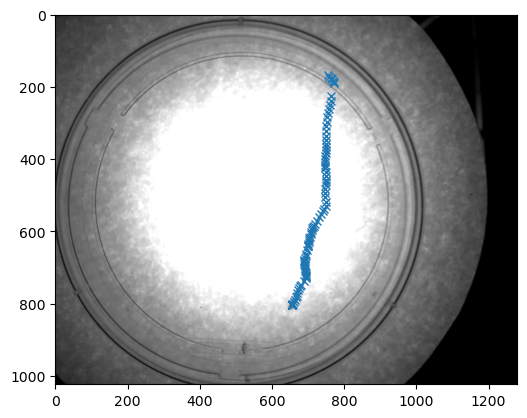

In [18]:
# Type your answer here
plt.imshow(frame0,cmap='gray');
plt.plot(xs,ys,'x');

Make a plot of the timeseries of the x and y values.

We want a plot that looks like the following. You need to fix the following code to do this:

```
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
axes[0].plot(time_values,x_values,'x')
axes[0].set_ylabel('x (px)')
axes[1].plot(time_values,y_values,'x')
axes[1].set_ylabel('y (px)')
axes[1].set_xlabel('time (frames)')
```

As a side note, the `sharedx` links the two panels together so they have the same X axis. When using matplotlib interactively (highly recommended!!!), panning and zooming in one panel also pans and zooms the other panel. This is incredibly useful.

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAoAAAAHgCAYAAAA10dzkAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90%0AbGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9h%0AAAAPYQGoP6dpAABcDUlEQVR4nO3dfXgU5b3/8c8mkPBgCBCEJBIJYKIVUBGoGD0FDQERqi0KCqhw%0AoIgVjBBQi9gCVgH1lCef4fALVMRYK1ptpYcEFfVEBCN6AE9JDI8KHBRiEgtNMJnfHzjj7GQ3CUn2%0AKft+XRdXndnZ2dkpl/vxe8/3vl2GYRgCAABA2IgI9AUAAADAvwiAAAAAYYYACAAAEGYIgAAAAGGG%0AAAgAABBmCIAAAABhhgAIAAAQZgiAAAAAYYYACAAAEGYIgAAAAGGGAAgAABBmCIAAAABhhgAIAAAQ%0AZgiAAAAAYYYACAAAEGYIgAAAAGGGAAgAABBmCIAAAABhhgAIAAAQZgiAAAAAYYYACAAAEGYIgAAA%0AAGGGAAgAABBmCIAAAABhhgAIAAAQZgiAAAAAYYYACAAAEGYIgAAAAGGGAAgAABBmCIAAAABhhgAI%0AAAAQZgiAAAAAYYYACAAAEGYIgAAAAGGGAAgAABBmCIAAAABhhgAIAAAQZgiAAAAAYYYACAAAEGYI%0AgAAAAGGGAAgAABBmCIAAAABhhgAIAAAQZgiAAAAAYYYACAAAEGYIgAAAAGGGAAgAABBmCIAAAABh%0AhgAIAAAQZgiAAAAAYYYACAAAEGYIgAAAAGGGAAgAABBmCIAAAABhhgAIAAAQZgiAAAAAYaZFoC+g%0AIZKTk3XgwIEa+++++249/fTTcrlcHt/3+OOP67777pMkDR48WFu2bHF7/ZZbblFOTk69r6O6ulqH%0ADx9WTEyM188EAADBxTAMlZeXKzExURER4VkLC8kAuH37dlVVVVnbu3btUkZGhkaPHi1JOnLkiNvx%0AGzdu1OTJk3XTTTe57Z8yZYoefvhha7t169ZndR2HDx9WUlLS2V4+AAAIAocOHVLXrl0DfRkBEZIB%0A8Nxzz3XbXrx4sXr27KlBgwZJkuLj491e/8tf/qJrrrlGPXr0cNvfpk2bGseejZiYGEln/gK1a9eu%0AwecBAAD+U1ZWpqSkJOt3PByFZAC0q6ys1Lp165SVleVxGPb//u//9Le//U1r166t8dqLL76odevW%0AqUuXLho+fLjmzZtX61+GiooKVVRUWNvl5eWSpHbt2hEAAQAIMeH8+FbIB8DXX39d3377rSZOnOjx%0A9bVr1yomJkajRo1y2z9+/Hh1795d8fHx2rVrl+bMmaPPPvtMubm5Xj9r0aJFWrBgQVNePgAAIWdp%0AbqEiI1zKTE+p8dqKzUWqqjY0MyM1AFeG+nIZhmEE+iIaY9iwYYqKitKbb77p8fWLLrpIGRkZevLJ%0AJ2s9T0FBgfr376+CggJdfvnlHo9xVgDNEnJpaSkVQABAs+UMfCs2F2lJbqGyfgh5ZuCz7/cUDoNF%0AWVmZYmNjw/r3O6QrgAcOHFBeXp42bNjg8fX3339fe/bs0csvv1znuS6//HK1bNlSRUVFXgNgdHS0%0AoqOjG3XNAACEmsgIl5bkFkqSMtNTrHBn7ssKofCHM0I6AGZnZ6tz584aMWKEx9dXr16tfv366dJL%0AL63zXLt379bp06eVkJDQ1JcJAEBIcwY+Z8B76u0vVFlVrbSecQwLh4iQnfymurpa2dnZmjBhglq0%0AqJljy8rK9Morr+hXv/pVjdeKi4v18MMP6+OPP9b+/fv11ltvafTo0erbt6+uuuoqf1w+AAAhJTM9%0ARVkZqVqSW6jUuRutal9UZIQqq6oV6XIpv/i4VmwucnufWRmMjAjfhotgFLIBMC8vTwcPHtSkSZM8%0Avp6TkyPDMDR27Ngar0VFRWnz5s0aNmyYLrzwQmVmZmro0KHKy8tTZGSkry8dAICQlJmeYgW+qMgz%0AEcL85yrDUFrPOC3JLbRCIMPCwSvkm0ACiYdIAQDhxAx0ZgiUZIU787W0nnHKLz6uCJdUbchj+Av0%0AkDC/3yFcAQQAAP5jr+ZNv/aCGq+bQ8T5xccV6XKp2kt5iSHh4EAABAAAtXIO5VZVG8rKSLWeCTSH%0AfDPTU5TWM05VhmENETMkHJxCugsYAAD4nhn4zNDmHLqt+qHct2JzkfKLj9cYFl6SW2h1ChP+ggPP%0AADYCzxAAAEKJL1fw8FbdM/dLUlRkhAofHd6wi29C/H4zBAwAQNgwJ3T2xVQtziphjc92uVRZVa1x%0Aq7Z6fH3F5iIt/SEowvcIgAAAhAn7XH5N/VzeTC/dvua5ixddb3UIO0MgjSH+xxBwI1BCBgAEM29D%0AvlbgcrlUZdReuWsob8Fy3Kqtyi8+rrSecVo/ZWBAGkP4/aYJBACAZsFT2DOHfLfuPa4ByR1rNm/8%0A0K3ri+DlbUh4/ZSBVghMnbuRxpAAYQgYAIBmwNPzfea0LPnFx7V9/wlJNZsyKquqazwT2BQ8DQmb%0A1k8Z6LaiCOHP/6gAAgDQDJghygx35jQs5nCrveIm1VzBw34OX1uxucgKf2YAJQT6FwEQAIAQ5GnI%0A1x4Cl+cVuT3f5yn8Od9j3/YV5zN/gQigIAACABCSzCFfyXNwsj/fZ1bczPV5ncz3V3lbv62JOMOf%0AGWLNzmT7tQR6veDmjgAIAEAI8jbk63y+z2y4qKvi5o/qm7MxxAyx5rJy9hVFzP3wDQIgAAAhyh4C%0AzaXWpB+HeO1TrgRqyNfOWc2zX0tWRqpmZqSyXrCfEAABAAhytS3hJv24yobk/nzfgOSOkqT84uNu%0AjRb+GvKtD08hlvDnewRAAACCnLfn/ezDuZ6e7zMrbubzdHbBFLAy01Os8Me0MP5BAAQAIMjV9bxf%0AMDzf1xhMC+N/BEAAAEJAXc/7OY+xbwcz+zN/VdWGtu8/4bXaSVdw02ElEAAAgsxSx4oepsz0FOt5%0AvwiXPD4rl5me4tZRG8ycDR+RES6racW+qom1dnGEK8BX3HxQAQQAIMh4e+Zv3KqtqjIMRbpcqjK8%0AB7xQqPxJNaeFsVcw03rGqaraoCvYRwiAAAAEUF0reuQXf6OcO690m9Jl/ZSBzWIFDU/Dufbv/vH+%0AErqCfYQACACAHzkDn73aJ6nGc25b955QzzlvqcowrPAnhebzfvVFV7DvheQzgMnJyXK5XDX+TJs2%0ATZI0ceLEGq8NHDjQ7RwVFRW655571KlTJ7Vt21Y33HCDvvzyy0B8HQAIaZ6eVzP3rdhcpKW5hW7H%0AmPtMzu3mzgx85v0wn9lbkltoPedmH/aMioywhn3N8GcKpef9zoanrmA0rZCsAG7fvl1VVVXW9q5d%0Au5SRkaHRo0db+6677jplZ2db21FRUW7nmDFjht58803l5OQoLi5Os2bN0siRI1VQUKDIyEjffwkA%0A8LPaJhNuTIelp+fV7PvM5byW5BZq697j1rJk5ucG65Jfzvtl33beL/s8e857vNTWvGB/j3k/BiR3%0AdGtusE+GLKnO6VGaW3XM+cxfcxjqDkYhGQDPPfdct+3FixerZ8+eGjRokLUvOjpa8fHxHt9fWlqq%0A1atX64UXXtCQIUMkSevWrVNSUpLy8vI0bNgw3108APiBp7BnhjIzdMxsYAhznts+FOkp0JjHmOHP%0AXJbs1pUfauveEx6f7/L1lB/1CXfO+2XfNkPs0txCbd9/wi3UOodzPYVh+/34aO8JVRlnmiHsw57m%0AucIpCHlq+GjOQ92BFJIB0K6yslLr1q1TVlaWXK4f/4Xz7rvvqnPnzmrfvr0GDRqkRx99VJ07d5Yk%0AFRQU6PTp0xo6dKh1fGJionr37q38/HyvAbCiokIVFRXWdllZmY++FQA0jqeqnD10mOrqsKxvkPQW%0AaCT3eevSesYpv/i4UudutOaxc36W+R57ID2bQNhU4c55v9ZPGVgjxHpaa9e8fkleQ/WKzUXKLz5u%0AdfOagc9e7QvHIOTsCjYF09J1zUXIB8DXX39d3377rSZOnGjtGz58uEaPHq1u3bpp3759+u1vf6tr%0Ar71WBQUFio6O1tGjRxUVFaUOHTq4natLly46evSo189atGiRFixY4KuvAgBNxtvKEWZYyS8+rh5z%0A/qZqw/Nccs6gZD+ntyDpDDTm8faq1vopA63wFxUZoenXXmCd31kpM99vD6n+DHfO+2Vet7dtT8Oz%0AzuFcT2HYU+Azq6Pe/n9trkGotoDfHANvIIV8AFy9erWGDx+uxMREa98tt9xi/XPv3r3Vv39/devW%0ATX/72980atQor+cyDMOtiug0Z84cZWVlWdtlZWVKSkpq5DcAAN/wtHKEGTA8VeAk1RjS9Da8W1sw%0Acj64b69qjVu11W1bktUAYVbBarsWMwz6K9w575enEGufksV+nz11sZr7Il0ur8PGkpRz55Uhu6wb%0AQkNIB8ADBw4oLy9PGzZsqPW4hIQEdevWTUVFZ/5lFB8fr8rKSpWUlLhVAY8dO6a0tDSv54mOjlZ0%0AdHTTXDwA+IGn6TScHZb2kGEGLvuQprfhXXswsgcab+vUepvHzux0dVYFzWqit2uRfB/uPN0vZ4g1%0AK3/O5/c8dbGa98r+vZbahrvt/18092ofAiukA2B2drY6d+6sESNG1Hrc8ePHdejQISUkJEiS+vXr%0Ap5YtWyo3N1djxoyRJB05ckS7du3S448/7vPrBoCm5q3D1wwv5vJhZghzBjVPQ5NmsPE2vGs/tzOo%0AOTlDmX241Aw99qqg+c9msHRei7/CnfN+eQuxW/ce9/r8njMMm+vdmt/LOexpD3xU++ArIRsAq6ur%0AlZ2drQkTJqhFix+/xnfffaf58+frpptuUkJCgvbv368HH3xQnTp10i9/+UtJUmxsrCZPnqxZs2Yp%0ALi5OHTt21OzZs9WnTx+rKxgAQomnZ/XswePeITW7cO3HLsktrHVI0zm8aw9GzkCTmZ5iPcwv/Rho%0A7IHIWdUa2KNjjWFP87PMdWG9DWP7Ktw5Gzy8hVj7fR3YI67GcK6Ts/va/v8DgQ/+ErIBMC8vTwcP%0AHtSkSZPc9kdGRmrnzp364x//qG+//VYJCQm65ppr9PLLLysmJsY6bunSpWrRooXGjBmjU6dOKT09%0AXWvWrGEOQAAhyVlNs/+zGXDM0OWtYcGsEjqHNJ3Du946X+2Bpj4P89fVgTz92gus72Femz/D3YDk%0Ajm73y96ham7b3zcguaNb8DXvhacwbL8PDPEiEFyGUctq0qhVWVmZYmNjVVpaqnbt2gX6cgDAClUR%0ALtXZ4TszI9XrpLtmELIP75qrUHhrFHGeuy7OYWvnfITmecywZr+W+oY7ezXT/j571dLcrmuSZ0/f%0AyVeTa8O3+P0mADYKf4EABEJdoWN5XpH1rF7ho8O9nsdbBc4eoAYkd2ySsNfQ72UPb/Zr8Ue4Q/PF%0A73cIDwEDQLjy9LyfJI/Pz3ka6jV5mnTXOaTpz+fVnCHMU0A11wyubVi2tnDnbYJhINwQAAEgxHib%0A5Nn5zF9dS4d5qnoF00oMnq6FcAc0DYaAG4ESMoBAMgOec1JlT1VBb40WQDji95sKIACELHunboRL%0AmjEkOCp3AIIfARAAQpRzKhRvqPwBcCIAAkCQq093rLfGEADwhAAIAEHOGe6cU58M7BHnsTEEALwh%0AAAJAkHOGu6rqmpMh24/jeT8AdSEAAkAIsIdA85m/2qZrAYDaRAT6AgAA9ZOZnmKFP3NNXABoCAIg%0AAIQIZ9fvis1Fgb4kACGKIWAACAHOCZ3rWuUDAGpDAASAIOdpNQ+6fgE0BkPAABBEluYW1hjaNdfE%0ANV83ZaanKCsjla5fAGeNAAgAQcSc888eAmf+EP6W/DAhtF1meor1OgDUF0PAABBEPA3tehoCBoDG%0AIAACQJCxh8Cn3v7C65x/ANBQDAEDQBBizj8AvkQABIAgxJx/AHyJIWAACDLM+QfA1wiAABBEmPMP%0AgD/4bQi4oqJC77//vl544QU9//zz2rBhg/bt29egcyUnJ8vlctX4M23aNJ0+fVoPPPCA+vTpo7Zt%0A2yoxMVF33HGHDh8+7HaOwYMH13j/rbfe2hRfFQAazJzzzxnymPMPQFNyGYbh03+b5Ofn68knn9Tr%0Ar7+uyspKtW/fXq1bt9aJEydUUVGhHj166M4779Rdd92lmJiYep3z66+/VlVVlbW9a9cuZWRk6J13%0A3lHfvn118803a8qUKbr00ktVUlKiGTNm6Pvvv9fHH39svWfw4MFKTU3Vww8/bO1r3bq1YmNj6/3d%0AysrKFBsbq9LSUrVr167e7wMAAIHD77ePh4BvvPFGbd++XePGjdN//dd/qX///mrTpo31+t69e/X+%0A++/rpZde0pIlS/THP/5RGRkZdZ733HPPddtevHixevbsqUGDBsnlcik3N9ft9SeffFI//elPdfDg%0AQZ1//vnW/jZt2ig+Pr6R3xIAGm7pD5M7exrWXbG5SFXVBhM9A2hyPh0CHjp0qPbv36//+I//0M9+%0A9jO38CdJPXr00IQJE/T3v/9deXl5DfqMyspKrVu3TpMmTZLL5fJ4TGlpqVwul9q3b++2/8UXX1Sn%0ATp3Uq1cvzZ49W+Xl5bV+VkVFhcrKytz+AEBjeFr5Q/rxWUDnyh8A0BR8PgTsa3/60580btw4HTx4%0AUImJiTVe/9e//qWrr75aF110kdatW2ftX7Vqlbp37674+Hjt2rVLc+bM0QUXXFCjemg3f/58LViw%0AoMb+cC4hA2g8b12/TP4M+AZDwH4MgHl5eRoyZIjH155//nlNnTq1QecdNmyYoqKi9Oabb9Z47fTp%0A0xo9erQOHjyod999t9b/kwsKCtS/f38VFBTo8ssv93hMRUWFKioqrO2ysjIlJSWF9V8gAE3DDH3m%0AvH+EP8B3CIB+7AIeMWKEZs2apcrKSmvf119/rZ///OeaM2dOg8554MAB5eXl6Ve/+lWN106fPq0x%0AY8Zo3759ys3NrfP/4Msvv1wtW7ZUUZH3yVajo6PVrl07tz8A0BRY+QOAP/ktAL733nt68803NWDA%0AAO3evVt/+9vf1Lt3b3333Xf67LPPGnTO7Oxsde7cWSNGjHDbb4a/oqIi5eXlKS4urs5z7d69W6dP%0An1ZCQkKDrgUAGoOVPwD4k98mgr7iiiu0Y8cO3XXXXerXr5+qq6v1yCOP6L777vPavFGb6upqZWdn%0Aa8KECWrR4sev8f333+vmm2/WJ598or/+9a+qqqrS0aNHJUkdO3ZUVFSUiouL9eKLL+r6669Xp06d%0A9Pnnn2vWrFnq27evrrrqqib7zgBQH6z8AcDf/LoSyJ49e7R9+3Z17dpVhw8f1j/+8Q+dPHlSbdu2%0APetz5eXl6eDBg5o0aZLb/i+//FJvvPGGJOmyyy5ze+2dd97R4MGDFRUVpc2bN2v58uX67rvvlJSU%0ApBEjRmjevHmKjIxs8PcDgLPFyh8AAsFvTSCLFy/WvHnzdOedd+qJJ55QcXGxbrvtNpWVlWndunW6%0A8sor/XEZTYqHSAGcLee8f/Zt57x/zAMI+Aa/336sAC5fvlyvv/66hg8fLknq1auXtm3bpgcffFCD%0ABw92664FgObKnPdPOlPZs4c9sxJoovIHwFf8FgB37typTp06ue1r2bKlnnjiCY0cOdJflwEAAeVp%0AeJd5/wD4W0Amgj506JBcLpe6du3q749uUpSQAdSmtmXexq3aqvzi48z7BwQAv99+nAbm+++/129/%0A+1vFxsYqOTlZ3bp1U2xsrB566CGdPn3aX5cBAH5T2zJv+cXHFelyMe8fgIDw2xDw9OnT9dprr+nx%0Axx+3Gj4+/PBDzZ8/X998842ee+45f10KAPhFbcO9aT3j3CqAKzYXEQIB+I3fhoBjY2OVk5NjNYGY%0ANm7cqFtvvVWlpaX+uIwmRQkZgJ23IV8z9EW6XKoyDCv8sfYvEBj8fvuxAtiqVSslJyfX2J+cnKyo%0AqCh/XQYANAlPYc8c8t2697gGJHesMX1LlWEo0uVyC38S8/4B8D+/BcBp06bp97//vbKzsxUdHS1J%0Aqqio0KOPPqrp06f76zIAoEk4p3Mx/3fr3uPKLz5uHWdf1cMc7k3rGVcj5JnbVdV+78sDEIb8NgT8%0Ay1/+Ups3b1Z0dLQuvfRSSdJnn32myspKpaenux27YcMGf1xSo1FCBsKHp4qf/Xm+AckdrVDofL5P%0AEsO9QBDh99uPFcD27dvrpptuctuXlJTkr48HgEapq+L30d4TqjIMK9ilzt1YI/zZ38twL4BA8lsA%0AzM7O9tdHAUCT89bRa07nUmUY1nQuKzYXqbKqWhEuydOILsO9AAItIBNBNxeUkIHm6WwmcHYO99Lh%0ACwQ/fr99PBH0ddddp/z8/DqPKy8v12OPPaann37al5cDAPVS3wmc7R29hY8Ot8KfvckjMz1FWRmp%0AHs8HAIHi0yHg0aNHa8yYMYqJidENN9yg/v37KzExUa1atVJJSYk+//xzffDBB3rrrbc0cuRIPfHE%0AE768HADwyFnxsw/3mlO6OBs87HP6mccPSO4oScovPu42sTNDvgCCjc+HgCsrK/XnP/9ZL7/8st5/%0A/319++23Zz7Y5dLFF1+sYcOGacqUKbrwwgt9eRk+QQkZaB68DdOaw72eJnCuqja0ff+JGnP6meer%0AqjZqzAMIIDjw++2HJpCoqCiNGzdO48aNkySVlpbq1KlTiouLU8uWLX398QBQp/o0eHiawFlyn+fP%0AWfEDgGDlty5gU2xsrGJjY/39sQAgyXuDhzmly5LcQj319hdeGzyYwBlAc+D3AAgA/uQMfPb5/CRZ%0AQ7W1NXjYu3ntz/aZqPgBCDUEQADNxtmsz2uGwKwfwl9dDR5M4AygOSEAAmg26rs+r51zuNfZ4EE3%0AL4DmiAAIIGTVd/oWc26+/OLj1hJtWRmpVvijwQNAuPHpRNB2eXl5Xl97/vnn/XUZAELUUg8TKZsV%0Av3GrtmqpLaiZYe+pt7+wpndZP2Wg1cwRFXnmX33mPzuHe03mJM5U/AA0N34LgCNGjNCsWbNUWVlp%0A7fv666/185//XHPmzDmrcyUnJ8vlctX4M23aNEmSYRiaP3++EhMT1bp1aw0ePFi7d+92O0dFRYXu%0AuecederUSW3bttUNN9ygL7/8svFfFIBPeFqdwx72tu8/IUl1rs9rhkAzGBY+OlxZGanWcK9TZnoK%0A8/kBaHb8NgT83nvv6fbbb1deXp7Wr1+v/fv3a9KkSbr44ov12WefndW5tm/frqqqKmt7165dysjI%0A0OjRoyVJjz/+uJYsWaI1a9YoNTVVjzzyiDIyMrRnzx7FxMRIkmbMmKE333xTOTk5iouL06xZszRy%0A5EgVFBQoMjKy6b44gBo8NWuY+6Qfn7EzjzEnVjaXVKtreNc5fYs5oXOWowHERIMHgHDjtwB4xRVX%0AaMeOHbrrrrvUr18/VVdX65FHHtF9990nl8t1Vuc699xz3bYXL16snj17atCgQTIMQ8uWLdPcuXM1%0AatQoSdLatWvVpUsXrV+/XlOnTlVpaalWr16tF154QUOGDJEkrVu3TklJScrLy9OwYcOa5ksD8MhT%0As4Z9nz2omQ0c5vN55vZHe0+oyjCs/Wb4cz7PZ4Y/c4h36Q+VP/P85jXQ4AEgnPi1CWTPnj3avn27%0AunbtqsOHD+sf//iHTp48qbZt2zb4nJWVlVq3bp2ysrLkcrm0d+9eHT16VEOHDrWOiY6O1qBBg5Sf%0An6+pU6eqoKBAp0+fdjsmMTFRvXv3Vn5+vtcAWFFRoYqKCmu7rKyswdcNhLP6VNzsYc8Mb3UN79Zn%0AfV7ncK498FH5AxAu/BYAFy9erHnz5unOO+/UE088oeLiYt1222265JJLtG7dOl155ZUNOu/rr7+u%0Ab7/9VhMnTpQkHT16VJLUpUsXt+O6dOmiAwcOWMdERUWpQ4cONY4x3+/JokWLtGDBggZdJxDOPA35%0A2kPg8rwiq5pn7nNOz1Kf4V1P07eYgc8cRrYj8AEIV34LgMuXL9frr7+u4cOHS5J69eqlbdu26cEH%0AH9TgwYPdKmtnY/Xq1Ro+fLgSExPd9juHlQ3DqHOoua5j5syZo6ysLGu7rKxMSUlJDbhqILx4GvK1%0As1fzpB/n5ouKjND6KQPrPbxrYvoWAKid3wLgzp071alTJ7d9LVu21BNPPKGRI0c26JwHDhxQXl6e%0ANmzYYO2Lj4+XdKbKl5CQYO0/duyYVRWMj49XZWWlSkpK3KqAx44dU1pamtfPi46OVnR0dIOuFc2L%0At/VkpR8rTeHaOVpXtS+/+Bvl3HmlW0gzq3lmF669W3fcqq31Ht5lwmYAqB+/BUBn+LMbNGhQg86Z%0AnZ2tzp07a8SIEda+7t27Kz4+Xrm5uerbt6+kM88JbtmyRY899pgkqV+/fmrZsqVyc3M1ZswYSdKR%0AI0e0a9cuPf744w26FoQXZ0XL3sG6xNZkIIVfIKyr2rd17wmroiepxlq79n32Ct+A5I4M7wJAEwnZ%0AlUCqq6uVnZ2tCRMmqEWLH7+Gy+XSjBkztHDhQqWkpCglJUULFy5UmzZtNG7cOElSbGysJk+erFmz%0AZikuLk4dO3bU7Nmz1adPH6srGKiNs4nB2cFqhkIzsGRlpLpVxpyhsDmFRE8NHma4s6++IanGyht2%0AZsOH+czfwB5xWj9lIMO7ANAEQjYA5uXl6eDBg5o0aVKN1+6//36dOnVKd999t0pKSnTFFVdo06ZN%0A1hyAkrR06VK1aNFCY8aM0alTp5Senq41a9YwByBq8Dbca3apLskttFaWsDPDn72D1TmtiSS3cBSK%0AzrbBo7KqWhEuyTk6a87zZ/6z5F4dNPcxvAsAjecyDIN/izZQWVmZYmNjVVpaqnbt2gX6cuAj9oDm%0AqdHAPiXJ9GsvsAKhvWPV05Dm+ikDdevKD7V17wmPlbAVm4v03198o6su6BTUzxrWdX8kud0b55Bv%0AbVVAAPAFfr9DuAII+EttQ5rOKUkkua03ax+y9DatiZ3zWcK0nnFuq1aYVS/70LJdIEJhbfdHUo2l%0A15zDtqy+AQD+RwAE6sEeVpxBzlMTg72rNTM9xeu0JvbKmOT5WUJnc4RzcmR/NqDUZzjc0zN+ZqXT%0A231lOBcA/IsACNSTPcg556Nzmn7tBZJ+XMrM07Qm9qqhucatp2cJ7Zzhc8XmIr82oHjr8LWv0OGp%0AwcM57Yun5wUBAP5DAATqyVxuzP58nxlenI0cZqCyV+vWTxlY4xlA+/vsQ8dmVdAMfPbuWefQckMb%0AUOoTEiVZ1UV7SDTPNSC5oxUKzVDqqcFDotoHAMGEAAjUg7Nhwdw2h3jNDlZPVTFzDjvntCb2iYud%0AQ8f2fzYDnj18ehpadoZG5+c4h46dq2h461K2Vxcl9zV6P9p7wpqc2dtwONU+AAg+BEDAwfmcm7O6%0AtzS30K0SJsnj8KkzFC51BEhnJWxgj45eV8jwFD6dQ8v24+vbgFJXSDRX5rCzD/dWGYbH4XAaPAAg%0AuBEAAQfnc272+ensQbCuIU1nKLRvewqXnkJS/+QOyi8+7rbPGdSckyOfTQNKfUKi/bs7j/E0HO78%0Ajgz5AkDwIQACDs7q1cyMVK9BrbGVLWeV0Flt/O8vvqkxFCvJbWjZ6WwaUOoTEs1r89YA4xwO93Qv%0AAQDBhQAIeOBp2hdfTFjsrBI6A6Hz85wrZEiNb0CpT0iUZIU/85k/hnsBIHQRAAEvnJUxfwSb2qZi%0A8fb5jWlAqW9IlM6Ezqpqw+octlf8GO4FgNBCAAS8cE774mmIMxg0tAGlPiHR22d56vINxnsDAPCM%0AtYAbgbUEmy9v0740p3Vrnd3OZzMPoBQ8axEDwNni95sA2Cj8BWqevIW95hgCASAc8fvNEDBQg6dn%0A6iSecwMANB9UABuB/4IIfc5hUDuGOAGgeeL3W6p95XmgmTMnfXY2PJjDvebzbwAANCcMASOseZrD%0Ajmf9AADNHQEQYc9fkz4DABAsGAIGdCYEmvP9+WvSZwAAAoUACMjzpM8AADRXDAEjrHjq+jWf+TNX%0AxDAbQyRWtwAANE8EQIQVZ7izh7/84uMa2CPOY2MIAADNScgOAX/11Ve67bbbFBcXpzZt2uiyyy5T%0AQUGB9brL5fL454knnrCOGTx4cI3Xb7311kB8HfhJZnqKsjJSralfqqoNK/zZGz/M45j0GQDQHIVk%0ABbCkpERXXXWVrrnmGm3cuFGdO3dWcXGx2rdvbx1z5MgRt/ds3LhRkydP1k033eS2f8qUKXr44Yet%0A7datW/v02uE/3iZ5zkxP0da9x7Ukt9B65q+2lT8AAGhuQjIAPvbYY0pKSlJ2dra1Lzk52e2Y+Ph4%0At+2//OUvuuaaa9SjRw+3/W3atKlxLJoHb8/yrdhcpPzi44p0uej6BQCEpZAcAn7jjTfUv39/jR49%0AWp07d1bfvn21atUqr8f/3//9n/72t79p8uTJNV578cUX1alTJ/Xq1UuzZ89WeXm51/NUVFSorKzM%0A7Q+Cl3O4V3Jv+KgyDLp+AQBhKSQrgHv37tWzzz6rrKwsPfjgg9q2bZsyMzMVHR2tO+64o8bxa9eu%0AVUxMjEaNGuW2f/z48erevbvi4+O1a9cuzZkzR5999plyc3M9fu6iRYu0YMECn3wnNJ6nIV97Q8fy%0AvCJVGTWf+TNDof14AACaM5dhGCH3lHtUVJT69++v/Px8a19mZqa2b9+uDz/8sMbxF110kTIyMvTk%0Ak0/Wet6CggL1799fBQUFuvzyy2u8XlFRoYqKCmu7rKxMSUlJYb2YdDDxtoSbPeBFulyqMgyvx7AC%0ACAA0f2VlZYqNjQ3r3++QrAAmJCTo4osvdtv3k5/8RK+++mqNY99//33t2bNHL7/8cp3nvfzyy9Wy%0AZUsVFRV5DIDR0dGKjo5u+IXDp2pb11eSNdyb1jPOa8MHXb8AgHAQkgHwqquu0p49e9z2FRYWqlu3%0AbjWOXb16tfr166dLL720zvPu3r1bp0+fVkJCQpNdK3yjPh2+5rq+kmoM967YXETXLwAgbIVkAJw5%0Ac6bS0tK0cOFCjRkzRtu2bdPKlSu1cuVKt+PKysr0yiuv6A9/+EONcxQXF+vFF1/U9ddfr06dOunz%0Azz/XrFmz1LdvX1111VX++ipooPp2+EqqMb+fxCTPAIDwFpIBcMCAAXrttdc0Z84cPfzww+revbuW%0ALVum8ePHux2Xk5MjwzA0duzYGueIiorS5s2btXz5cn333XdKSkrSiBEjNG/ePEVGRvrrq6CenBU/%0Ae5Dbuve42xJuZpNHhEvyNKLLcC8AINyFZBNIsOAhUv/x1qQxbtVWq+JXW4cvzR0AABO/3yFaAUTz%0AV9+Knz38RbpcHpd0M99n3wYAIJwRABGUPD3jZzZ45Bcf10d7T7hV/OjwBQCg/giACErepnSpreJH%0Ahy8AAPVDAETQsodAc0oXs+Jnf+aP4V4AAM4OARAB521OP5M5pYu94ldVbWj7/hPKLz7uVvFjuBcA%0AgLoRABFwtc3p51zCzfmMn6d1fKn8AQBQOwIgAq6uJdyo+AEA0LQIgAgKnp73k1Rj/j4qfgAANB4B%0AEEEjMz3FCn8RLmnGkJqTN1PxAwCg8QiA8DtvTR8rNhdZzR5VtSxQQ8UPAIDGIQDC7zw1fdiHdu8d%0AwnQuAAD4EgEQfuds+rD/s/OZP0IgAABNjwAIn/I23Gsu67Ykt1ARrjP7nOGP5/0AAPANAiB8qrY5%0A/uwrekRFRnis8lH5AwCg6REAg4izWmbfXrG5SP/9xTe66oJO1rZZGYv8oYRm3w6WY2ZmpEo6M5S7%0Ade9xDUjuaIVCc1m3qMgIVVZVe1zDFwAAND0CYBBxVsvM7a17jyu/+LjSesa5bWfZwpUkt+1gOsYc%0A7s0vPq6P9p6wVvQw3+Oc+JkQCACAb0UE+gLwo8z0FGVlpGpJbqFVDTODUlrPOK2fMtBt29uQaTAd%0AI9Uc7rWv6WufzNn+3QEAgO+4DKOWCddQq7KyMsXGxqq0tFTt2rVrsvOa1TBzaNQ5VOrctlfeQuUY%0AM9B6+u72oWMAAJqar36/QwkVwCCUmZ5iBaWoyAitnzKw1u3M9JQ63xPIY+wVv8JHhysrI9Va09fT%0Adyf8AQDgWzwDGITMFTHMADVu1dZat80gFYzHmMO+9iFi5zyAPPMHAIB/EQCDjDn8az4fN27VVrdn%0AAJ3b9uYJb+8J5DFV1Ya27z9hVfycIZA5/gAA8D8CYBBxhj+zecJ8fs4etrwNoTrfE+hjzOFcT12+%0AVP4AAAgMmkAaoakfIm3O8wBKNHgAAIIDTSAEwEbhLxAAAKGH32+6gAEAAMIOzwA2glk8LSsrC/CV%0AAACA+jJ/t8N5EJQA2Ajl5eWSpKSkpABfCQAAOFvl5eWKjY0N9GUEBM8ANkJ1dbUOHz6smJgYuVyu%0AJj13WVmZkpKSdOjQobB9PsHXuMe+xz32Pe6xf3Cffc+f99gwDJWXlysxMVEREeH5NBwVwEaIiIhQ%0A165dffoZ7dq14182PsY99j3use9xj/2D++x7/rrH4Vr5M4Vn7AUAAAhjBEAAAIAwQwAMUtHR0Zo3%0Ab56io6MDfSnNFvfY97jHvsc99g/us+9xj/2LJhAAAIAwQwUQAAAgzBAAAQAAwgwBEAAAIMwQAAEA%0AAMIMARAAACDMEAABAADCDAEQAAAgzBAAAQAAwgwBEAAAIMwQAAEAAMIMARAAACDMEAABAADCDAEQ%0AAAAgzBAAAQAAwgwBEAAAIMwQAAEAAMIMARAAACDMEAABAADCDAEQAAAgzBAAAQAAwgwBEAAAIMwQ%0AAAEAAMIMARAAACDMEAABAADCDAEQAAAgzLQI9AWEsurqah0+fFgxMTFyuVyBvhwAAFAPhmGovLxc%0AiYmJiogIz1oYAbARDh8+rKSkpEBfBgAAaIBDhw6pa9eugb6MgCAANkJMTIykM3+B2rVrF+CrAQAA%0A9VFWVqakpCTrdzwcEQAbwRz2bdeuHQEQAIAQE86Pb4XnwDcAAEAYC8kK4Pfff6/58+frxRdf1NGj%0AR5WQkKCJEyfqoYcesh7mNAxDCxYs0MqVK1VSUqIrrrhCTz/9tHr16mWdp6KiQrNnz9ZLL72kU6dO%0AKT09Xc8880zAngdYmluoyAiXMtNTamyv2Fyk//7iG111QSdru6rakCRFRpz5Lxj7drAcMzMj1fp+%0A5jH2fQAAwP9CMgA+9thjeu6557R27Vr16tVLH3/8sf793/9dsbGxuvfeeyVJjz/+uJYsWaI1a9Yo%0ANTVVjzzyiDIyMrRnzx5rzH/GjBl68803lZOTo7i4OM2aNUsjR45UQUGBIiMj/f69IiNcWpJbKEnK%0ATE+xtrfuPa784uNK6xnntp31Q5Ay32PfDpZjzBBr7s8iEAIAEHAhOQT84Ycf6sYbb9SIESOUnJys%0Am2++WUOHDtXHH38s6Uz1b9myZZo7d65GjRql3r17a+3atTp58qTWr18vSSotLdXq1av1hz/8QUOG%0ADFHfvn21bt067dy5U3l5eQH5XpnpKcrKSNWS3EKt2FykzPQUpfWMs8Lf+ikD3bbNSqHzHMF0jBli%0AzfCXmZ6ipbmFGrdqq5bYwqFpxeYiLf0hQAIAAN9wGYZhBPoiztbixYv13HPPadOmTUpNTdVnn32m%0AoUOHatmyZRo7dqz27t2rnj176pNPPlHfvn2t9914441q37691q5dq7ffflvp6ek6ceKEOnToYB1z%0A6aWX6he/+IUWLFhQ53WUlZUpNjZWpaWlTdoEsmJzkZbkFioqMkKVVdVWyPK2ba+8BesxkqwAOG7V%0AVrdQ66lKaIZJqoQAgKbmq9/vUBKSFcAHHnhAY8eO1UUXXaSWLVuqb9++mjFjhsaOHStJOnr0qCSp%0AS5cubu/r0qWL9drRo0cVFRXlFv6cxzhVVFSorKzM7Y8vZKanWMEpKjJC66cMrHU7Mz2lzvcE+hiz%0Aspk6d6MV/vKLj2vF5iKPVULpxyDsrBICAIDGCclnAF9++WWtW7dO69evV69evfTpp59qxowZSkxM%0A1IQJE6zjnO3dhmHU2fJd2zGLFi2qV2WwsVZsLrKCU2VVtcat2lrr9orNRZIU1MdIqhEa7ZVOp1tX%0Afqite0+4BUL7/aEqCABAw4VkALzvvvv0m9/8RrfeeqskqU+fPjpw4IAWLVqkCRMmKD4+XpKsDmHT%0AsWPHrKpgfHy8KisrVVJS4lYFPHbsmNLS0jx+7pw5c5SVlWVtmxNJNiUzFHkbLnVum8dL3odYA32M%0AfZ89JGamp+ipt7+wQuH0ay/QktxCa58dzSQAADSdkBwCPnnyZI21+yIjI1VdfSY0dO/eXfHx8crN%0AzbVer6ys1JYtW6xw169fP7Vs2dLtmCNHjmjXrl1eA2B0dLQ16bMvJn92hr8Vm4vchkvtYcscPvV0%0AjmA6xmn6tRdYw8HOyqEkj8PGDBMDANC0QrIJZOLEicrLy9Pzzz+vXr16aceOHbrzzjs1adIkPfbY%0AY5LOTBWzaNEiZWdnKyUlRQsXLtS7777rNg3Mr3/9a/31r3/VmjVr1LFjR82ePVvHjx+v9zQwTf0Q%0AaXOcB9AMbmbFzqzU1VY5rE8zSVW1oe37T1jTz9iHiakIAgBqQxNIiAbA8vJy/fa3v9Vrr72mY8eO%0AKTExUWPHjtXvfvc7RUVFSfpxIujnn3/ebSLo3r17W+f517/+pfvuu0/r1693mwi6vsO6/AWqmzPU%0ASj9W7dJ6xmlAckfNzEitMXQs/TjU62mYONLlUpVhWAHSeW5Pzw4CACDx+y2FaAAMFvwFahhnKLSH%0ANunHKqG3qqAZCM0QaIY9GkcAAPXB73eINoEgtDlDWFW1UWvFbmCPjsq580qPgdBcHYXGEQAA6o8A%0AiIDzFMLqGsqdfu0FkmQNBzuHiCX3pfXsq5DYnx10fiahEAAQDgiACErOqqC3YWJzHWIzBEqyuoc9%0AzS9ohj9z6TqqhACAcEQARFCqzzCxfRqaAckd3TqO7dPJOOcX9LQKiaRaAycAAM0JARAhwRkIaxsi%0Adj4naP9nViEBACBEJ4IG6tM4UvjocGs42LlUXW1rFW/de8LjOZl0GgDQXFABREhqbOPI1r3Ha12F%0AxN5MwqTTAIDmhgCIZuNsG0dqW4VE+rGZxD7ptH2VFrqJAQChigCIZqMhjSNO9iqhvZkk0uWyGkcy%0A01PoJgYAhDQCIJotT4GrvlVCqWYziXPS6bq6iakSAgCCFQEQYaWxq5DYJ52uq5uYKiEAIFgRABHW%0A6ttMkpmeUmPSaXM42KwINmTOQaqEAIBAIAACDmcz6XRd3cRUCQEAwYgACDjUd9Lp+nQTN7ZKWFVt%0AaMXmIkkEQgBA0yEAAnVobDdxY6qEDBsDAHyBAAjUoTHdxI2tEjZ02Ni+zxkICYkAAAIg0ABNPedg%0AfVcmqW9ziT1oOgMhQ8kAAAIg0AR8XSW0/3N9mkucGEoGANgRAAEfaeoqoXR2zSVmqKMDGQDgRAAE%0A/KShVUIzlElnN2xsnpN5CgEATgRAIIDqqhI2trlEEvMUAgBqIAACQcQXw8aeGkOaap5CqoQAEJoI%0AgEAQa4phY0+aap5CqWaV0OS8LgBA8HAZhmEE+iJCVVlZmWJjY1VaWqp27doF+nIQpsxhWXv4cs4D%0AaFbunEPJ41ZtrXMo2QybqXM3epyn0F4lNFcvsVcEnaGQiiCAQOP3mwogEPI8hSnnvqUelrLz1Wom%0AkS6XqgyDiiAABDECIBAG/L2aSaTLZT03mJmeoltXfqite0/UCKHm51IVBAD/IgACYcrXq5mk9Yxz%0AaybxhKogAAQGARCAJN9UCSNdrhrPDUpy60r2VBUEAPgWARCAVw2tEmamp1ih0AyB0pmpY5bkFmpZ%0AXqGqDbmdy9m4IslqbnEOEzNsDACNQwAEUG/1qRJKNUOhvQvZ3khi55xjUPpxaDm/+LgG9uhoTW7N%0AJNQA0DgEQACN4gxdtQ3tOptH7EPCTvYqYlrPOA3sEVdjEmrn5wEA6ocACKBJeaoI2g3s0VE5d15p%0ABTd7o4i98udcieTj/SU1zkV3MQA0DAEQQJPyFLg8VQXN/12SW2g1ipj77EvTrZ8y0OMk1J66i1mr%0AGADqhwAIwOfqqgqajSLmM3726WTGrdpa6yTU9u5i1ioGgPohAALwufpUBe0TTJv76rNUnXl8fdcq%0ApkoIAARAAAFQnzkA7Z3E5qoidvZJqO3dxZ6Gie3n8FQldF4TADR3BEAAfudpSNjcZ/6zJLfqYH7x%0AN1bDh3nMTFvTiKR6rVXsqUpIMwmAcBOyAfCrr77SAw88oI0bN+rUqVNKTU3V6tWr1a9fP0mSYRha%0AsGCBVq5cqZKSEl1xxRV6+umn1atXL+scFRUVmj17tl566SWdOnVK6enpeuaZZ9S1a9dAfS0gLHgK%0AU7UFrMz0FFVVG0rr2ane3cWS97WKaSYBEO5CMgCWlJToqquu0jXXXKONGzeqc+fOKi4uVvv27a1j%0AHn/8cS1ZskRr1qxRamqqHnnkEWVkZGjPnj2KiYmRJM2YMUNvvvmmcnJyFBcXp1mzZmnkyJEqKChQ%0AZGRkgL4dAE/q211sV9taxdLZNZM4Pw8AQllIBsDHHntMSUlJys7OtvYlJydb/2wYhpYtW6a5c+dq%0A1KhRkqS1a9eqS5cuWr9+vaZOnarS0lKtXr1aL7zwgoYMGSJJWrdunZKSkpSXl6dhw4b59TsBOHuN%0AXatYqn8zCcPEAJqTkAyAb7zxhoYNG6bRo0dry5YtOu+883T33XdrypQpkqR9+/bp6NGjGjp0qPWe%0A6OhoDRo0SPn5+Zo6daoKCgp0+vRpt2MSExPVu3dv5efnEwCBENDQtYrtzqaZxM7TMLFzPeOZDB0D%0ACFIhGQD37t2rZ599VllZWXrwwQe1bds2ZWZmKjo6WnfccYeOHj0qSerSpYvb+7p06aIDBw5Iko4e%0APaqoqCh16NChxjHm+50qKipUUVFhbZeVlTXl1wLQSPVZq9hblVCqu5mkrmFi51Q2PEsIIFiFZACs%0Arq5W//79tXDhQklS3759tXv3bj377LO64447rONcLpfb+wzDqLHPqbZjFi1apAULFjTy6gH4U32q%0AhHa1NZNItQ8TOzExNYBgFZIBMCEhQRdffLHbvp/85Cd69dVXJUnx8fGSzlT5EhISrGOOHTtmVQXj%0A4+NVWVmpkpIStyrgsWPHlJaW5vFz58yZo6ysLGu7rKxMSUlJTfOlAPhFY5tJ6homtq9nXJ+JqT1d%0AAwD4Wt3/CRuErrrqKu3Zs8dtX2Fhobp16yZJ6t69u+Lj45Wbm2u9XllZqS1btljhrl+/fmrZsqXb%0AMUeOHNGuXbu8BsDo6Gi1a9fO7Q+A0FfbMHFWRqqqqg1lpqdY1b/auokz01OUmZ7its98X+rcjR4n%0At67PxNgA0JRCsgI4c+ZMpaWlaeHChRozZoy2bdumlStXauXKlZLODP3OmDFDCxcuVEpKilJSUrRw%0A4UK1adNG48aNkyTFxsZq8uTJmjVrluLi4tSxY0fNnj1bffr0sbqCAYSHphwm9rSesf1158TUy/IK%0AVW2I7mIAfhWSAXDAgAF67bXXNGfOHD388MPq3r27li1bpvHjx1vH3H///Tp16pTuvvtuayLoTZs2%0AWXMAStLSpUvVokULjRkzxpoIes2aNcwBCIS5xg4TS54bQ7xNTO0JQ8IAfMllGIYR6IsIVWVlZYqN%0AjVVpaSnDwUAzZ3b01tZNXJ/OYOlMSDSHgZ0NJlXVhluTiPM5QSqCQOPx+00AbBT+AgHhyxkI7fsk%0A90DonHJm3KqtXiemjnS5VGUY1msmnhMEmg6/3wTARuEvEIDaeAqJZpAzJ6Y2q3meQqAZ9liFBGha%0A/H6H6DOAABAK6jMxtZO9AuhtFRITzwkCaCi/BcCKigpt27ZN+/fv18mTJ3Xuueeqb9++6t69u78u%0AAQACrj4NJuZ2pMvlcRUSnhME0Fg+D4D5+fl68skn9frrr6uyslLt27dX69atdeLECVVUVKhHjx66%0A8847ddddd7l16AJAOPD0bF9meoq27j2u/OLjVgiUflyFxF4lNN/DCiMAzoZPJ4K+8cYbdfPNN+u8%0A887Tf/3Xf6m8vFzHjx/Xl19+qZMnT6qoqEgPPfSQNm/erNTUVLdJmQEgHHgaEl6xuchqEpl+7QVW%0A8JPOTCVTZRiKdLncJpOua4URszkFACQfN4E8/fTTmjJliqKiouo8dvfu3Tp8+LAyMjJ8dTlNjodI%0AATQ1b92+nuYTdE4lY247h5LpHAbc8ftNF3Cj8BcIQFPz1Dks/RgAnauQmMPBUZERKnx0uLU/wiVW%0AGAG84Pfbj2sB5+XleX3t+eef99dlAEBQm+klsJmVvJw7r5R05jnBtJ5x1nCwfYWRqMgIVXv5T3uG%0AhAFIfuwCHjFihKZPn65FixZZQ8Jff/21Jk2apP/+7//W1KlT/XUpABBS6npOcEByR2vS6a17j7ut%0AQ2wOGzOfIAA7vwXA9957T7fffrvy8vK0fv167d+/X5MmTdLFF1+szz77zF+XAQAhxxnKvD3bZ3YO%0AO1cYYT5BAE5+GwK+4oortGPHDl1yySXq16+ffvnLX2rWrFl6++23lZSU5K/LAICQV5+KoHSm6meG%0AOrMqaHYUm93DNIoA4cmvK4Hs2bNH27dvV9euXXX48GH94x//0MmTJ9W2bVt/XgYAhLSGrjDinE9w%0AWV4hjSJAmPJbBXDx4sW68sorlZGRoV27dmn79u1WRfDDDz/012UAQLNUV/NI8aLra8wnSKMIEL78%0AVgFcvny5Xn/9dQ0fPlyS1KtXL23btk0PPvigBg8erIqKCn9dCgA0e95WGJFUYz5Be6MIQ8JAePBb%0AANy5c6c6derktq9ly5Z64oknNHLkSH9dBgCEhbqGhJ3zCdobRZyriZgYFgaaD78NAdvD36FDh/Tl%0Al19a24MGDfLXZQBAWDib+QTtjSLOJeac72VYGGge/BYAv//+e/32t79VbGyskpOT1a1bN8XGxuqh%0Ahx7S6dOn/XUZABC26tMoUmUYSusZR6cw0Mz5bSm4u+66S6+99poefvhhXXnlmf/y/PDDDzV//nzd%0AeOONeu655/xxGU2KpWQAhDpnuDO3zXWFWVIOzRG/3358BvCll15STk6O1QQiSZdcconOP/983Xrr%0ArSEZAAEglNXVKGJWBOt6L4DQ47ch4FatWik5ObnG/uTkZGtpOACA/3gbEravMxwVeeZnwj4kfOvK%0AD70OCa/YXKSlP3QVAwhefguA06ZN0+9//3u36V4qKir06KOPavr06f66DADADzw1ikg/riqSlZGq%0AwkeHW1W+JbmFSp27UVv3nvB4PhpFgNDhtyHgHTt2aPPmzeratasuvfRSSdJnn32myspKpaena9So%0AUdaxGzZs8NdlAQBs6hoWNpeUm37tBdb8gVXVhrbvP2GFRucSdTwnCAQfvwXA9u3b66abbnLbxxrA%0AABBcGrKknL172Bn+eE4QCE5+6wJujugiAhAOvHUKZ2WkWpNHmyHQPObWlR9q694TdA8jKPH77ccK%0AIAAg9JzNknLm/IFmKKzrfAACx6cB8LrrrtPvfvc7paWl1XpceXm5nnnmGZ1zzjmaNm2aLy8JAHAW%0AznZJOXOImOcEgeDm0wA4evRojRkzRjExMbrhhhvUv39/JSYmqlWrViopKdHnn3+uDz74QG+99ZZG%0AjhypJ554wpeXAwA4S55Cmbeq4Na9x5VffJznBIEQ4NMAOHnyZN1+++3685//rJdfflmrVq3St99+%0AK0lyuVy6+OKLNWzYMBUUFOjCCy/05aUAAJqIp6qgOXVMWs84DUjuqMgIlxXszCFi+zrDzmcJWWIO%0A8C+/N4GUlpbq1KlTiouLU8uWLf350U2Oh0gBwPtaweZ+yf05wfzi427b66cM9HhOhoXhK/x++3Ei%0AaFNsbKzi4+NDPvwBAM6oz3OC5oTS9iFie0XQjgmlAd+jCxgA0CgNfU7QfCaQRhHA/wiAAIAmdzbP%0ACZohkEYRwH8IgACAJues1NXW8GEPf/ZhYSqCgO8QAAEAPuftOUH7sLBzQmlPFcGluYVuodCOUAjU%0An9+aQCZOnKj33nvPXx8HAAgiM700iZjDwlkZqTUaRZwVQUlW+DND4dLcQq3YXOSxcWTF5iIt/eH5%0AQgDu/BYAy8vLNXToUKWkpGjhwoX66quv/PXRAIAg5K1RJK1nnBX+7I0iqXM3WuHPDIXmc4TO89BJ%0ADNTObwHw1Vdf1VdffaXp06frlVdeUXJysoYPH64///nPOn36dIPPu2jRIrlcLs2YMcPaZxiG5s+f%0Ar8TERLVu3VqDBw/W7t273d5XUVGhe+65R506dVLbtm11ww036Msvv2zwdQAAzk5djSLTr72gxtQx%0AUZERWj9loLXCyFNvf1HjvEwwDdTNr/MAxsXF6d5779WOHTu0bds2XXDBBbr99tuVmJiomTNnqqio%0AqO6T2Gzfvl0rV67UJZdc4rb/8ccf15IlS/TUU09p+/btio+PV0ZGhsrLy61jZsyYoddee005OTn6%0A4IMP9N1332nkyJGqqqpqku8KAKidc1jYHtzWTxlovW6vCFZWVVsriZjPDEZFRliBMHXuRquz2NuQ%0AM8PCQAAmgpakI0eOaNOmTdq0aZMiIyN1/fXXa/fu3br44ou1dOnSep3ju+++0/jx47Vq1Sp16NDB%0A2m8YhpYtW6a5c+dq1KhR6t27t9auXauTJ09q/fr1ks6sRrJ69Wr94Q9/0JAhQ9S3b1+tW7dOO3fu%0AVF5enk++MwCgdvWtCC7JLdS4VVut8GeuO+xpyTk7hoWBH/mtC/j06dN64403lJ2drU2bNumSSy7R%0AzJkzNX78eMXExEiScnJy9Otf/1ozZ86s83zTpk3TiBEjNGTIED3yyCPW/n379uno0aMaOnSotS86%0AOlqDBg1Sfn6+pk6dqoKCAp0+fdrtmMTERPXu3Vv5+fkaNmxYE35zAEB91HfqGLNr2FxGztuSc0ww%0ADXjntwCYkJCg6upqjR07Vtu2bdNll11W45hhw4apffv2dZ4rJydHn3zyibZv317jtaNHj0qSunTp%0A4ra/S5cuOnDggHVMVFSUW+XQPMZ8vycVFRWqqKiwtsvKyuq8VgBAw9RnMmmn6ddeIElMMA3UwW8B%0AcOnSpRo9erRatWrl9ZgOHTpo3759tZ7n0KFDuvfee7Vp06Zaz+VyuZf4DcOosc+prmMWLVqkBQsW%0A1HoOAEDT8FSVc4ZCZ4izV/O8TTCdmZ6iW1d+qK17T3hsFKEqiHDgtwB4++23N8l5CgoKdOzYMfXr%0A18/aV1VVpffee09PPfWU9uzZI+lMlS8hIcE65tixY1ZVMD4+XpWVlSopKXGrAh47dkxpaWleP3vO%0AnDnKysqytsvKypSUlNQk3wsAUDdnKGvIBNNPvf2F9dygaant2UBnVZBAiOYoIE0gjZGenq6dO3fq%0A008/tf70799f48eP16effqoePXooPj5eubm51nsqKyu1ZcsWK9z169dPLVu2dDvmyJEj2rVrV60B%0AMDo6Wu3atXP7AwAInIZMMO3sHGY+QYSjkFsKLiYmRr1793bb17ZtW8XFxVn7Z8yYoYULFyolJcWa%0AeLpNmzYaN26cJCk2NlaTJ0/WrFmzFBcXp44dO2r27Nnq06ePhgwZ4vfvBABoOt4mmDYrgmYIlGSF%0AwKjImvUQ5hNEcxZyAbA+7r//fp06dUp33323SkpKdMUVV2jTpk1Wt7F05pnEFi1aaMyYMTp16pTS%0A09O1Zs0aRUZGBvDKAQCNVZ/mEbPil5WR6jaf4PRrL3AbJq5tPkGGhRHKXIZhGIG+iFBVVlam2NhY%0AlZaWMhwMAEHKWyXP0/QxWRmpVvgzG0i8vY/KYOji97uZVgABADB5axQxDezRUTl3Xsl8gggrBEAA%0AQLPmKZTVVcVjPkE0dwRAAEDYYT5BhDsCIAAg7PhqPkETVUEEOwIgACDseavS2ecTzExP+XFeQNt8%0AgmbnsCS3Y2gSQTAjAAIA4EFD5hNclleoakMMCSPohdxKIAAA+ENd8wlOv/YCK/hJZzqHq71MrMaK%0AIgg2VAABAPDAWamrbWjXOX0MQ8IIdgRAAADq4WznE2RFEQQzhoABAKiHmV6e6zOrezl3XinpTNXP%0A7P41VxQxp47x9F6GhREIBEAAABqorqqgffLoJbmFVghkWBiBxlrAjcBaggAAJ2e4M7fTesYpv/i4%0AIlyiUzjA+P2mAggAQJPxNnVMVkaqNXUMncIIBgRAAACaSG0riqT1jFOVYSgq8sxPL0PCCCSGgBuB%0AEjIAoD68DQtLYkg4APj9pgIIAIBP1TYsLIkhYQQEARAAAB+qT6ewxJAw/Ish4EaghAwAaIjahoTN%0A1UTSesZp/ZSBHt/LsHDj8PtNBRAAAL+qa0iYyaPhDwRAAAD8iMmjEQwYAm4ESsgAgKbA5NH+xe83%0AFUAAAAKKyaMRCARAAAACiMmjEQgMATcCJWQAgK/QKew7/H5TAQQAIOjQKQxfIwACABBk6BSGrzEE%0A3AiUkAEA/kKncNPh95sKIAAAQY9OYTQ1AiAAAEGOTmE0NYaAG4ESMgAgkOgUbhh+v6kAAgAQkugU%0ARmMQAAEACEF0CqMxGAJuBErIAIBgQqdw/fD7TQUQAIBmgU5hnA0CIAAAzQCdwjgbDAE3AiVkAECw%0Aq0+ncLiFP36/qQACANBs1adTOCoyIqzCH84IyQC4aNEiDRgwQDExMercubN+8YtfaM+ePW7HGIah%0A+fPnKzExUa1bt9bgwYO1e/dut2MqKip0zz33qFOnTmrbtq1uuOEGffnll/78KgAA+Ex9OoUrq6pr%0ATBOD5i8kA+CWLVs0bdo0bd26Vbm5ufr+++81dOhQ/fOf/7SOefzxx7VkyRI99dRT2r59u+Lj45WR%0AkaHy8nLrmBkzZui1115TTk6OPvjgA3333XcaOXKkqqqqAvG1AABoUjO9dPuaVcHiRdcrKyPV7ZlA%0AhIdm8Qzg119/rc6dO2vLli362c9+JsMwlJiYqBkzZuiBBx6QdKba16VLFz322GOaOnWqSktLde65%0A5+qFF17QLbfcIkk6fPiwkpKS9NZbb2nYsGF1fi7PEAAAQom3ho9wawTh9ztEK4BOpaWlkqSOHTtK%0Akvbt26ejR49q6NCh1jHR0dEaNGiQ8vPzJUkFBQU6ffq02zGJiYnq3bu3dQwAAM1JbZ3CWRmpqvIy%0AT8zSWiqEKzYXaekPTSUIHS0CfQGNZRiGsrKydPXVV6t3796SpKNHj0qSunTp4nZsly5ddODAAeuY%0AqKgodejQocYx5vudKioqVFFRYW2XlZU12fcAAMDXapvkubbKX2SEy+oczkxP0VLbnIFm5dAUThNK%0Ah7KQD4DTp0/X//zP/+iDDz6o8ZrL5T6hpWEYNfY51XbMokWLtGDBgoZfLAAAIcgMh2YItAdCs6K4%0ANLdQ2/efUH7xcbdAKBEKg1FIB8B77rlHb7zxht577z117drV2h8fHy/pTJUvISHB2n/s2DGrKhgf%0AH6/KykqVlJS4VQGPHTumtLQ0j583Z84cZWVlWdtlZWVKSkpq0u8EAEAwsodAc0JpOzP8pfWM81ol%0AtO9zBkJCon+F5DOAhmFo+vTp2rBhg95++211797d7fXu3bsrPj5eubm51r7Kykpt2bLFCnf9+vVT%0Ay5Yt3Y45cuSIdu3a5TUARkdHq127dm5/AAAIF5npKdbk0VGREVYHcercjVb4yy8+rhWbi6wqob25%0AxL4vMsJlPVvoaSk6ni30rZCsAE6bNk3r16/XX/7yF8XExFjP7MXGxqp169ZyuVyaMWOGFi5cqJSU%0AFKWkpGjhwoVq06aNxo0bZx07efJkzZo1S3FxcerYsaNmz56tPn36aMiQIYH8egAABKUVm4us8FdZ%0AVS1JboFw/ZSBVpjzVCV08jSUbH6O89lCNK2QDIDPPvusJGnw4MFu+7OzszVx4kRJ0v33369Tp07p%0A7rvvVklJia644gpt2rRJMTEx1vFLly5VixYtNGbMGJ06dUrp6elas2aNIiMj/fVVAAAICfVZUm7F%0A5iJlpqfoqbe/sELh9Gsv0JLcQmufGeo8hUTnc4TOqWoYIm46IRkA6zN1ocvl0vz58zV//nyvx7Rq%0A1UpPPvmknnzyySa8OgAAmpe65gmcfu0Fks6Euq17j9daJTTf7ykkRrpcqjIM6zlCT5+PphGSARAA%0AAPiPc/5AZyAzK3Nb9x63ngW0DwdL7lVCSV5DYqTLZT1HaK80hssk1f5CAAQAALVyDrt6mlB6xeYi%0AK/wNSO5Y4xz2KqGkWoeS03rG1Rg2Jvw1LQIgAAA4K56ew6tPldDe5euJPSRGulw1ho3RdJrFWsCB%0AwlqCAAB4Zs75Zw9vznkAzS5g51DyuFVblV983HomsKkrgPx+UwEEAAA+4KlK6Ny31MOzfc6hZOcy%0AdGgaBEAAABAQzkBYW8MHIbBpEQABAEBQ8NRcIv0Y+qqqeWqtqfAMYCPwDAEAAKGH328qgI1iZuey%0AsrIAXwkAAKgv83c7nGtgBMBGKC8vlyQlJSUF+EoAAMDZKi8vV2xsbKAvIyAYAm6E6upqHT58WDEx%0AMXK5ap/b6GyVlZUpKSlJhw4dCtvytK9xj32Pe+x73GP/4D77nj/vsWEYKi8vV2JioiIiIup+QzNE%0ABbARIiIi1LVrV59+Rrt27fiXjY9xj32Pe+x73GP/4D77nr/ucbhW/kzhGXsBAADCGAEQAAAgzBAA%0Ag1R0dLTmzZun6OjoQF9Ks8U99j3use9xj/2D++x73GP/ogkEAAAgzFABBAAACDMEQAAAgDBDAAQA%0AAAgzBEAAAIAwQwAMQs8884y6d++uVq1aqV+/fnr//fcDfUkha9GiRRowYIBiYmLUuXNn/eIXv9Ce%0APXvcjjEMQ/Pnz1diYqJat26twYMHa/fu3QG64tC3aNEiuVwuzZgxw9rHPW4aX331lW677TbFxcWp%0ATZs2uuyyy1RQUGC9zn1unO+//14PPfSQunfvrtatW6tHjx56+OGHVV1dbR3DPT477733nn7+858r%0AMTFRLpdLr7/+utvr9bmfFRUVuueee9SpUye1bdtWN9xwg7788ks/fotmykBQycnJMVq2bGmsWrXK%0A+Pzzz417773XaNu2rXHgwIFAX1pIGjZsmJGdnW3s2rXL+PTTT40RI0YY559/vvHdd99ZxyxevNiI%0AiYkxXn31VWPnzp3GLbfcYiQkJBhlZWUBvPLQtG3bNiM5Odm45JJLjHvvvdfazz1uvBMnThjdunUz%0AJk6caHz00UfGvn37jLy8POOLL76wjuE+N84jjzxixMXFGX/961+Nffv2Ga+88opxzjnnGMuWLbOO%0A4R6fnbfeesuYO3eu8eqrrxqSjNdee83t9frcz7vuuss477zzjNzcXOOTTz4xrrnmGuPSSy81vv/+%0Aez9/m+aFABhkfvrTnxp33XWX276LLrrI+M1vfhOgK2pejh07ZkgytmzZYhiGYVRXVxvx8fHG4sWL%0ArWP+9a9/GbGxscZzzz0XqMsMSeXl5UZKSoqRm5trDBo0yAqA3OOm8cADDxhXX32119e5z403YsQI%0AY9KkSW77Ro0aZdx2222GYXCPG8sZAOtzP7/99lujZcuWRk5OjnXMV199ZURERBh///vf/XbtzRFD%0AwEGksrJSBQUFGjp0qNv+oUOHKj8/P0BX1byUlpZKkjp27ChJ2rdvn44ePep2z6OjozVo0CDu+Vma%0ANm2aRowYoSFDhrjt5x43jTfeeEP9+/fX6NGj1blzZ/Xt21erVq2yXuc+N97VV1+tzZs3q7CwUJL0%0A2Wef6YMPPtD1118viXvc1OpzPwsKCnT69Gm3YxITE9W7d2/ueSO1CPQF4EfffPONqqqq1KVLF7f9%0AXbp00dGjRwN0Vc2HYRjKysrS1Vdfrd69e0uSdV893fMDBw74/RpDVU5Ojj755BNt3769xmvc46ax%0Ad+9ePfvss8rKytKDDz6obdu2KTMzU9HR0brjjju4z03ggQceUGlpqS666CJFRkaqqqpKjz76qMaO%0AHSuJv8tNrT738+jRo4qKilKHDh1qHMPvYuMQAIOQy+Vy2zYMo8Y+nL3p06frf/7nf/TBBx/UeI17%0A3nCHDh3Svffeq02bNqlVq1Zej+MeN051dbX69++vhQsXSpL69u2r3bt369lnn9Udd9xhHcd9briX%0AX35Z69at0/r169WrVy99+umnmjFjhhITEzVhwgTrOO5x02rI/eSeNx5DwEGkU6dOioyMrPFfNceO%0AHavxX0g4O/fcc4/eeOMNvfPOO+ratau1Pz4+XpK4541QUFCgY8eOqV+/fmrRooVatGihLVu2aMWK%0AFWrRooV1H7nHjZOQkKCLL77Ybd9PfvITHTx4UBJ/l5vCfffdp9/85je69dZb1adPH91+++2aOXOm%0AFi1aJIl73NTqcz/j4+NVWVmpkpISr8egYQiAQSQqKkr9+vVTbm6u2/7c3FylpaUF6KpCm2EYmj59%0AujZs2KC3335b3bt3d3u9e/fuio+Pd7vnlZWV2rJlC/e8ntLT07Vz5059+umn1p/+/ftr/Pjx+vTT%0AT9WjRw/ucRO46qqrakxhVFhYqG7dukni73JTOHnypCIi3H8WIyMjrWlguMdNqz73s1+/fmrZsqXb%0AMUeOHNGuXbu4540VsPYTeGROA7N69Wrj888/N2bMmGG0bdvW2L9/f6AvLST9+te/NmJjY413333X%0AOHLkiPXn5MmT1jGLFy82YmNjjQ0bNhg7d+40xo4dy7QOjWTvAjYM7nFT2LZtm9GiRQvj0UcfNYqK%0AiowXX3zRaNOmjbFu3TrrGO5z40yYMME477zzrGlgNmzYYHTq1Mm4//77rWO4x2envLzc2LFjh7Fj%0Axw5DkrFkyRJjx44d1tRm9bmfd911l9G1a1cjLy/P+OSTT4xrr72WaWCaAAEwCD399NNGt27djKio%0AKOPyyy+3pizB2ZPk8U92drZ1THV1tTFv3jwjPj7eiI6ONn72s58ZO3fuDNxFNwPOAMg9bhpvvvmm%0A0bt3byM6Otq46KKLjJUrV7q9zn1unLKyMuPee+81zj//fKNVq1ZGjx49jLlz5xoVFRXWMdzjs/PO%0AO+94/HfwhAkTDMOo3/08deqUMX36dKNjx45G69atjZEjRxoHDx4MwLdpXlyGYRiBqT0CAAAgEHgG%0AEAAAIMwQAAEAAMIMARAAACDMEAABAADCDAEQAAAgzBAAAQAAwgwBEAAAIMwQAAEAAMIMARCA3737%0A7rtyuVz69ttvA/L5b7/9ti666CJrjVdJWrlypZKSkhQREaFly5YF5LoaqqKiQueff74KCgoCfSkA%0AQgQrgQDwqcGDB+uyyy5zC1WVlZU6ceKEunTpIpfL5fdr6t+/v+69917dfvvtkqSysjJ16tRJS5Ys%0A0U033aTY2Fi1adPG79fVGCtWrNAbb7yhvLy8QF8KgBBABRCA30VFRSk+Pj4g4S8/P19FRUUaPXq0%0Ate/gwYM6ffq0RowYoYSEBI/h7/Tp0/68zLM2fvx4vf/++/rf//3fQF8KgBBAAATgMxMnTtSWLVu0%0AfPlyuVwuuVwu7d+/v8YQ8Jo1a9S+fXv99a9/1YUXXqg2bdro5ptv1j//+U+tXbtWycnJ6tChg+65%0A5x5VVVVZ56+srNT999+v8847T23bttUVV1yhd999t9ZrysnJ0dChQ9WqVSvrs/v06SNJ6tGjh3WN%0A8+fP12WXXab/9//+n3r06KHo6GgZhqG///3vuvrqq9W+fXvFxcVp5MiRKi4uts6/f/9+uVwu/elP%0Af9K//du/qXXr1howYIAKCwu1fft29e/fX+ecc46uu+46ff31127Xlp2drZ/85Cdq1aqVLrroIj3z%0AzDNu33X69OlKSEhQq1atlJycrEWLFlmvx8XFKS0tTS+99FKD/r8CEF5aBPoCADRfy5cvV2FhoXr3%0A7q2HH35YknTuuedq//79NY49efKkVqxYoZycHJWXl2vUqFEaNWqU2rdvr7feekt79+7VTTfdpKuv%0Avlq33HKLJOnf//3ftX//fuXk5CgxMVGvvfaarrvuOu3cuVMpKSker+m9997T2LFjre1bbrlFSUlJ%0AGjJkiLZt26akpCSde+65kqQvvvhCf/rTn/Tqq68qMjJSkvTPf/5TWVlZ6tOnj/75z3/qd7/7nX75%0Ay1/q008/VUTEj/9NPW/ePC1btkznn3++Jk2apLFjx6pdu3Zavny52rRpozFjxuh3v/udnn32WUnS%0AqlWrNG/ePD311FPq27evduzYoSlTpqht27aaMGGCNcT7pz/9Seeff74OHTqkQ4cOuX23n/70p3r/%0A/fcb+P8WgLBiAIAPDRo0yLj33nvd9r3zzjuGJKOkpMQwDMPIzs42JBlffPGFdczUqVONNm3aGOXl%0A5da+YcOGGVOnTjUMwzC++OILw+VyGV999ZXbudPT0405c+Z4vZ7Y2Fjjj3/8o9u+HTt2GJKMffv2%0AWfvmzZtntGzZ0jh27Fit3+/YsWOGJGPnzp2GYRjGvn37DEnGf/7nf1rHvPTSS4YkY/Pmzda+RYsW%0AGRdeeKG1nZSUZKxfv97t3L///e+NK6+80jAMw7jnnnuMa6+91qiurvZ6LcuXLzeSk5NrvV4AMAzD%0AoAIIICi0adNGPXv2tLa7dOmi5ORknXPOOW77jh07Jkn65JNPZBiGUlNT3c5TUVGhuLg4r59z6tQp%0Aa/i3Lt26dbOqgabi4mL99re/1datW/XNN99YncQHDx5U7969reMuueQSt+uWZA01O7/L119/rUOH%0ADmny5MmaMmWKdcz333+v2NhYSWeG0zMyMnThhRfquuuu08iRIzV06FC3a2vdurVOnjxZr+8GILwR%0AAAEEhZYtW7ptu1wuj/vMwFVdXa3IyEgVFBRYw7Mme2h06tSpk0pKSup1TW3btq2x7+c//7mSkpK0%0AatUqJSYmqrq6Wr1791ZlZaXX72M2uzj32b+LdGYY+IorrnA7j/ndLr/8cu3bt08bN25UXl6exowZ%0AoyFDhujPf/6zdeyJEydqBFYA8IQACMCnoqKi3Bo3mkrfvn1VVVWlY8eO6d/+7d/O6n2ff/55gz7z%0A+PHj+t///V89//zz1md+8MEHDTqXXZcuXXTeeedp7969Gj9+vNfj2rVrp1tuuUW33HKLbr75Zl13%0A3XU6ceKEOnbsKEnatWuX+vbt2+jrAdD8EQAB+FRycrI++ugj7d+/X+ecc44VVhorNTVV48eP1x13%0A3KE//OEP6tu3r7755hu9/fbb6tOnj66//nqP7xs2bJjWrl3boM/s0KGD4uLitHLlSiUkJOjgwYP6%0AzW9+05ivYZk/f74yMzPVrl07DR8+XBUVFfr4449VUlKirKwsLV26VAkJCbrssssUERGhV155RfHx%0A8Wrfvr11jvfff1+///3vm+R6ADRvTAMDwKdmz56tyMhIXXzxxTr33HN18ODBJjt3dna27rjjDs2a%0ANUsXXnihbrjhBn300UdKSkry+p7bbrtNn3/+ufbs2XPWnxcREaGcnBwVFBSod+/emjlzpp544onG%0AfAXLr371K/3nf/6nNS3NoEGDtGbNGnXv3l3SmWHtxx57TP3799eAAQO0f/9+vfXWW1bn8YcffqjS%0A0lLdfPPNTXI9AJo3VgIBEHbuv/9+lZaW6vnnnw/0pTSZ0aNHq2/fvnrwwQcDfSkAQgAVQABhZ+7c%0AuerWrZtPnk0MhIqKCl166aWaOXNmoC8FQIigAggAABBmqAACAACEGQIgAABAmCEAAgAAhBkCIAAA%0AQJghAAIAAIQZAiAAAECYIQACAACEGQIgAABAmCEAAgAAhJn/DypPdzQKRY8wAAAAAElFTkSuQmCC"/>

Text(0.5, 0, 'time (frames)')

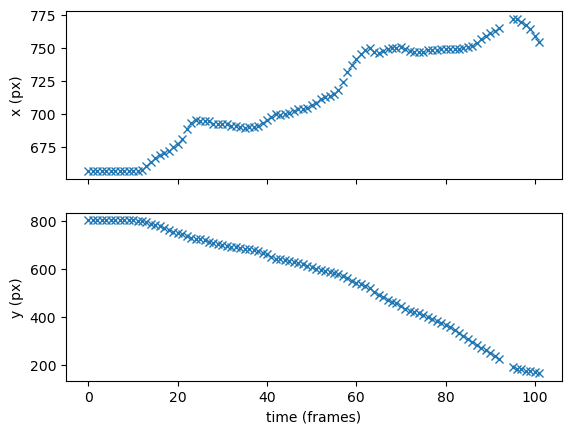

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
axes[0].plot(frames,xs,'x')
axes[0].set_ylabel('x (px)')
axes[1].plot(frames,ys,'x')
axes[1].set_ylabel('y (px)')
axes[1].set_xlabel('time (frames)')
# plt.savefig('fly-tracking2.png')

## Questions Part C

Describe: How did we get the background image? How did we compute a binary image? What did we do with the binary image?

(Answer here.)